<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/Cifar10_LAMBDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

SAVE_PATH = "/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323"

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

'2.4.1'

# Data generator

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

170500096/170498071 [==============================] - 2s 0us/step
x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


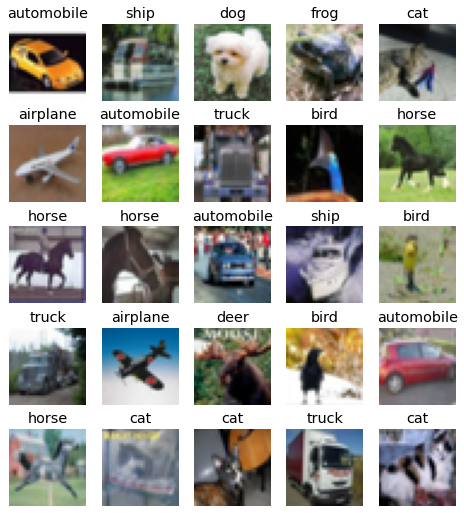

In [ ]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [ ]:
class Patches(tf.keras.layers.Layer):
  """Creates patches from an image. Implemented as a keras layer."""
  def __init__(self, patch_size: int):
    super().__init__()
    self.patch_size = patch_size

  def call(self, x):
    batch_size = tf.shape(x)[0]
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

  def get_config(self):
    return {"patch_size": self.patch_size}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


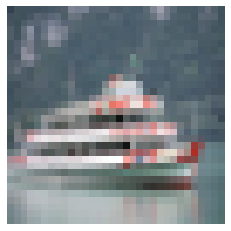

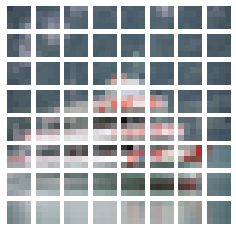

In [ ]:
plt.figure(figsize=(4, 4))
image = x_trn[np.random.choice(range(x_trn.shape[0]))]
plt.imshow(image)
plt.axis("off")

image_size = 32
patch_size = 4

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
def data_generator(split: str, batch_size: int, shuffle_buffer: int = 10000):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      shuffle_buffer: Number of elements used for shuffling.

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(shuffle_buffer)
  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
  else:
    raise ValueError(f"Unknown data split : {split}")
  return ds.batch(batch_size)

# Model

##CNN

A simple CNN example from the keras [CNN benchmark](https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py) .  
It is based on this [CNN example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) but the example is no longer available.


In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Conv2D, 
  BatchNormalization, 
  MaxPool2D,
  Dropout,
  Flatten,
  Dense
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  RandomFlip,
  RandomTranslation,
  RandomRotation,
  RandomZoom,
  Normalization,
  Rescaling,
  Resizing
)

def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  
def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

class SmallCNN(Model):
  """SmallCNN implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """

  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               preprocess: bool = False):
    super().__init__()

    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')
    self.conv3 = conv2d(64, 3, name='conv3', padding='same')
    self.conv4 = conv2d(64, 3, name='conv4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')
    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.dens6 = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)
    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)
    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)
    x = self.pool4(self.conv4(self.conv3(x)))
    x = self.drop4(x, training=training)
    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.dens6(x)
    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
    return {"num_classes": self.num_classes,
            "image_height": self.image_height,
            "image_width": self.image_width,
            "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

##VIT

[Vision Transformer](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al.  
Code taken from this [example](https://keras.io/examples/vision/image_classification_with_vision_transformer/) from the official keras website.

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Layer,
  Add,
  BatchNormalization, 
  Conv2D, 
  Dense,
  Dropout,
  Embedding,
  Flatten,
  LayerNormalization,
  MaxPool2D,
  MultiHeadAttention
)
from tensorflow.keras.initializers import TruncatedNormal, Constant, Zeros
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, gelu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)

def mlp(hidden_units: list, dropout_rate: float, name: str = ''):
  """Multilayer perceptron."""
  layers = []
  for idx, units in enumerate(hidden_units):
    layers.append(Dense(units, activation=gelu, name=f'{name}/dens{idx}'))
    layers.append(Dropout(dropout_rate, name=f'{name}/drop{idx}'))
  return layers

class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self, hidden_units: list, dropout_rate: float):
    super().__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    
    self.layers = []
    self.dropouts = []
    for idx, units in enumerate(self.hidden_units):
      self.layers.append(Dense(units, activation=gelu, name=f'dens{idx}'))
      self.dropouts.append(Dropout(dropout_rate))

  def call(self, x, training: bool = None):
    for layer_i, dropout_i in zip(self.layers, self.dropouts):
        x = layer_i(x)
        x = dropout_i(x, training=training)
    return x
  
  def get_config(self):
    return {"hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class PatchEncoder(Layer):
  """Encoder for the image patches."""
  def __init__(self, num_patches: int, projection_dim: int):
    super().__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = Dense(units=self.projection_dim)
    self.position_embedding = Embedding(input_dim=num_patches,
                                        output_dim=self.projection_dim)

  def call(self, x):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(x) + self.position_embedding(positions)
    return encoded
  
  def get_config(self):
    return {"num_patches": self.num_patches,
            "projection_dim": self.projection_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class VIT(Model):
  """Vision Transformer implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               patch_size: int, 
               projection_dim: int,
               num_layers: int,
               num_heads: int,
               mlp_dims: list,
               classifier_mlp_dims: list,
               preprocess: bool = False):
    super().__init__()
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.patch_size = patch_size
    self.projection_dim = projection_dim
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.mlp_dims = mlp_dims
    self.classifier_mlp_dims = classifier_mlp_dims
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Patches
    self.patch = Patches(self.patch_size)
    num_patches = (self.image_height // self.patch_size) * \
                  (self.image_width // self.patch_size)
    self.patch_enc = PatchEncoder(num_patches, self.projection_dim)

    # Model
    self.transformer_blocks = []
    for idx in range(self.num_layers):
      block = []
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_1')]
      block += [MultiHeadAttention(self.num_heads, 
                                   self.projection_dim, 
                                   dropout=0.1, 
                                   name=f'mha{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_1')]
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_2')]
      block += [mlp(mlp_dims, dropout_rate=0.1, name=f'mlp{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_2')]
      self.transformer_blocks.append(block)

    self.lnorm = LayerNormalization(epsilon=1e-6, name='classifier_ln')
    self.flat = Flatten(name='classifier_flat')
    self.drop = Dropout(0.5, name='classifier_drop')
    self.mlp = mlp(self.classifier_mlp_dims, dropout_rate=0.5, 
                   name='classifier_mlp')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.patch(x)
    x = self.patch_enc(x)
    
    for block in self.transformer_blocks:
      x_layer_norm_1 = block[0](x)
      x_attention    = block[1](x_layer_norm_1, x_layer_norm_1)
      x_skip         = block[2]([x_attention, x])
      x_layer_norm_2 = block[3](x_skip)
      x_mlp          = self._iterate_mlp(block[4], x_layer_norm_2)
      x              = block[5]([x_mlp, x_skip])
    
    x = self.lnorm(x)
    x = self.flat(x)
    x = self.drop(x, training=training)
    x = self._iterate_mlp(self.mlp, x)
    x = self.logits(x)
    return x
  
  @staticmethod
  def _iterate_mlp(mlp_layers: list, x: tf.Tensor):
    _x = x
    for mlp_i in mlp_layers:
      _x = mlp_i(_x)
    return _x

  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

##LambdaNetworks

[LambdaNetworks](https://arxiv.org/abs/2102.08602) from Irwan Bello.  

The LambdaNets is based on [tfkeras.py](https://github.com/lucidrains/lambda-networks/blob/main/lambda_networks/tfkeras.py) from [lucidrains/lambda-networks](https://github.com/lucidrains/lambda-networks) and [lambda2d.py](https://github.com/g0lemXIV/LambdaNetworks/blob/main/lambda_layers/lambda2d.py) from [g0lemXIV/LambdaNetworks](https://github.com/g0lemXIV/LambdaNetworks) .  

**Good to know points from the paper**
*   The paper main introduces lambdalayer and uses it to replace the convs in ResNet to create LambdaResNet.
*   LambdaResNet achieves high accuracy but is very slow (~7x slower).
*   The main conclusion is that a hybrid model of conv + lambda has the best speed-accuracy tradeoff.
*   The best hybrid model replaces only some blocks in C4 and all the blocks in C5.




In [ ]:
! pip install einops
from einops.layers.tensorflow import Rearrange

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  BatchNormalization, 
  Conv2D,
  Conv3D
)
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.activations import relu
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)
from tensorflow import einsum, meshgrid


def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
  return Conv2D(filters, 
                kernel_size, 
                strides, 
                padding=padding, 
                activation=relu,
                **kwargs)
  

def maxpool2d(**kwargs):
  return MaxPool2D([3, 3], 2, padding='valid', **kwargs)


def calc_rel_pos(n: int):
  """Generates a relative position meshgrid.
  
  Args:
    n: Size of the original meshgrid. Size = Height = Width.

  Returns: 
    rel_pos: An array of [n*n, n*n, 2] with value range from [-n+1, n-1] to 
             [0, 2n-2].
  """
  # [2, n, n]
  pos = tf.stack(meshgrid(tf.range(n), tf.range(n), indexing = 'ij'))
  # [n*n, 2], pos[n] = (i, j)
  pos = Rearrange('n i j -> (i j) n')(pos)             
  # [n*n, n*n, 2], rel_pos[n, m] = (rel_i, rel_j)
  rel_pos = pos[None, :] - pos[:, None]                
  # shift value range from [-n+1, n-1] to [0, 2n-2]
  rel_pos += n - 1
  # [n*n, n*n, 2]                      
  return rel_pos


class Lambda(Layer):
  """Lambda Networks implementation."""

  def __init__(self,
               output_dim: int,
               k_dim: int = 16,
               u_dim: int = 1,
               num_heads: int = 4,
               n_r_size: int = None,
               local_contexts: bool = False,
               batch_norm: bool = True,
               **kwargs):
    """Constructor

    Args:
      output_dim: Output dimension of the layer or v_dim * `num_heads`.
      k_dim: Dimension of key.
      u_dim: Intra depth for multiquery heads.
      num_heads: Number of heads for multiquery.
      n_r_size: If `local_contexts=True` n = height*width of query,
                else r = receptive field.
      local_contexts: If True lambdaconv is used, 
                      else relative position embeddings are used.
      batch_norm: Whether to apply batch norm to query and value after
                  the linear projection.

    """
    super().__init__(**kwargs)

    self.output_dim = output_dim
    self.u_dim = u_dim  # intra-depth dimension
    self.num_heads = num_heads
    self.n_r_size = n_r_size
    self.local_contexts = local_contexts
    self.batch_norm = batch_norm

    assert (self.output_dim % self.num_heads) == 0, \
      '`output_dim` must be divisible by `num_heads` for multi-head query.'
    self.v_dim = self.output_dim // self.num_heads
    self.k_dim = k_dim
    self.num_heads = num_heads

    self.to_q = Conv2D(self.k_dim * self.num_heads, 1, use_bias=self.batch_norm)
    self.to_k = Conv2D(self.k_dim * self.u_dim, 1, use_bias=self.batch_norm)
    self.to_v = Conv2D(self.v_dim * self.u_dim, 1, use_bias=self.batch_norm)

    self.norm_q = BatchNormalization() if self.batch_norm else None
    self.norm_v = BatchNormalization() if self.batch_norm else None

    if self.local_contexts:
      assert (self.n_r_size % 2) == 1, 'Receptive kernel size should be odd'
      self.pos_conv = Conv3D(self.k_dim, 
                             (1, self.n_r_size, self.n_r_size), 
                             padding='same')
    else:
      assert n is not None, 'You must specify the window length (n = h = w)'
      rel_length = 2 * self.n_r_size - 1
      self.rel_pos_emb = self.add_weight(name='pos_emb',
                                         shape=(rel_length, rel_length, 
                                                self.k_dim, self.u_dim),
                                         initializer=RandomNormal,
                                         trainable=True)
      self.rel_pos = calc_rel_pos(self.n_r_size)

  def call(self, x):
    """
    Info on the notations for reference:
    x = 2D Image data (Assumption)
    q = query
    k = key
    v = value
    h = number of heads for multiquery
    u = intradepth
    b = batch size
    hh = height of input data
    ww = width of input data
    m = height * width of key / value.
    n = height * width of query.
    """
    b, hh, ww, c, u, h = *x.get_shape().as_list(), self.u_dim, self.num_heads

    q = self.to_q(x)
    k = self.to_k(x)
    v = self.to_v(x)

    if self.batch_norm:
      q = self.norm_q(q)
      v = self.norm_v(v)

    q = Rearrange('b hh ww (h k) -> b h k (hh ww)', h=h)(q)
    k = Rearrange('b hh ww (u k) -> b u k (hh ww)', u=u)(k)
    v = Rearrange('b hh ww (u v) -> b u v (hh ww)', u=u)(v)

    k = tf.nn.softmax(k)

    Lc = einsum('b u k m, b u v m -> b k v', k, v)
    Yc = einsum('b h k n, b k v -> b n h v', q, Lc)

    if self.local_contexts:
      # lambda convs, embedding is represented by the conv kernels.
      v = Rearrange('b u v (hh ww) -> b v hh ww u', hh=hh, ww=ww)(v)
      Lp = self.pos_conv(v)
      Lp = Rearrange('b v h w k -> b v k (h w)')(Lp)
      Yp = einsum('b h k n, b v k n -> b n h v', q, Lp)
    else:
      # relative position embedding.
      rel_pos_emb = tf.gather_nd(self.rel_pos_emb, self.rel_pos)
      Lp = einsum('n m k u, b u v m -> b n k v', rel_pos_emb, v)
      Yp = einsum('b h k n, b n k v -> b n h v', q, Lp)

    Y = Yc + Yp
    out = Rearrange('b (hh ww) h v -> b hh ww (h v)', hh = hh, ww = ww)(Y)
    return out

  def get_config(self):
    return {"output_dim": self.output_dim,
            "k_dim": self.k_dim,
            "u_dim": self.u_dim,
            "num_heads": self.num_heads,
            "n_r_size": self.n_r_size,
            "local_contexts": self.local_contexts,
            "batch_norm": self.batch_norm}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class LambdaNetwork(Model):
  """LambdaNetworks implementation. """
  
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               k_dim: int = 16,
               u_dim: int = 1,
               num_heads: int = 4,
               n_r_size: int = None,
               local_contexts: bool = False,
               preprocess: bool = False,
               **kwargs):
    super().__init__(**kwargs)
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.k_dim = k_dim
    self.u_dim = u_dim
    self.num_heads = num_heads
    self.n_r_size = n_r_size
    self.local_contexts = local_contexts
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = conv2d(32, 3, name='conv2')
    self.pool2 = maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')

    # self.lamb3 = Lambda(64, k_dim=8, u_dim=1, num_heads=2, n_r_size=14, 
    #                     local_contexts=False, batch_norm=False)
    # self.lamb4 = Lambda(64, k_dim=8, u_dim=1, num_heads=2, n_r_size=14, 
    #                     local_contexts=False, batch_norm=False)
    self.lamb3 = Lambda(64, k_dim=self.k_dim, u_dim=self.u_dim, 
                        num_heads=self.num_heads, n_r_size=self.n_r_size, 
                        local_contexts=self.local_contexts, batch_norm=False,
                        name='lamb3')
    self.lamb4 = Lambda(64, k_dim=self.k_dim, u_dim=self.u_dim, 
                        num_heads=self.num_heads, n_r_size=self.n_r_size, 
                        local_contexts=self.local_contexts, batch_norm=False,
                        name='lamb4')
    self.pool4 = maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')

    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)

    x = self.pool4(self.lamb4(self.lamb3(x)))
    x = self.drop4(x, training=training)

    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.logits(x)

    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

# Train

Training configs.

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 256
shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3

num_classes = 10 
image_height = 32
image_width = 32

Keras model.compile(...) and model.fit(...) .


In [ ]:
def train_and_eval(_model, _checkpoint_filepath, verbose=1):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      _checkpoint_filepath: Path to save a checkpoint.
      verbose: Option for logging output during train and eval.

  Returns:
      A history instance that contains logged values per epoch.

  """
  _model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_fn,
    metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    _checkpoint_filepath,
    monitor="val_sparse_categorical_accuracy",
    save_best_only=True,
  )

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(_checkpoint_filepath, 'logs'), 
    histogram_freq=epochs//10,
    update_freq='epoch'
  )

  start = time()
  history = _model.fit(
      data_generator('train', batch_size, shuffle_buffer), 
      epochs=epochs, 
      steps_per_epoch=len(data_generator('train', batch_size, shuffle_buffer)),
      validation_data=data_generator('val', batch_size),
      callbacks=[tensorboard_callback, checkpoint_callback],
      verbose=verbose
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  
  # Save history output, should be the same as the tensorboard logs.
  np.save(os.path.join(_checkpoint_filepath, 'history.npy'), history.history)
  
  return history

# Loss and accuracy plots

In [ ]:
def plot(losses: list, 
         accuracies: list, 
         legend_labels: list, 
         subplot_title: list):
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  
  for x, ll in zip(losses, legend_labels):
    c = ax1.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax1.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()   

  for x, ll in zip(accuracies, legend_labels):
    c = ax2.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax2.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()   

  plt.show()

#Experiments

In [ ]:
history = dict()

##Exp 1
Model : CNN  
Preprocessing : False  
Batch size : 256

In [ ]:
model = SmallCNN(num_classes=num_classes, 
                 image_height=image_height, 
                 image_width=image_width,
                 preprocess=False).model()
model.summary()
history['CNN'] = train_and_eval(model, SAVE_PATH + '_CNN', verbose=2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0     

##Exp 2
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 2

In [ ]:
# Saves a full copy of the model.
model = VIT(num_classes=num_classes, 
            image_height=image_height, 
            image_width=image_width,
            patch_size=4, 
            projection_dim=32,
            num_layers=4,
            num_heads=2,
            mlp_dims=[64, 32],
            classifier_mlp_dims=[512],
            preprocess=False).model()
model.summary()
history['VIT'] = train_and_eval(model, SAVE_PATH + '_VIT_4x4_2hds', verbose=2)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 48)     0           resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.7072 - sparse_categorical_accuracy: 0.3775 - val_loss: 1.4654 - val_sparse_categorical_accuracy: 0.4720


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.5587 - sparse_categorical_accuracy: 0.4312 - val_loss: 1.4093 - val_sparse_categorical_accuracy: 0.4961


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.4578 - sparse_categorical_accuracy: 0.4725 - val_loss: 1.2855 - val_sparse_categorical_accuracy: 0.5354


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.3977 - sparse_categorical_accuracy: 0.4958 - val_loss: 1.2420 - val_sparse_categorical_accuracy: 0.5482


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.3296 - sparse_categorical_accuracy: 0.5233 - val_loss: 1.1754 - val_sparse_categorical_accuracy: 0.5787


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.2868 - sparse_categorical_accuracy: 0.5377 - val_loss: 1.1521 - val_sparse_categorical_accuracy: 0.5810


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.2424 - sparse_categorical_accuracy: 0.5539 - val_loss: 1.1191 - val_sparse_categorical_accuracy: 0.5951


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.2141 - sparse_categorical_accuracy: 0.5662 - val_loss: 1.0781 - val_sparse_categorical_accuracy: 0.6107


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 10/50
196/196 - 6s - loss: 1.1788 - sparse_categorical_accuracy: 0.5776 - val_loss: 1.0839 - val_sparse_categorical_accuracy: 0.6049
Epoch 11/50
196/196 - 6s - loss: 1.1511 - sparse_categorical_accuracy: 0.5890 - val_loss: 1.0549 - val_sparse_categorical_accuracy: 0.6226


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 12/50
196/196 - 6s - loss: 1.1217 - sparse_categorical_accuracy: 0.6014 - val_loss: 1.0272 - val_sparse_categorical_accuracy: 0.6289


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 13/50
196/196 - 6s - loss: 1.0942 - sparse_categorical_accuracy: 0.6103 - val_loss: 1.0334 - val_sparse_categorical_accuracy: 0.6219
Epoch 14/50
196/196 - 6s - loss: 1.0669 - sparse_categorical_accuracy: 0.6197 - val_loss: 1.0082 - val_sparse_categorical_accuracy: 0.6408


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 15/50
196/196 - 6s - loss: 1.0443 - sparse_categorical_accuracy: 0.6269 - val_loss: 0.9707 - val_sparse_categorical_accuracy: 0.6486


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 16/50
196/196 - 6s - loss: 1.0287 - sparse_categorical_accuracy: 0.6345 - val_loss: 0.9649 - val_sparse_categorical_accuracy: 0.6513


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 17/50
196/196 - 6s - loss: 1.0009 - sparse_categorical_accuracy: 0.6431 - val_loss: 0.9537 - val_sparse_categorical_accuracy: 0.6600


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 18/50
196/196 - 6s - loss: 0.9819 - sparse_categorical_accuracy: 0.6505 - val_loss: 0.9304 - val_sparse_categorical_accuracy: 0.6718


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 19/50
196/196 - 6s - loss: 0.9595 - sparse_categorical_accuracy: 0.6591 - val_loss: 0.9306 - val_sparse_categorical_accuracy: 0.6705
Epoch 20/50
196/196 - 6s - loss: 0.9577 - sparse_categorical_accuracy: 0.6577 - val_loss: 0.9258 - val_sparse_categorical_accuracy: 0.6742


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 21/50
196/196 - 6s - loss: 0.9310 - sparse_categorical_accuracy: 0.6702 - val_loss: 0.9180 - val_sparse_categorical_accuracy: 0.6723
Epoch 22/50
196/196 - 6s - loss: 0.9131 - sparse_categorical_accuracy: 0.6749 - val_loss: 0.8912 - val_sparse_categorical_accuracy: 0.6858


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 23/50
196/196 - 6s - loss: 0.8980 - sparse_categorical_accuracy: 0.6799 - val_loss: 0.8793 - val_sparse_categorical_accuracy: 0.6847
Epoch 24/50
196/196 - 6s - loss: 0.8820 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.8743 - val_sparse_categorical_accuracy: 0.6910


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 25/50
196/196 - 6s - loss: 0.8638 - sparse_categorical_accuracy: 0.6905 - val_loss: 0.8763 - val_sparse_categorical_accuracy: 0.6867
Epoch 26/50
196/196 - 6s - loss: 0.8465 - sparse_categorical_accuracy: 0.6986 - val_loss: 0.8663 - val_sparse_categorical_accuracy: 0.6936


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 27/50
196/196 - 6s - loss: 0.8361 - sparse_categorical_accuracy: 0.7020 - val_loss: 0.8728 - val_sparse_categorical_accuracy: 0.6889
Epoch 28/50
196/196 - 6s - loss: 0.8234 - sparse_categorical_accuracy: 0.7086 - val_loss: 0.8494 - val_sparse_categorical_accuracy: 0.6996


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 29/50
196/196 - 6s - loss: 0.8061 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.8624 - val_sparse_categorical_accuracy: 0.6981
Epoch 30/50
196/196 - 6s - loss: 0.7985 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.8629 - val_sparse_categorical_accuracy: 0.6987
Epoch 31/50
196/196 - 6s - loss: 0.7852 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.8379 - val_sparse_categorical_accuracy: 0.7024


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 32/50
196/196 - 6s - loss: 0.7762 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.8242 - val_sparse_categorical_accuracy: 0.7112


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 33/50
196/196 - 6s - loss: 0.7619 - sparse_categorical_accuracy: 0.7284 - val_loss: 0.8218 - val_sparse_categorical_accuracy: 0.7071
Epoch 34/50
196/196 - 6s - loss: 0.7564 - sparse_categorical_accuracy: 0.7330 - val_loss: 0.8533 - val_sparse_categorical_accuracy: 0.7015
Epoch 35/50
196/196 - 6s - loss: 0.7421 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.8177 - val_sparse_categorical_accuracy: 0.7130


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 36/50
196/196 - 6s - loss: 0.7229 - sparse_categorical_accuracy: 0.7418 - val_loss: 0.8244 - val_sparse_categorical_accuracy: 0.7107
Epoch 37/50
196/196 - 6s - loss: 0.7133 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.8130 - val_sparse_categorical_accuracy: 0.7123
Epoch 38/50
196/196 - 6s - loss: 0.7037 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.7976 - val_sparse_categorical_accuracy: 0.7218


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 39/50
196/196 - 6s - loss: 0.6902 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.8009 - val_sparse_categorical_accuracy: 0.7187
Epoch 40/50
196/196 - 6s - loss: 0.6886 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.8135 - val_sparse_categorical_accuracy: 0.7131
Epoch 41/50
196/196 - 6s - loss: 0.6731 - sparse_categorical_accuracy: 0.7602 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.7212
Epoch 42/50
196/196 - 6s - loss: 0.6617 - sparse_categorical_accuracy: 0.7638 - val_loss: 0.7898 - val_sparse_categorical_accuracy: 0.7234


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 43/50
196/196 - 6s - loss: 0.6600 - sparse_categorical_accuracy: 0.7654 - val_loss: 0.8034 - val_sparse_categorical_accuracy: 0.7213
Epoch 44/50
196/196 - 6s - loss: 0.6512 - sparse_categorical_accuracy: 0.7681 - val_loss: 0.7909 - val_sparse_categorical_accuracy: 0.7226
Epoch 45/50
196/196 - 6s - loss: 0.6384 - sparse_categorical_accuracy: 0.7721 - val_loss: 0.7869 - val_sparse_categorical_accuracy: 0.7250


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 46/50
196/196 - 6s - loss: 0.6362 - sparse_categorical_accuracy: 0.7748 - val_loss: 0.7808 - val_sparse_categorical_accuracy: 0.7279


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 47/50
196/196 - 6s - loss: 0.6303 - sparse_categorical_accuracy: 0.7764 - val_loss: 0.7727 - val_sparse_categorical_accuracy: 0.7299


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 48/50
196/196 - 6s - loss: 0.6203 - sparse_categorical_accuracy: 0.7765 - val_loss: 0.7717 - val_sparse_categorical_accuracy: 0.7311


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 49/50
196/196 - 6s - loss: 0.6104 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.7695 - val_sparse_categorical_accuracy: 0.7333


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Epoch 50/50
196/196 - 6s - loss: 0.6085 - sparse_categorical_accuracy: 0.7846 - val_loss: 0.7621 - val_sparse_categorical_accuracy: 0.7351


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_VIT_4x4_2hds/assets


Total training time 545.2050430774689 seconds


##Exp 3 - X Heads, Y Key dim
Model : LAMBDA  
Preprocessing : False  
Batch size : 256  
Key dim : 1,2,4,8  
u dim : 1  
Heads : 1,2,4,8  
Pos. emb. size : 14  
LambdaConv : False  

---
<pre>
Q = k * hd       =  1, 2, 4, 8| 2, 4, 8,16| 4, 8,16,32| 8,16,32,64|
K = k * u        =  1, 2, 4, 8| 1, 2, 4, 8| 1, 2, 4, 8| 1, 2, 4, 8|
V = 64 // hd * u = 64,64,64,64|32,32,32,32|16,16,16,16| 8, 8, 8, 8|
</pre>


In [ ]:
u_dim = 1
for hds in [1,2,4,8]:
  for k_dim in [1,2,4,8]:
    model = LambdaNetwork(num_classes=num_classes, 
                          image_height=image_height, 
                          image_width=image_width,
                          k_dim=k_dim,
                          u_dim=u_dim,
                          num_heads=hds,
                          n_r_size=14,
                          local_contexts=False,
                          preprocess=False).model()
    model.summary()
    if 'LAMBDA' not in history:
      history['LAMBDA'] = dict()
    if hds not in history['LAMBDA']:
      history['LAMBDA'][hds] = dict()
    if u_dim not in history['LAMBDA'][hds]:
      history['LAMBDA'][hds][u_dim] = dict()
    history['LAMBDA'][hds][u_dim][k_dim]= train_and_eval(model, SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds', verbose=2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0   

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.6739 - sparse_categorical_accuracy: 0.3867 - val_loss: 1.6357 - val_sparse_categorical_accuracy: 0.4218


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4889 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.5121 - val_sparse_categorical_accuracy: 0.4676


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3920 - sparse_categorical_accuracy: 0.4987 - val_loss: 1.4084 - val_sparse_categorical_accuracy: 0.5061


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.3131 - sparse_categorical_accuracy: 0.5318 - val_loss: 1.2645 - val_sparse_categorical_accuracy: 0.5508


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.2381 - sparse_categorical_accuracy: 0.5597 - val_loss: 1.1662 - val_sparse_categorical_accuracy: 0.5865


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1785 - sparse_categorical_accuracy: 0.5841 - val_loss: 1.0993 - val_sparse_categorical_accuracy: 0.6105


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.1314 - sparse_categorical_accuracy: 0.6008 - val_loss: 1.1828 - val_sparse_categorical_accuracy: 0.5859
Epoch 9/50
196/196 - 6s - loss: 1.0834 - sparse_categorical_accuracy: 0.6192 - val_loss: 0.9708 - val_sparse_categorical_accuracy: 0.6559


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 6s - loss: 1.0636 - sparse_categorical_accuracy: 0.6266 - val_loss: 0.9530 - val_sparse_categorical_accuracy: 0.6599


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 6s - loss: 1.0305 - sparse_categorical_accuracy: 0.6373 - val_loss: 0.9747 - val_sparse_categorical_accuracy: 0.6572
Epoch 12/50
196/196 - 6s - loss: 0.9996 - sparse_categorical_accuracy: 0.6498 - val_loss: 0.9076 - val_sparse_categorical_accuracy: 0.6815


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.9847 - sparse_categorical_accuracy: 0.6547 - val_loss: 0.9252 - val_sparse_categorical_accuracy: 0.6804
Epoch 14/50
196/196 - 6s - loss: 0.9635 - sparse_categorical_accuracy: 0.6646 - val_loss: 0.9097 - val_sparse_categorical_accuracy: 0.6837


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.9484 - sparse_categorical_accuracy: 0.6664 - val_loss: 0.9091 - val_sparse_categorical_accuracy: 0.6889


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 6s - loss: 0.9334 - sparse_categorical_accuracy: 0.6746 - val_loss: 0.8693 - val_sparse_categorical_accuracy: 0.7020


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 17/50
196/196 - 6s - loss: 0.9230 - sparse_categorical_accuracy: 0.6769 - val_loss: 0.8577 - val_sparse_categorical_accuracy: 0.7070


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 6s - loss: 0.9045 - sparse_categorical_accuracy: 0.6849 - val_loss: 0.8720 - val_sparse_categorical_accuracy: 0.7028
Epoch 19/50
196/196 - 6s - loss: 0.8946 - sparse_categorical_accuracy: 0.6865 - val_loss: 0.9158 - val_sparse_categorical_accuracy: 0.6958
Epoch 20/50
196/196 - 6s - loss: 0.8856 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.8203 - val_sparse_categorical_accuracy: 0.7200


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 21/50
196/196 - 6s - loss: 0.8758 - sparse_categorical_accuracy: 0.6943 - val_loss: 0.8463 - val_sparse_categorical_accuracy: 0.7034
Epoch 22/50
196/196 - 6s - loss: 0.8627 - sparse_categorical_accuracy: 0.6988 - val_loss: 0.8103 - val_sparse_categorical_accuracy: 0.7166
Epoch 23/50
196/196 - 6s - loss: 0.8593 - sparse_categorical_accuracy: 0.6990 - val_loss: 0.9559 - val_sparse_categorical_accuracy: 0.6935
Epoch 24/50
196/196 - 6s - loss: 0.8463 - sparse_categorical_accuracy: 0.7036 - val_loss: 0.7711 - val_sparse_categorical_accuracy: 0.7276


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 25/50
196/196 - 6s - loss: 0.8420 - sparse_categorical_accuracy: 0.7058 - val_loss: 0.7994 - val_sparse_categorical_accuracy: 0.7302


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 26/50
196/196 - 6s - loss: 0.8302 - sparse_categorical_accuracy: 0.7089 - val_loss: 0.7608 - val_sparse_categorical_accuracy: 0.7301
Epoch 27/50
196/196 - 6s - loss: 0.8218 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.7697 - val_sparse_categorical_accuracy: 0.7286
Epoch 28/50
196/196 - 6s - loss: 0.8166 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.8062 - val_sparse_categorical_accuracy: 0.7215
Epoch 29/50
196/196 - 6s - loss: 0.7997 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.7559 - val_sparse_categorical_accuracy: 0.7410


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 30/50
196/196 - 6s - loss: 0.7967 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.7696 - val_sparse_categorical_accuracy: 0.7360
Epoch 31/50
196/196 - 6s - loss: 0.7856 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.7618 - val_sparse_categorical_accuracy: 0.7309
Epoch 32/50
196/196 - 6s - loss: 0.7783 - sparse_categorical_accuracy: 0.7270 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.7297
Epoch 33/50
196/196 - 6s - loss: 0.7769 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.7473 - val_sparse_categorical_accuracy: 0.7394
Epoch 34/50
196/196 - 6s - loss: 0.7690 - sparse_categorical_accuracy: 0.7310 - val_loss: 0.7781 - val_sparse_categorical_accuracy: 0.7422


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 35/50
196/196 - 6s - loss: 0.7637 - sparse_categorical_accuracy: 0.7321 - val_loss: 0.7512 - val_sparse_categorical_accuracy: 0.7425


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 36/50
196/196 - 6s - loss: 0.7536 - sparse_categorical_accuracy: 0.7356 - val_loss: 0.7786 - val_sparse_categorical_accuracy: 0.7521


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 37/50
196/196 - 6s - loss: 0.7537 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.7858 - val_sparse_categorical_accuracy: 0.7483
Epoch 38/50
196/196 - 6s - loss: 0.7468 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.8365 - val_sparse_categorical_accuracy: 0.7342
Epoch 39/50
196/196 - 6s - loss: 0.7353 - sparse_categorical_accuracy: 0.7413 - val_loss: 0.7008 - val_sparse_categorical_accuracy: 0.7562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 40/50
196/196 - 6s - loss: 0.7269 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.7066 - val_sparse_categorical_accuracy: 0.7544
Epoch 41/50
196/196 - 6s - loss: 0.7238 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.7502 - val_sparse_categorical_accuracy: 0.7534
Epoch 42/50
196/196 - 6s - loss: 0.7188 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.7275 - val_sparse_categorical_accuracy: 0.7551
Epoch 43/50
196/196 - 6s - loss: 0.7157 - sparse_categorical_accuracy: 0.7487 - val_loss: 0.7032 - val_sparse_categorical_accuracy: 0.7600


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 44/50
196/196 - 6s - loss: 0.7050 - sparse_categorical_accuracy: 0.7528 - val_loss: 0.6891 - val_sparse_categorical_accuracy: 0.7577
Epoch 45/50
196/196 - 6s - loss: 0.7049 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.7701 - val_sparse_categorical_accuracy: 0.7519
Epoch 46/50
196/196 - 6s - loss: 0.6936 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.7644 - val_sparse_categorical_accuracy: 0.7520
Epoch 47/50
196/196 - 6s - loss: 0.6983 - sparse_categorical_accuracy: 0.7555 - val_loss: 0.6840 - val_sparse_categorical_accuracy: 0.7630


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 48/50
196/196 - 6s - loss: 0.6872 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.6682 - val_sparse_categorical_accuracy: 0.7677


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 49/50
196/196 - 6s - loss: 0.6837 - sparse_categorical_accuracy: 0.7602 - val_loss: 0.6902 - val_sparse_categorical_accuracy: 0.7686


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_1hds/assets


Epoch 50/50
196/196 - 6s - loss: 0.6759 - sparse_categorical_accuracy: 0.7630 - val_loss: 0.7365 - val_sparse_categorical_accuracy: 0.7542
Total training time 373.8983519077301 seconds
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5890 - sparse_categorical_accuracy: 0.4264 - val_loss: 1.5203 - val_sparse_categorical_accuracy: 0.4767


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.4395 - sparse_categorical_accuracy: 0.4816 - val_loss: 1.3304 - val_sparse_categorical_accuracy: 0.5209


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.3441 - sparse_categorical_accuracy: 0.5197 - val_loss: 1.2177 - val_sparse_categorical_accuracy: 0.5608


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2651 - sparse_categorical_accuracy: 0.5512 - val_loss: 1.1447 - val_sparse_categorical_accuracy: 0.5918


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.2081 - sparse_categorical_accuracy: 0.5705 - val_loss: 1.1208 - val_sparse_categorical_accuracy: 0.5940


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.1470 - sparse_categorical_accuracy: 0.5918 - val_loss: 1.0420 - val_sparse_categorical_accuracy: 0.6270


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 7s - loss: 1.1098 - sparse_categorical_accuracy: 0.6080 - val_loss: 1.0514 - val_sparse_categorical_accuracy: 0.6228
Epoch 9/50
196/196 - 7s - loss: 1.0873 - sparse_categorical_accuracy: 0.6142 - val_loss: 0.9903 - val_sparse_categorical_accuracy: 0.6480


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 7s - loss: 1.0636 - sparse_categorical_accuracy: 0.6248 - val_loss: 1.0056 - val_sparse_categorical_accuracy: 0.6456
Epoch 11/50
196/196 - 7s - loss: 1.0338 - sparse_categorical_accuracy: 0.6351 - val_loss: 0.9213 - val_sparse_categorical_accuracy: 0.6785


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 7s - loss: 1.0237 - sparse_categorical_accuracy: 0.6385 - val_loss: 1.0027 - val_sparse_categorical_accuracy: 0.6496
Epoch 13/50
196/196 - 7s - loss: 0.9982 - sparse_categorical_accuracy: 0.6476 - val_loss: 0.9078 - val_sparse_categorical_accuracy: 0.6818


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.9861 - sparse_categorical_accuracy: 0.6534 - val_loss: 0.8706 - val_sparse_categorical_accuracy: 0.6912


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 15/50
196/196 - 7s - loss: 0.9642 - sparse_categorical_accuracy: 0.6584 - val_loss: 0.8592 - val_sparse_categorical_accuracy: 0.6994


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 7s - loss: 0.9579 - sparse_categorical_accuracy: 0.6650 - val_loss: 0.8753 - val_sparse_categorical_accuracy: 0.6940
Epoch 17/50
196/196 - 7s - loss: 0.9442 - sparse_categorical_accuracy: 0.6682 - val_loss: 0.8528 - val_sparse_categorical_accuracy: 0.7031


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 7s - loss: 0.9358 - sparse_categorical_accuracy: 0.6737 - val_loss: 0.8742 - val_sparse_categorical_accuracy: 0.6997
Epoch 19/50
196/196 - 7s - loss: 0.9226 - sparse_categorical_accuracy: 0.6761 - val_loss: 0.8455 - val_sparse_categorical_accuracy: 0.7001
Epoch 20/50
196/196 - 7s - loss: 0.9059 - sparse_categorical_accuracy: 0.6806 - val_loss: 0.8301 - val_sparse_categorical_accuracy: 0.7108


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 21/50
196/196 - 7s - loss: 0.8921 - sparse_categorical_accuracy: 0.6904 - val_loss: 0.8317 - val_sparse_categorical_accuracy: 0.7099
Epoch 22/50
196/196 - 7s - loss: 0.8875 - sparse_categorical_accuracy: 0.6868 - val_loss: 0.8135 - val_sparse_categorical_accuracy: 0.7136


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 23/50
196/196 - 7s - loss: 0.8799 - sparse_categorical_accuracy: 0.6899 - val_loss: 0.7889 - val_sparse_categorical_accuracy: 0.7176


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 24/50
196/196 - 7s - loss: 0.8654 - sparse_categorical_accuracy: 0.6942 - val_loss: 0.7806 - val_sparse_categorical_accuracy: 0.7209


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 25/50
196/196 - 7s - loss: 0.8580 - sparse_categorical_accuracy: 0.6975 - val_loss: 0.8054 - val_sparse_categorical_accuracy: 0.7214


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 26/50
196/196 - 7s - loss: 0.8496 - sparse_categorical_accuracy: 0.7023 - val_loss: 0.7997 - val_sparse_categorical_accuracy: 0.7232


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 27/50
196/196 - 7s - loss: 0.8385 - sparse_categorical_accuracy: 0.7067 - val_loss: 0.7754 - val_sparse_categorical_accuracy: 0.7329


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 28/50
196/196 - 7s - loss: 0.8370 - sparse_categorical_accuracy: 0.7074 - val_loss: 0.7670 - val_sparse_categorical_accuracy: 0.7309
Epoch 29/50
196/196 - 7s - loss: 0.8329 - sparse_categorical_accuracy: 0.7084 - val_loss: 0.7936 - val_sparse_categorical_accuracy: 0.7235
Epoch 30/50
196/196 - 7s - loss: 0.8211 - sparse_categorical_accuracy: 0.7104 - val_loss: 0.7715 - val_sparse_categorical_accuracy: 0.7312
Epoch 31/50
196/196 - 7s - loss: 0.8123 - sparse_categorical_accuracy: 0.7164 - val_loss: 0.7765 - val_sparse_categorical_accuracy: 0.7313
Epoch 32/50
196/196 - 7s - loss: 0.8062 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.7688 - val_sparse_categorical_accuracy: 0.7293
Epoch 33/50
196/196 - 7s - loss: 0.8055 - sparse_categorical_accuracy: 0.7174 - val_loss: 0.7502 - val_sparse_categorical_accuracy: 0.7401


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 34/50
196/196 - 7s - loss: 0.7971 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.7308 - val_sparse_categorical_accuracy: 0.7455


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 35/50
196/196 - 7s - loss: 0.7885 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.7281 - val_sparse_categorical_accuracy: 0.7432
Epoch 36/50
196/196 - 7s - loss: 0.7774 - sparse_categorical_accuracy: 0.7268 - val_loss: 0.7333 - val_sparse_categorical_accuracy: 0.7488


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 37/50
196/196 - 7s - loss: 0.7733 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.7370 - val_sparse_categorical_accuracy: 0.7414
Epoch 38/50
196/196 - 7s - loss: 0.7729 - sparse_categorical_accuracy: 0.7287 - val_loss: 0.7166 - val_sparse_categorical_accuracy: 0.7537


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 39/50
196/196 - 7s - loss: 0.7603 - sparse_categorical_accuracy: 0.7341 - val_loss: 0.7280 - val_sparse_categorical_accuracy: 0.7521
Epoch 40/50
196/196 - 7s - loss: 0.7540 - sparse_categorical_accuracy: 0.7348 - val_loss: 0.7166 - val_sparse_categorical_accuracy: 0.7607


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 41/50
196/196 - 7s - loss: 0.7456 - sparse_categorical_accuracy: 0.7383 - val_loss: 0.6952 - val_sparse_categorical_accuracy: 0.7592
Epoch 42/50
196/196 - 7s - loss: 0.7500 - sparse_categorical_accuracy: 0.7379 - val_loss: 0.6927 - val_sparse_categorical_accuracy: 0.7615


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 43/50
196/196 - 7s - loss: 0.7384 - sparse_categorical_accuracy: 0.7381 - val_loss: 0.7107 - val_sparse_categorical_accuracy: 0.7593
Epoch 44/50
196/196 - 7s - loss: 0.7286 - sparse_categorical_accuracy: 0.7456 - val_loss: 0.7488 - val_sparse_categorical_accuracy: 0.7616


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 45/50
196/196 - 7s - loss: 0.7346 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.7474 - val_sparse_categorical_accuracy: 0.7588
Epoch 46/50
196/196 - 7s - loss: 0.7319 - sparse_categorical_accuracy: 0.7433 - val_loss: 0.6966 - val_sparse_categorical_accuracy: 0.7657


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 47/50
196/196 - 7s - loss: 0.7265 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.7039 - val_sparse_categorical_accuracy: 0.7575
Epoch 48/50
196/196 - 7s - loss: 0.7185 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.7001 - val_sparse_categorical_accuracy: 0.7678


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Epoch 49/50
196/196 - 7s - loss: 0.7136 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.6878 - val_sparse_categorical_accuracy: 0.7647
Epoch 50/50
196/196 - 7s - loss: 0.7107 - sparse_categorical_accuracy: 0.7499 - val_loss: 0.6642 - val_sparse_categorical_accuracy: 0.7687


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_1hds/assets


Total training time 438.0464377403259 seconds
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropou

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.6177 - sparse_categorical_accuracy: 0.4047 - val_loss: 1.5537 - val_sparse_categorical_accuracy: 0.4404


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.4487 - sparse_categorical_accuracy: 0.4761 - val_loss: 1.3992 - val_sparse_categorical_accuracy: 0.4945


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.3256 - sparse_categorical_accuracy: 0.5209 - val_loss: 1.2746 - val_sparse_categorical_accuracy: 0.5417


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.2382 - sparse_categorical_accuracy: 0.5556 - val_loss: 1.1645 - val_sparse_categorical_accuracy: 0.5839


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.1795 - sparse_categorical_accuracy: 0.5811 - val_loss: 1.2360 - val_sparse_categorical_accuracy: 0.5708
Epoch 7/50
196/196 - 9s - loss: 1.1456 - sparse_categorical_accuracy: 0.5914 - val_loss: 1.1348 - val_sparse_categorical_accuracy: 0.5924


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 9s - loss: 1.1000 - sparse_categorical_accuracy: 0.6101 - val_loss: 1.1102 - val_sparse_categorical_accuracy: 0.6021


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 9s - loss: 1.0675 - sparse_categorical_accuracy: 0.6189 - val_loss: 1.0204 - val_sparse_categorical_accuracy: 0.6425


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 9s - loss: 1.0387 - sparse_categorical_accuracy: 0.6301 - val_loss: 0.9925 - val_sparse_categorical_accuracy: 0.6437


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 9s - loss: 1.0148 - sparse_categorical_accuracy: 0.6407 - val_loss: 0.9094 - val_sparse_categorical_accuracy: 0.6750


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 9s - loss: 1.0001 - sparse_categorical_accuracy: 0.6459 - val_loss: 0.9344 - val_sparse_categorical_accuracy: 0.6693
Epoch 13/50
196/196 - 9s - loss: 0.9844 - sparse_categorical_accuracy: 0.6519 - val_loss: 0.9579 - val_sparse_categorical_accuracy: 0.6630
Epoch 14/50
196/196 - 9s - loss: 0.9632 - sparse_categorical_accuracy: 0.6600 - val_loss: 0.9162 - val_sparse_categorical_accuracy: 0.6761


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 15/50
196/196 - 9s - loss: 0.9399 - sparse_categorical_accuracy: 0.6682 - val_loss: 0.8951 - val_sparse_categorical_accuracy: 0.6843


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 16/50
196/196 - 9s - loss: 0.9269 - sparse_categorical_accuracy: 0.6719 - val_loss: 0.9088 - val_sparse_categorical_accuracy: 0.6780
Epoch 17/50
196/196 - 9s - loss: 0.9196 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.8973 - val_sparse_categorical_accuracy: 0.6831
Epoch 18/50
196/196 - 9s - loss: 0.9108 - sparse_categorical_accuracy: 0.6797 - val_loss: 0.8658 - val_sparse_categorical_accuracy: 0.6961


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 19/50
196/196 - 9s - loss: 0.9004 - sparse_categorical_accuracy: 0.6832 - val_loss: 0.8930 - val_sparse_categorical_accuracy: 0.6835
Epoch 20/50
196/196 - 9s - loss: 0.8809 - sparse_categorical_accuracy: 0.6891 - val_loss: 0.8569 - val_sparse_categorical_accuracy: 0.7026


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 21/50
196/196 - 9s - loss: 0.8750 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.8809 - val_sparse_categorical_accuracy: 0.6999
Epoch 22/50
196/196 - 9s - loss: 0.8682 - sparse_categorical_accuracy: 0.6956 - val_loss: 0.8165 - val_sparse_categorical_accuracy: 0.7108


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 23/50
196/196 - 9s - loss: 0.8479 - sparse_categorical_accuracy: 0.7011 - val_loss: 0.8266 - val_sparse_categorical_accuracy: 0.7119


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 24/50
196/196 - 9s - loss: 0.8407 - sparse_categorical_accuracy: 0.7033 - val_loss: 0.8057 - val_sparse_categorical_accuracy: 0.7199


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 25/50
196/196 - 9s - loss: 0.8314 - sparse_categorical_accuracy: 0.7064 - val_loss: 0.8161 - val_sparse_categorical_accuracy: 0.7171
Epoch 26/50
196/196 - 9s - loss: 0.8362 - sparse_categorical_accuracy: 0.7068 - val_loss: 0.7994 - val_sparse_categorical_accuracy: 0.7197
Epoch 27/50
196/196 - 9s - loss: 0.8169 - sparse_categorical_accuracy: 0.7133 - val_loss: 0.7951 - val_sparse_categorical_accuracy: 0.7200


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 28/50
196/196 - 9s - loss: 0.8135 - sparse_categorical_accuracy: 0.7143 - val_loss: 0.7843 - val_sparse_categorical_accuracy: 0.7300


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 29/50
196/196 - 9s - loss: 0.8083 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.8025 - val_sparse_categorical_accuracy: 0.7285
Epoch 30/50
196/196 - 9s - loss: 0.7903 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.7709 - val_sparse_categorical_accuracy: 0.7366


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 31/50
196/196 - 9s - loss: 0.7906 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.7705 - val_sparse_categorical_accuracy: 0.7311
Epoch 32/50
196/196 - 9s - loss: 0.7800 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.7712 - val_sparse_categorical_accuracy: 0.7343
Epoch 33/50
196/196 - 9s - loss: 0.7763 - sparse_categorical_accuracy: 0.7270 - val_loss: 0.7889 - val_sparse_categorical_accuracy: 0.7383


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 34/50
196/196 - 9s - loss: 0.7750 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.7843 - val_sparse_categorical_accuracy: 0.7272
Epoch 35/50
196/196 - 9s - loss: 0.7690 - sparse_categorical_accuracy: 0.7265 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.7427


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 36/50
196/196 - 9s - loss: 0.7585 - sparse_categorical_accuracy: 0.7347 - val_loss: 0.7804 - val_sparse_categorical_accuracy: 0.7288
Epoch 37/50
196/196 - 9s - loss: 0.7565 - sparse_categorical_accuracy: 0.7330 - val_loss: 0.7397 - val_sparse_categorical_accuracy: 0.7464


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 38/50
196/196 - 9s - loss: 0.7457 - sparse_categorical_accuracy: 0.7367 - val_loss: 0.7836 - val_sparse_categorical_accuracy: 0.7371
Epoch 39/50
196/196 - 9s - loss: 0.7463 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.7328 - val_sparse_categorical_accuracy: 0.7522


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 40/50
196/196 - 9s - loss: 0.7363 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.7539 - val_sparse_categorical_accuracy: 0.7520
Epoch 41/50
196/196 - 9s - loss: 0.7405 - sparse_categorical_accuracy: 0.7387 - val_loss: 0.7066 - val_sparse_categorical_accuracy: 0.7575


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 42/50
196/196 - 9s - loss: 0.7256 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.7584 - val_sparse_categorical_accuracy: 0.7563
Epoch 43/50
196/196 - 9s - loss: 0.7216 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.7484
Epoch 44/50
196/196 - 9s - loss: 0.7180 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.7496
Epoch 45/50
196/196 - 9s - loss: 0.7161 - sparse_categorical_accuracy: 0.7497 - val_loss: 0.7314 - val_sparse_categorical_accuracy: 0.7578


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_1hds/assets


Epoch 46/50
196/196 - 9s - loss: 0.7093 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.7389 - val_sparse_categorical_accuracy: 0.7524
Epoch 47/50
196/196 - 9s - loss: 0.7022 - sparse_categorical_accuracy: 0.7533 - val_loss: 0.7355 - val_sparse_categorical_accuracy: 0.7517
Epoch 48/50
196/196 - 9s - loss: 0.7091 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.7049 - val_sparse_categorical_accuracy: 0.7558
Epoch 49/50
196/196 - 9s - loss: 0.6967 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.7199 - val_sparse_categorical_accuracy: 0.7562
Epoch 50/50
196/196 - 9s - loss: 0.6901 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.7694 - val_sparse_categorical_accuracy: 0.7466
Total training time 501.1399636268616 seconds
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
____________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 2/50
196/196 - 12s - loss: 1.6279 - sparse_categorical_accuracy: 0.4051 - val_loss: 1.5823 - val_sparse_categorical_accuracy: 0.4178


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 3/50
196/196 - 12s - loss: 1.4496 - sparse_categorical_accuracy: 0.4709 - val_loss: 1.4704 - val_sparse_categorical_accuracy: 0.4672


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 4/50
196/196 - 12s - loss: 1.3337 - sparse_categorical_accuracy: 0.5185 - val_loss: 1.4524 - val_sparse_categorical_accuracy: 0.4869


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 5/50
196/196 - 12s - loss: 1.2452 - sparse_categorical_accuracy: 0.5530 - val_loss: 1.3499 - val_sparse_categorical_accuracy: 0.5268


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 6/50
196/196 - 12s - loss: 1.1798 - sparse_categorical_accuracy: 0.5813 - val_loss: 1.0985 - val_sparse_categorical_accuracy: 0.6089


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 7/50
196/196 - 12s - loss: 1.1292 - sparse_categorical_accuracy: 0.5991 - val_loss: 1.0452 - val_sparse_categorical_accuracy: 0.6342


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 8/50
196/196 - 12s - loss: 1.0885 - sparse_categorical_accuracy: 0.6170 - val_loss: 0.9866 - val_sparse_categorical_accuracy: 0.6533


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 9/50
196/196 - 12s - loss: 1.0484 - sparse_categorical_accuracy: 0.6294 - val_loss: 0.9540 - val_sparse_categorical_accuracy: 0.6657


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 10/50
196/196 - 12s - loss: 1.0190 - sparse_categorical_accuracy: 0.6417 - val_loss: 0.9658 - val_sparse_categorical_accuracy: 0.6668


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 11/50
196/196 - 12s - loss: 1.0053 - sparse_categorical_accuracy: 0.6433 - val_loss: 0.9161 - val_sparse_categorical_accuracy: 0.6778


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 12/50
196/196 - 12s - loss: 0.9872 - sparse_categorical_accuracy: 0.6537 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.6523
Epoch 13/50
196/196 - 12s - loss: 0.9636 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.8616 - val_sparse_categorical_accuracy: 0.6995


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 14/50
196/196 - 12s - loss: 0.9436 - sparse_categorical_accuracy: 0.6669 - val_loss: 0.9228 - val_sparse_categorical_accuracy: 0.6847
Epoch 15/50
196/196 - 12s - loss: 0.9171 - sparse_categorical_accuracy: 0.6764 - val_loss: 0.8792 - val_sparse_categorical_accuracy: 0.6918
Epoch 16/50
196/196 - 12s - loss: 0.9078 - sparse_categorical_accuracy: 0.6816 - val_loss: 0.9159 - val_sparse_categorical_accuracy: 0.6849
Epoch 17/50
196/196 - 12s - loss: 0.8939 - sparse_categorical_accuracy: 0.6868 - val_loss: 0.8480 - val_sparse_categorical_accuracy: 0.7045


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 18/50
196/196 - 12s - loss: 0.8782 - sparse_categorical_accuracy: 0.6937 - val_loss: 0.7966 - val_sparse_categorical_accuracy: 0.7235


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 19/50
196/196 - 12s - loss: 0.8736 - sparse_categorical_accuracy: 0.6921 - val_loss: 0.8599 - val_sparse_categorical_accuracy: 0.6948
Epoch 20/50
196/196 - 12s - loss: 0.8592 - sparse_categorical_accuracy: 0.6997 - val_loss: 0.8178 - val_sparse_categorical_accuracy: 0.7246


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 21/50
196/196 - 12s - loss: 0.8483 - sparse_categorical_accuracy: 0.7022 - val_loss: 0.7883 - val_sparse_categorical_accuracy: 0.7297


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 22/50
196/196 - 12s - loss: 0.8280 - sparse_categorical_accuracy: 0.7095 - val_loss: 0.8215 - val_sparse_categorical_accuracy: 0.7162
Epoch 23/50
196/196 - 12s - loss: 0.8188 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.7529 - val_sparse_categorical_accuracy: 0.7413


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 24/50
196/196 - 12s - loss: 0.8211 - sparse_categorical_accuracy: 0.7122 - val_loss: 0.7410 - val_sparse_categorical_accuracy: 0.7412
Epoch 25/50
196/196 - 12s - loss: 0.8040 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.7557 - val_sparse_categorical_accuracy: 0.7400
Epoch 26/50
196/196 - 12s - loss: 0.8044 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7628 - val_sparse_categorical_accuracy: 0.7355
Epoch 27/50
196/196 - 12s - loss: 0.7973 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7218 - val_sparse_categorical_accuracy: 0.7449


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 28/50
196/196 - 12s - loss: 0.7843 - sparse_categorical_accuracy: 0.7239 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.7413
Epoch 29/50
196/196 - 12s - loss: 0.7813 - sparse_categorical_accuracy: 0.7265 - val_loss: 0.7427 - val_sparse_categorical_accuracy: 0.7451


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 30/50
196/196 - 12s - loss: 0.7800 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.7293 - val_sparse_categorical_accuracy: 0.7492


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 31/50
196/196 - 12s - loss: 0.7713 - sparse_categorical_accuracy: 0.7306 - val_loss: 0.7284 - val_sparse_categorical_accuracy: 0.7488
Epoch 32/50
196/196 - 12s - loss: 0.7523 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.7463 - val_sparse_categorical_accuracy: 0.7496


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 33/50
196/196 - 12s - loss: 0.7641 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.7153 - val_sparse_categorical_accuracy: 0.7555


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 34/50
196/196 - 12s - loss: 0.7453 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.7058 - val_sparse_categorical_accuracy: 0.7566


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 35/50
196/196 - 12s - loss: 0.7449 - sparse_categorical_accuracy: 0.7395 - val_loss: 0.7174 - val_sparse_categorical_accuracy: 0.7536
Epoch 36/50
196/196 - 12s - loss: 0.7389 - sparse_categorical_accuracy: 0.7415 - val_loss: 0.7241 - val_sparse_categorical_accuracy: 0.7502
Epoch 37/50
196/196 - 12s - loss: 0.7409 - sparse_categorical_accuracy: 0.7388 - val_loss: 0.6946 - val_sparse_categorical_accuracy: 0.7586


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 38/50
196/196 - 12s - loss: 0.7254 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.6897 - val_sparse_categorical_accuracy: 0.7614


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 39/50
196/196 - 12s - loss: 0.7237 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.6871 - val_sparse_categorical_accuracy: 0.7641


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 40/50
196/196 - 12s - loss: 0.7130 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.7101 - val_sparse_categorical_accuracy: 0.7547
Epoch 41/50
196/196 - 12s - loss: 0.7180 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.6585 - val_sparse_categorical_accuracy: 0.7679


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 42/50
196/196 - 12s - loss: 0.7067 - sparse_categorical_accuracy: 0.7491 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.7618
Epoch 43/50
196/196 - 12s - loss: 0.7040 - sparse_categorical_accuracy: 0.7537 - val_loss: 0.7019 - val_sparse_categorical_accuracy: 0.7600
Epoch 44/50
196/196 - 12s - loss: 0.7043 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.7638
Epoch 45/50
196/196 - 12s - loss: 0.7012 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.6646 - val_sparse_categorical_accuracy: 0.7722


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 46/50
196/196 - 12s - loss: 0.6938 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.6673 - val_sparse_categorical_accuracy: 0.7745


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_1hds/assets


Epoch 47/50
196/196 - 12s - loss: 0.6929 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.6675 - val_sparse_categorical_accuracy: 0.7686
Epoch 48/50
196/196 - 12s - loss: 0.6901 - sparse_categorical_accuracy: 0.7592 - val_loss: 0.7037 - val_sparse_categorical_accuracy: 0.7649
Epoch 49/50
196/196 - 12s - loss: 0.6816 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.6537 - val_sparse_categorical_accuracy: 0.7732
Epoch 50/50
196/196 - 12s - loss: 0.6771 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.6565 - val_sparse_categorical_accuracy: 0.7730
Total training time 668.6443707942963 seconds
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_______________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.6892 - sparse_categorical_accuracy: 0.3818 - val_loss: 1.6366 - val_sparse_categorical_accuracy: 0.3988


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.5285 - sparse_categorical_accuracy: 0.4423 - val_loss: 1.5108 - val_sparse_categorical_accuracy: 0.4567


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.4221 - sparse_categorical_accuracy: 0.4827 - val_loss: 1.4354 - val_sparse_categorical_accuracy: 0.4817


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.3357 - sparse_categorical_accuracy: 0.5177 - val_loss: 1.2844 - val_sparse_categorical_accuracy: 0.5378


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 5s - loss: 1.2667 - sparse_categorical_accuracy: 0.5443 - val_loss: 1.1950 - val_sparse_categorical_accuracy: 0.5692


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 5s - loss: 1.2194 - sparse_categorical_accuracy: 0.5641 - val_loss: 1.1799 - val_sparse_categorical_accuracy: 0.5835


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 8/50
196/196 - 5s - loss: 1.1643 - sparse_categorical_accuracy: 0.5865 - val_loss: 1.1077 - val_sparse_categorical_accuracy: 0.6058


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.1272 - sparse_categorical_accuracy: 0.5986 - val_loss: 1.0716 - val_sparse_categorical_accuracy: 0.6238


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 10/50
196/196 - 5s - loss: 1.0999 - sparse_categorical_accuracy: 0.6091 - val_loss: 1.0345 - val_sparse_categorical_accuracy: 0.6353


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 11/50
196/196 - 5s - loss: 1.0659 - sparse_categorical_accuracy: 0.6203 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.6447


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 12/50
196/196 - 5s - loss: 1.0438 - sparse_categorical_accuracy: 0.6276 - val_loss: 0.9739 - val_sparse_categorical_accuracy: 0.6572


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 13/50
196/196 - 5s - loss: 1.0248 - sparse_categorical_accuracy: 0.6387 - val_loss: 0.9643 - val_sparse_categorical_accuracy: 0.6565
Epoch 14/50
196/196 - 5s - loss: 1.0065 - sparse_categorical_accuracy: 0.6423 - val_loss: 0.9496 - val_sparse_categorical_accuracy: 0.6649


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 15/50
196/196 - 5s - loss: 0.9900 - sparse_categorical_accuracy: 0.6497 - val_loss: 0.9356 - val_sparse_categorical_accuracy: 0.6737


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 16/50
196/196 - 5s - loss: 0.9716 - sparse_categorical_accuracy: 0.6549 - val_loss: 0.9358 - val_sparse_categorical_accuracy: 0.6704
Epoch 17/50
196/196 - 5s - loss: 0.9541 - sparse_categorical_accuracy: 0.6617 - val_loss: 0.9045 - val_sparse_categorical_accuracy: 0.6825


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 18/50
196/196 - 5s - loss: 0.9442 - sparse_categorical_accuracy: 0.6663 - val_loss: 0.9377 - val_sparse_categorical_accuracy: 0.6703
Epoch 19/50
196/196 - 5s - loss: 0.9398 - sparse_categorical_accuracy: 0.6668 - val_loss: 0.9123 - val_sparse_categorical_accuracy: 0.6778
Epoch 20/50
196/196 - 5s - loss: 0.9247 - sparse_categorical_accuracy: 0.6732 - val_loss: 0.8658 - val_sparse_categorical_accuracy: 0.6968


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 21/50
196/196 - 5s - loss: 0.9171 - sparse_categorical_accuracy: 0.6748 - val_loss: 0.8799 - val_sparse_categorical_accuracy: 0.6941
Epoch 22/50
196/196 - 5s - loss: 0.9043 - sparse_categorical_accuracy: 0.6804 - val_loss: 0.8652 - val_sparse_categorical_accuracy: 0.6941
Epoch 23/50
196/196 - 5s - loss: 0.8936 - sparse_categorical_accuracy: 0.6850 - val_loss: 0.8616 - val_sparse_categorical_accuracy: 0.6936
Epoch 24/50
196/196 - 5s - loss: 0.8806 - sparse_categorical_accuracy: 0.6879 - val_loss: 0.8760 - val_sparse_categorical_accuracy: 0.6959
Epoch 25/50
196/196 - 5s - loss: 0.8718 - sparse_categorical_accuracy: 0.6906 - val_loss: 0.9357 - val_sparse_categorical_accuracy: 0.6797
Epoch 26/50
196/196 - 5s - loss: 0.8703 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.8754 - val_sparse_categorical_accuracy: 0.6964
Epoch 27/50
196/196 - 5s - loss: 0.8636 - sparse_categorical_accuracy: 0.6967 - val_loss: 0.8269 - val_sparse_categorical_accuracy: 0.7132


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 28/50
196/196 - 5s - loss: 0.8512 - sparse_categorical_accuracy: 0.6969 - val_loss: 0.8606 - val_sparse_categorical_accuracy: 0.7011
Epoch 29/50
196/196 - 5s - loss: 0.8443 - sparse_categorical_accuracy: 0.6992 - val_loss: 0.8280 - val_sparse_categorical_accuracy: 0.7119
Epoch 30/50
196/196 - 5s - loss: 0.8448 - sparse_categorical_accuracy: 0.7001 - val_loss: 0.8198 - val_sparse_categorical_accuracy: 0.7139


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 31/50
196/196 - 5s - loss: 0.8351 - sparse_categorical_accuracy: 0.7038 - val_loss: 0.8604 - val_sparse_categorical_accuracy: 0.7023
Epoch 32/50
196/196 - 5s - loss: 0.8357 - sparse_categorical_accuracy: 0.7072 - val_loss: 0.8224 - val_sparse_categorical_accuracy: 0.7124
Epoch 33/50
196/196 - 5s - loss: 0.8175 - sparse_categorical_accuracy: 0.7104 - val_loss: 0.8305 - val_sparse_categorical_accuracy: 0.7103
Epoch 34/50
196/196 - 5s - loss: 0.8227 - sparse_categorical_accuracy: 0.7084 - val_loss: 0.8253 - val_sparse_categorical_accuracy: 0.7165


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 35/50
196/196 - 5s - loss: 0.8065 - sparse_categorical_accuracy: 0.7143 - val_loss: 0.8198 - val_sparse_categorical_accuracy: 0.7124
Epoch 36/50
196/196 - 5s - loss: 0.8071 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.8315 - val_sparse_categorical_accuracy: 0.7203


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 37/50
196/196 - 5s - loss: 0.7953 - sparse_categorical_accuracy: 0.7167 - val_loss: 0.8101 - val_sparse_categorical_accuracy: 0.7231


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 38/50
196/196 - 5s - loss: 0.7933 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.7945 - val_sparse_categorical_accuracy: 0.7248


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 39/50
196/196 - 5s - loss: 0.7847 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.8264 - val_sparse_categorical_accuracy: 0.7206
Epoch 40/50
196/196 - 5s - loss: 0.7860 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.8505 - val_sparse_categorical_accuracy: 0.7015
Epoch 41/50
196/196 - 5s - loss: 0.7814 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.8002 - val_sparse_categorical_accuracy: 0.7247
Epoch 42/50
196/196 - 5s - loss: 0.7767 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.8014 - val_sparse_categorical_accuracy: 0.7246
Epoch 43/50
196/196 - 5s - loss: 0.7725 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.8482 - val_sparse_categorical_accuracy: 0.7119
Epoch 44/50
196/196 - 5s - loss: 0.7654 - sparse_categorical_accuracy: 0.7265 - val_loss: 0.8268 - val_sparse_categorical_accuracy: 0.7206
Epoch 45/50
196/196 - 5s - loss: 0.7642 - sparse_categorical_accuracy: 0.7280 - val_loss: 0.8138 - val_sparse_categorical_accuracy: 0.7274


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 46/50
196/196 - 5s - loss: 0.7569 - sparse_categorical_accuracy: 0.7304 - val_loss: 0.7995 - val_sparse_categorical_accuracy: 0.7302


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Epoch 47/50
196/196 - 5s - loss: 0.7613 - sparse_categorical_accuracy: 0.7284 - val_loss: 0.8249 - val_sparse_categorical_accuracy: 0.7204
Epoch 48/50
196/196 - 5s - loss: 0.7552 - sparse_categorical_accuracy: 0.7319 - val_loss: 0.8127 - val_sparse_categorical_accuracy: 0.7158
Epoch 49/50
196/196 - 5s - loss: 0.7489 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.7880 - val_sparse_categorical_accuracy: 0.7291
Epoch 50/50
196/196 - 5s - loss: 0.7469 - sparse_categorical_accuracy: 0.7358 - val_loss: 0.7821 - val_sparse_categorical_accuracy: 0.7363


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_2hds/assets


Total training time 319.11335849761963 seconds
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.6553 - sparse_categorical_accuracy: 0.3948 - val_loss: 1.5814 - val_sparse_categorical_accuracy: 0.4116


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4684 - sparse_categorical_accuracy: 0.4697 - val_loss: 1.4873 - val_sparse_categorical_accuracy: 0.4444


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3571 - sparse_categorical_accuracy: 0.5130 - val_loss: 1.3523 - val_sparse_categorical_accuracy: 0.5174


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.2622 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.1915 - val_sparse_categorical_accuracy: 0.5681


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.2093 - sparse_categorical_accuracy: 0.5701 - val_loss: 1.1247 - val_sparse_categorical_accuracy: 0.5985


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1612 - sparse_categorical_accuracy: 0.5856 - val_loss: 1.1242 - val_sparse_categorical_accuracy: 0.6041


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.1245 - sparse_categorical_accuracy: 0.6004 - val_loss: 1.0207 - val_sparse_categorical_accuracy: 0.6380


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0896 - sparse_categorical_accuracy: 0.6121 - val_loss: 0.9900 - val_sparse_categorical_accuracy: 0.6522


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 10/50
196/196 - 6s - loss: 1.0638 - sparse_categorical_accuracy: 0.6251 - val_loss: 0.9794 - val_sparse_categorical_accuracy: 0.6518
Epoch 11/50
196/196 - 6s - loss: 1.0352 - sparse_categorical_accuracy: 0.6359 - val_loss: 1.0757 - val_sparse_categorical_accuracy: 0.6364
Epoch 12/50
196/196 - 6s - loss: 1.0154 - sparse_categorical_accuracy: 0.6405 - val_loss: 0.9588 - val_sparse_categorical_accuracy: 0.6576


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.9976 - sparse_categorical_accuracy: 0.6463 - val_loss: 0.9589 - val_sparse_categorical_accuracy: 0.6619


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 14/50
196/196 - 6s - loss: 0.9739 - sparse_categorical_accuracy: 0.6553 - val_loss: 0.9101 - val_sparse_categorical_accuracy: 0.6814


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.9645 - sparse_categorical_accuracy: 0.6592 - val_loss: 0.9360 - val_sparse_categorical_accuracy: 0.6667
Epoch 16/50
196/196 - 6s - loss: 0.9447 - sparse_categorical_accuracy: 0.6678 - val_loss: 0.8499 - val_sparse_categorical_accuracy: 0.6965


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 17/50
196/196 - 6s - loss: 0.9275 - sparse_categorical_accuracy: 0.6720 - val_loss: 0.8580 - val_sparse_categorical_accuracy: 0.6947
Epoch 18/50
196/196 - 6s - loss: 0.9146 - sparse_categorical_accuracy: 0.6771 - val_loss: 0.9456 - val_sparse_categorical_accuracy: 0.6716
Epoch 19/50
196/196 - 6s - loss: 0.8962 - sparse_categorical_accuracy: 0.6820 - val_loss: 0.8090 - val_sparse_categorical_accuracy: 0.7149


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 20/50
196/196 - 6s - loss: 0.8879 - sparse_categorical_accuracy: 0.6858 - val_loss: 0.8138 - val_sparse_categorical_accuracy: 0.7157


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 21/50
196/196 - 6s - loss: 0.8691 - sparse_categorical_accuracy: 0.6910 - val_loss: 0.8328 - val_sparse_categorical_accuracy: 0.7071
Epoch 22/50
196/196 - 6s - loss: 0.8723 - sparse_categorical_accuracy: 0.6924 - val_loss: 0.7984 - val_sparse_categorical_accuracy: 0.7157
Epoch 23/50
196/196 - 6s - loss: 0.8503 - sparse_categorical_accuracy: 0.6996 - val_loss: 0.8371 - val_sparse_categorical_accuracy: 0.7105
Epoch 24/50
196/196 - 6s - loss: 0.8358 - sparse_categorical_accuracy: 0.7053 - val_loss: 0.7923 - val_sparse_categorical_accuracy: 0.7210


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 25/50
196/196 - 6s - loss: 0.8306 - sparse_categorical_accuracy: 0.7069 - val_loss: 0.8166 - val_sparse_categorical_accuracy: 0.7165
Epoch 26/50
196/196 - 6s - loss: 0.8304 - sparse_categorical_accuracy: 0.7076 - val_loss: 0.7902 - val_sparse_categorical_accuracy: 0.7271


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 27/50
196/196 - 6s - loss: 0.8186 - sparse_categorical_accuracy: 0.7094 - val_loss: 0.7982 - val_sparse_categorical_accuracy: 0.7230
Epoch 28/50
196/196 - 6s - loss: 0.8110 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.7877 - val_sparse_categorical_accuracy: 0.7300


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 29/50
196/196 - 6s - loss: 0.8093 - sparse_categorical_accuracy: 0.7126 - val_loss: 0.7571 - val_sparse_categorical_accuracy: 0.7364


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 30/50
196/196 - 6s - loss: 0.7944 - sparse_categorical_accuracy: 0.7178 - val_loss: 0.7544 - val_sparse_categorical_accuracy: 0.7371


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 31/50
196/196 - 6s - loss: 0.7940 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.7616 - val_sparse_categorical_accuracy: 0.7345
Epoch 32/50
196/196 - 6s - loss: 0.7829 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.7624 - val_sparse_categorical_accuracy: 0.7407


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 33/50
196/196 - 6s - loss: 0.7766 - sparse_categorical_accuracy: 0.7250 - val_loss: 0.7314 - val_sparse_categorical_accuracy: 0.7467


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 34/50
196/196 - 6s - loss: 0.7751 - sparse_categorical_accuracy: 0.7255 - val_loss: 0.7753 - val_sparse_categorical_accuracy: 0.7334
Epoch 35/50
196/196 - 6s - loss: 0.7642 - sparse_categorical_accuracy: 0.7304 - val_loss: 0.7511 - val_sparse_categorical_accuracy: 0.7409
Epoch 36/50
196/196 - 6s - loss: 0.7569 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.7433 - val_sparse_categorical_accuracy: 0.7421
Epoch 37/50
196/196 - 6s - loss: 0.7605 - sparse_categorical_accuracy: 0.7310 - val_loss: 0.7514 - val_sparse_categorical_accuracy: 0.7429
Epoch 38/50
196/196 - 6s - loss: 0.7518 - sparse_categorical_accuracy: 0.7345 - val_loss: 0.7421 - val_sparse_categorical_accuracy: 0.7467
Epoch 39/50
196/196 - 6s - loss: 0.7467 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.7322 - val_sparse_categorical_accuracy: 0.7442
Epoch 40/50
196/196 - 6s - loss: 0.7388 - sparse_categorical_accuracy: 0.7372 - val_loss: 0.7304 - val_sparse_categorical_accuracy: 0.7494


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 41/50
196/196 - 6s - loss: 0.7270 - sparse_categorical_accuracy: 0.7412 - val_loss: 0.7553 - val_sparse_categorical_accuracy: 0.7445
Epoch 42/50
196/196 - 6s - loss: 0.7304 - sparse_categorical_accuracy: 0.7417 - val_loss: 0.7520 - val_sparse_categorical_accuracy: 0.7490
Epoch 43/50
196/196 - 6s - loss: 0.7291 - sparse_categorical_accuracy: 0.7428 - val_loss: 0.7394 - val_sparse_categorical_accuracy: 0.7469
Epoch 44/50
196/196 - 6s - loss: 0.7219 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.7330 - val_sparse_categorical_accuracy: 0.7474
Epoch 45/50
196/196 - 6s - loss: 0.7201 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.7342 - val_sparse_categorical_accuracy: 0.7559


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 46/50
196/196 - 6s - loss: 0.7175 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.6976 - val_sparse_categorical_accuracy: 0.7566


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 47/50
196/196 - 6s - loss: 0.7023 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.7498 - val_sparse_categorical_accuracy: 0.7458
Epoch 48/50
196/196 - 6s - loss: 0.7006 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.7012 - val_sparse_categorical_accuracy: 0.7637


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_2hds/assets


Epoch 49/50
196/196 - 6s - loss: 0.7001 - sparse_categorical_accuracy: 0.7530 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.7624
Epoch 50/50
196/196 - 6s - loss: 0.6962 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.7546 - val_sparse_categorical_accuracy: 0.7518
Total training time 384.7061195373535 seconds
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5612 - sparse_categorical_accuracy: 0.4395 - val_loss: 1.4758 - val_sparse_categorical_accuracy: 0.4655


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.4046 - sparse_categorical_accuracy: 0.4996 - val_loss: 1.3281 - val_sparse_categorical_accuracy: 0.5317


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.3032 - sparse_categorical_accuracy: 0.5368 - val_loss: 1.2902 - val_sparse_categorical_accuracy: 0.5419


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2412 - sparse_categorical_accuracy: 0.5623 - val_loss: 1.1860 - val_sparse_categorical_accuracy: 0.5810


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.1749 - sparse_categorical_accuracy: 0.5838 - val_loss: 1.0948 - val_sparse_categorical_accuracy: 0.6146


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.1383 - sparse_categorical_accuracy: 0.5978 - val_loss: 1.1102 - val_sparse_categorical_accuracy: 0.6142
Epoch 8/50
196/196 - 7s - loss: 1.0939 - sparse_categorical_accuracy: 0.6130 - val_loss: 1.0126 - val_sparse_categorical_accuracy: 0.6473


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 7s - loss: 1.0560 - sparse_categorical_accuracy: 0.6280 - val_loss: 1.0179 - val_sparse_categorical_accuracy: 0.6434
Epoch 10/50
196/196 - 7s - loss: 1.0298 - sparse_categorical_accuracy: 0.6366 - val_loss: 0.9907 - val_sparse_categorical_accuracy: 0.6542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 11/50
196/196 - 7s - loss: 0.9966 - sparse_categorical_accuracy: 0.6495 - val_loss: 0.9823 - val_sparse_categorical_accuracy: 0.6557


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 12/50
196/196 - 7s - loss: 0.9841 - sparse_categorical_accuracy: 0.6547 - val_loss: 0.8955 - val_sparse_categorical_accuracy: 0.6890


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 13/50
196/196 - 7s - loss: 0.9563 - sparse_categorical_accuracy: 0.6630 - val_loss: 0.9823 - val_sparse_categorical_accuracy: 0.6654
Epoch 14/50
196/196 - 7s - loss: 0.9391 - sparse_categorical_accuracy: 0.6675 - val_loss: 0.9128 - val_sparse_categorical_accuracy: 0.6837
Epoch 15/50
196/196 - 7s - loss: 0.9192 - sparse_categorical_accuracy: 0.6766 - val_loss: 0.8747 - val_sparse_categorical_accuracy: 0.6980


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 16/50
196/196 - 7s - loss: 0.9065 - sparse_categorical_accuracy: 0.6815 - val_loss: 0.8513 - val_sparse_categorical_accuracy: 0.7006


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.8862 - sparse_categorical_accuracy: 0.6877 - val_loss: 0.8699 - val_sparse_categorical_accuracy: 0.6974
Epoch 18/50
196/196 - 7s - loss: 0.8746 - sparse_categorical_accuracy: 0.6905 - val_loss: 0.8459 - val_sparse_categorical_accuracy: 0.7032


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 19/50
196/196 - 7s - loss: 0.8519 - sparse_categorical_accuracy: 0.7018 - val_loss: 0.8546 - val_sparse_categorical_accuracy: 0.7040


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.8483 - sparse_categorical_accuracy: 0.7028 - val_loss: 0.8071 - val_sparse_categorical_accuracy: 0.7163


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 21/50
196/196 - 7s - loss: 0.8337 - sparse_categorical_accuracy: 0.7070 - val_loss: 0.8316 - val_sparse_categorical_accuracy: 0.7141
Epoch 22/50
196/196 - 7s - loss: 0.8201 - sparse_categorical_accuracy: 0.7106 - val_loss: 0.8020 - val_sparse_categorical_accuracy: 0.7259


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 23/50
196/196 - 7s - loss: 0.8136 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.8296 - val_sparse_categorical_accuracy: 0.7247
Epoch 24/50
196/196 - 7s - loss: 0.7994 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.7692 - val_sparse_categorical_accuracy: 0.7329


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 25/50
196/196 - 7s - loss: 0.7920 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.7920 - val_sparse_categorical_accuracy: 0.7249
Epoch 26/50
196/196 - 7s - loss: 0.7862 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.7629 - val_sparse_categorical_accuracy: 0.7366


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 27/50
196/196 - 7s - loss: 0.7729 - sparse_categorical_accuracy: 0.7282 - val_loss: 0.8171 - val_sparse_categorical_accuracy: 0.7249
Epoch 28/50
196/196 - 7s - loss: 0.7738 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.7606 - val_sparse_categorical_accuracy: 0.7375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 29/50
196/196 - 7s - loss: 0.7544 - sparse_categorical_accuracy: 0.7350 - val_loss: 0.7754 - val_sparse_categorical_accuracy: 0.7360
Epoch 30/50
196/196 - 7s - loss: 0.7577 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.8011 - val_sparse_categorical_accuracy: 0.7392


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 31/50
196/196 - 7s - loss: 0.7495 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.7626 - val_sparse_categorical_accuracy: 0.7405


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 32/50
196/196 - 7s - loss: 0.7337 - sparse_categorical_accuracy: 0.7409 - val_loss: 0.7836 - val_sparse_categorical_accuracy: 0.7379
Epoch 33/50
196/196 - 7s - loss: 0.7241 - sparse_categorical_accuracy: 0.7428 - val_loss: 0.7867 - val_sparse_categorical_accuracy: 0.7368
Epoch 34/50
196/196 - 7s - loss: 0.7183 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.7489 - val_sparse_categorical_accuracy: 0.7442


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 35/50
196/196 - 7s - loss: 0.7165 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.7396 - val_sparse_categorical_accuracy: 0.7441
Epoch 36/50
196/196 - 7s - loss: 0.7095 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.7583 - val_sparse_categorical_accuracy: 0.7591


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 37/50
196/196 - 7s - loss: 0.6987 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.7640 - val_sparse_categorical_accuracy: 0.7486
Epoch 38/50
196/196 - 7s - loss: 0.6974 - sparse_categorical_accuracy: 0.7537 - val_loss: 0.7119 - val_sparse_categorical_accuracy: 0.7593


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 39/50
196/196 - 7s - loss: 0.6883 - sparse_categorical_accuracy: 0.7583 - val_loss: 0.7542 - val_sparse_categorical_accuracy: 0.7548
Epoch 40/50
196/196 - 7s - loss: 0.6866 - sparse_categorical_accuracy: 0.7572 - val_loss: 0.7592 - val_sparse_categorical_accuracy: 0.7464
Epoch 41/50
196/196 - 7s - loss: 0.6782 - sparse_categorical_accuracy: 0.7597 - val_loss: 0.7766 - val_sparse_categorical_accuracy: 0.7550
Epoch 42/50
196/196 - 7s - loss: 0.6759 - sparse_categorical_accuracy: 0.7624 - val_loss: 0.7124 - val_sparse_categorical_accuracy: 0.7624


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Epoch 43/50
196/196 - 7s - loss: 0.6733 - sparse_categorical_accuracy: 0.7601 - val_loss: 0.7443 - val_sparse_categorical_accuracy: 0.7533
Epoch 44/50
196/196 - 7s - loss: 0.6643 - sparse_categorical_accuracy: 0.7659 - val_loss: 0.7162 - val_sparse_categorical_accuracy: 0.7559
Epoch 45/50
196/196 - 7s - loss: 0.6586 - sparse_categorical_accuracy: 0.7668 - val_loss: 0.7029 - val_sparse_categorical_accuracy: 0.7605
Epoch 46/50
196/196 - 7s - loss: 0.6562 - sparse_categorical_accuracy: 0.7678 - val_loss: 0.6879 - val_sparse_categorical_accuracy: 0.7610
Epoch 47/50
196/196 - 7s - loss: 0.6505 - sparse_categorical_accuracy: 0.7700 - val_loss: 0.7987 - val_sparse_categorical_accuracy: 0.7553
Epoch 48/50
196/196 - 7s - loss: 0.6487 - sparse_categorical_accuracy: 0.7717 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.7595
Epoch 49/50
196/196 - 7s - loss: 0.6476 - sparse_categorical_accuracy: 0.7695 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.7609
Epoch 50/50
196/196 - 7s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_2hds/assets


Total training time 427.0395154953003 seconds
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropou

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.5480 - sparse_categorical_accuracy: 0.4395 - val_loss: 1.4200 - val_sparse_categorical_accuracy: 0.4839


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.4058 - sparse_categorical_accuracy: 0.4963 - val_loss: 1.3069 - val_sparse_categorical_accuracy: 0.5267


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.3023 - sparse_categorical_accuracy: 0.5349 - val_loss: 1.2579 - val_sparse_categorical_accuracy: 0.5395


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.2247 - sparse_categorical_accuracy: 0.5650 - val_loss: 1.1152 - val_sparse_categorical_accuracy: 0.6051


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.1693 - sparse_categorical_accuracy: 0.5856 - val_loss: 1.0896 - val_sparse_categorical_accuracy: 0.6167


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 7/50
196/196 - 9s - loss: 1.1218 - sparse_categorical_accuracy: 0.5993 - val_loss: 1.0544 - val_sparse_categorical_accuracy: 0.6259


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 8/50
196/196 - 9s - loss: 1.0859 - sparse_categorical_accuracy: 0.6146 - val_loss: 1.0046 - val_sparse_categorical_accuracy: 0.6375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 9/50
196/196 - 9s - loss: 1.0647 - sparse_categorical_accuracy: 0.6225 - val_loss: 1.0144 - val_sparse_categorical_accuracy: 0.6407


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 10/50
196/196 - 9s - loss: 1.0421 - sparse_categorical_accuracy: 0.6291 - val_loss: 0.9624 - val_sparse_categorical_accuracy: 0.6593


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 11/50
196/196 - 9s - loss: 1.0214 - sparse_categorical_accuracy: 0.6386 - val_loss: 0.9947 - val_sparse_categorical_accuracy: 0.6451
Epoch 12/50
196/196 - 9s - loss: 1.0012 - sparse_categorical_accuracy: 0.6463 - val_loss: 0.9219 - val_sparse_categorical_accuracy: 0.6781


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 13/50
196/196 - 9s - loss: 0.9836 - sparse_categorical_accuracy: 0.6473 - val_loss: 0.9938 - val_sparse_categorical_accuracy: 0.6584
Epoch 14/50
196/196 - 9s - loss: 0.9703 - sparse_categorical_accuracy: 0.6596 - val_loss: 0.9279 - val_sparse_categorical_accuracy: 0.6716
Epoch 15/50
196/196 - 9s - loss: 0.9408 - sparse_categorical_accuracy: 0.6678 - val_loss: 0.8897 - val_sparse_categorical_accuracy: 0.6844


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 16/50
196/196 - 9s - loss: 0.9300 - sparse_categorical_accuracy: 0.6708 - val_loss: 0.9099 - val_sparse_categorical_accuracy: 0.6834
Epoch 17/50
196/196 - 9s - loss: 0.9216 - sparse_categorical_accuracy: 0.6737 - val_loss: 0.8552 - val_sparse_categorical_accuracy: 0.6998


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 18/50
196/196 - 9s - loss: 0.9082 - sparse_categorical_accuracy: 0.6785 - val_loss: 0.8335 - val_sparse_categorical_accuracy: 0.7134


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 19/50
196/196 - 9s - loss: 0.8984 - sparse_categorical_accuracy: 0.6844 - val_loss: 0.8481 - val_sparse_categorical_accuracy: 0.7048
Epoch 20/50
196/196 - 9s - loss: 0.8774 - sparse_categorical_accuracy: 0.6910 - val_loss: 0.8301 - val_sparse_categorical_accuracy: 0.7089
Epoch 21/50
196/196 - 9s - loss: 0.8703 - sparse_categorical_accuracy: 0.6938 - val_loss: 0.8195 - val_sparse_categorical_accuracy: 0.7125
Epoch 22/50
196/196 - 9s - loss: 0.8566 - sparse_categorical_accuracy: 0.6987 - val_loss: 0.8009 - val_sparse_categorical_accuracy: 0.7216


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 23/50
196/196 - 9s - loss: 0.8440 - sparse_categorical_accuracy: 0.7033 - val_loss: 0.7790 - val_sparse_categorical_accuracy: 0.7264


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 24/50
196/196 - 9s - loss: 0.8371 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.8134 - val_sparse_categorical_accuracy: 0.7205
Epoch 25/50
196/196 - 9s - loss: 0.8272 - sparse_categorical_accuracy: 0.7097 - val_loss: 0.7640 - val_sparse_categorical_accuracy: 0.7354


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 26/50
196/196 - 9s - loss: 0.8186 - sparse_categorical_accuracy: 0.7115 - val_loss: 0.7968 - val_sparse_categorical_accuracy: 0.7277
Epoch 27/50
196/196 - 9s - loss: 0.8118 - sparse_categorical_accuracy: 0.7168 - val_loss: 0.7810 - val_sparse_categorical_accuracy: 0.7314
Epoch 28/50
196/196 - 9s - loss: 0.7948 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.8228 - val_sparse_categorical_accuracy: 0.7273
Epoch 29/50
196/196 - 9s - loss: 0.7965 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.7983 - val_sparse_categorical_accuracy: 0.7299
Epoch 30/50
196/196 - 9s - loss: 0.7831 - sparse_categorical_accuracy: 0.7247 - val_loss: 0.7533 - val_sparse_categorical_accuracy: 0.7413


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 31/50
196/196 - 9s - loss: 0.7770 - sparse_categorical_accuracy: 0.7236 - val_loss: 0.7514 - val_sparse_categorical_accuracy: 0.7396
Epoch 32/50
196/196 - 9s - loss: 0.7731 - sparse_categorical_accuracy: 0.7282 - val_loss: 0.7726 - val_sparse_categorical_accuracy: 0.7436


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 33/50
196/196 - 9s - loss: 0.7639 - sparse_categorical_accuracy: 0.7324 - val_loss: 0.7344 - val_sparse_categorical_accuracy: 0.7457


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 34/50
196/196 - 9s - loss: 0.7684 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.7824 - val_sparse_categorical_accuracy: 0.7460


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 35/50
196/196 - 9s - loss: 0.7550 - sparse_categorical_accuracy: 0.7344 - val_loss: 0.7492 - val_sparse_categorical_accuracy: 0.7489


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 36/50
196/196 - 9s - loss: 0.7441 - sparse_categorical_accuracy: 0.7367 - val_loss: 0.7298 - val_sparse_categorical_accuracy: 0.7571


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 37/50
196/196 - 9s - loss: 0.7390 - sparse_categorical_accuracy: 0.7398 - val_loss: 0.7461 - val_sparse_categorical_accuracy: 0.7579


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 38/50
196/196 - 9s - loss: 0.7286 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.7249 - val_sparse_categorical_accuracy: 0.7528
Epoch 39/50
196/196 - 9s - loss: 0.7234 - sparse_categorical_accuracy: 0.7452 - val_loss: 0.7479 - val_sparse_categorical_accuracy: 0.7476
Epoch 40/50
196/196 - 9s - loss: 0.7236 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.7447 - val_sparse_categorical_accuracy: 0.7540
Epoch 41/50
196/196 - 9s - loss: 0.7132 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.7340 - val_sparse_categorical_accuracy: 0.7510
Epoch 42/50
196/196 - 9s - loss: 0.7132 - sparse_categorical_accuracy: 0.7497 - val_loss: 0.7336 - val_sparse_categorical_accuracy: 0.7526
Epoch 43/50
196/196 - 9s - loss: 0.6995 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.7554 - val_sparse_categorical_accuracy: 0.7461
Epoch 44/50
196/196 - 9s - loss: 0.7047 - sparse_categorical_accuracy: 0.7510 - val_loss: 0.7406 - val_sparse_categorical_accuracy: 0.7502
Epoch 45/50
196/196 - 9s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Epoch 46/50
196/196 - 9s - loss: 0.6951 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.7014 - val_sparse_categorical_accuracy: 0.7608
Epoch 47/50
196/196 - 9s - loss: 0.6825 - sparse_categorical_accuracy: 0.7600 - val_loss: 0.7546 - val_sparse_categorical_accuracy: 0.7530
Epoch 48/50
196/196 - 9s - loss: 0.6814 - sparse_categorical_accuracy: 0.7597 - val_loss: 0.7492 - val_sparse_categorical_accuracy: 0.7524
Epoch 49/50
196/196 - 9s - loss: 0.6759 - sparse_categorical_accuracy: 0.7619 - val_loss: 0.6983 - val_sparse_categorical_accuracy: 0.7609
Epoch 50/50
196/196 - 9s - loss: 0.6728 - sparse_categorical_accuracy: 0.7630 - val_loss: 0.7006 - val_sparse_categorical_accuracy: 0.7645


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_2hds/assets


Total training time 501.56356859207153 seconds
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Drop

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 5s - loss: 1.6004 - sparse_categorical_accuracy: 0.4193 - val_loss: 1.4925 - val_sparse_categorical_accuracy: 0.4638


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.4495 - sparse_categorical_accuracy: 0.4773 - val_loss: 1.3643 - val_sparse_categorical_accuracy: 0.5029


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 5s - loss: 1.3459 - sparse_categorical_accuracy: 0.5166 - val_loss: 1.2653 - val_sparse_categorical_accuracy: 0.5456


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 5s - loss: 1.2680 - sparse_categorical_accuracy: 0.5497 - val_loss: 1.3418 - val_sparse_categorical_accuracy: 0.5304
Epoch 6/50
196/196 - 5s - loss: 1.2085 - sparse_categorical_accuracy: 0.5668 - val_loss: 1.1234 - val_sparse_categorical_accuracy: 0.6064


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 5s - loss: 1.1574 - sparse_categorical_accuracy: 0.5852 - val_loss: 1.0734 - val_sparse_categorical_accuracy: 0.6187


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 8/50
196/196 - 5s - loss: 1.1166 - sparse_categorical_accuracy: 0.6029 - val_loss: 1.0513 - val_sparse_categorical_accuracy: 0.6288


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.0865 - sparse_categorical_accuracy: 0.6131 - val_loss: 1.0373 - val_sparse_categorical_accuracy: 0.6363


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 5s - loss: 1.0624 - sparse_categorical_accuracy: 0.6246 - val_loss: 0.9887 - val_sparse_categorical_accuracy: 0.6487


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 11/50
196/196 - 5s - loss: 1.0408 - sparse_categorical_accuracy: 0.6301 - val_loss: 0.9782 - val_sparse_categorical_accuracy: 0.6570


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 12/50
196/196 - 5s - loss: 1.0037 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.9596 - val_sparse_categorical_accuracy: 0.6624


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 13/50
196/196 - 5s - loss: 0.9869 - sparse_categorical_accuracy: 0.6479 - val_loss: 0.9907 - val_sparse_categorical_accuracy: 0.6566
Epoch 14/50
196/196 - 5s - loss: 0.9701 - sparse_categorical_accuracy: 0.6565 - val_loss: 0.8940 - val_sparse_categorical_accuracy: 0.6870


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 15/50
196/196 - 5s - loss: 0.9555 - sparse_categorical_accuracy: 0.6591 - val_loss: 0.9164 - val_sparse_categorical_accuracy: 0.6802
Epoch 16/50
196/196 - 5s - loss: 0.9365 - sparse_categorical_accuracy: 0.6664 - val_loss: 0.8871 - val_sparse_categorical_accuracy: 0.6934


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 17/50
196/196 - 5s - loss: 0.9237 - sparse_categorical_accuracy: 0.6722 - val_loss: 0.8993 - val_sparse_categorical_accuracy: 0.6879
Epoch 18/50
196/196 - 5s - loss: 0.9042 - sparse_categorical_accuracy: 0.6793 - val_loss: 0.9069 - val_sparse_categorical_accuracy: 0.6929
Epoch 19/50
196/196 - 5s - loss: 0.8917 - sparse_categorical_accuracy: 0.6839 - val_loss: 0.8511 - val_sparse_categorical_accuracy: 0.7077


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 20/50
196/196 - 5s - loss: 0.8804 - sparse_categorical_accuracy: 0.6894 - val_loss: 0.8563 - val_sparse_categorical_accuracy: 0.7036
Epoch 21/50
196/196 - 5s - loss: 0.8612 - sparse_categorical_accuracy: 0.6941 - val_loss: 0.8291 - val_sparse_categorical_accuracy: 0.7123


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 22/50
196/196 - 5s - loss: 0.8477 - sparse_categorical_accuracy: 0.6974 - val_loss: 0.8409 - val_sparse_categorical_accuracy: 0.7135


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 23/50
196/196 - 5s - loss: 0.8440 - sparse_categorical_accuracy: 0.7020 - val_loss: 0.8128 - val_sparse_categorical_accuracy: 0.7183


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 24/50
196/196 - 5s - loss: 0.8360 - sparse_categorical_accuracy: 0.7024 - val_loss: 0.8512 - val_sparse_categorical_accuracy: 0.7103
Epoch 25/50
196/196 - 5s - loss: 0.8219 - sparse_categorical_accuracy: 0.7073 - val_loss: 0.8558 - val_sparse_categorical_accuracy: 0.7042
Epoch 26/50
196/196 - 5s - loss: 0.8139 - sparse_categorical_accuracy: 0.7095 - val_loss: 0.7960 - val_sparse_categorical_accuracy: 0.7266


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 27/50
196/196 - 5s - loss: 0.8019 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.8095 - val_sparse_categorical_accuracy: 0.7211
Epoch 28/50
196/196 - 5s - loss: 0.7955 - sparse_categorical_accuracy: 0.7165 - val_loss: 0.7843 - val_sparse_categorical_accuracy: 0.7321


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 29/50
196/196 - 5s - loss: 0.7856 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7730 - val_sparse_categorical_accuracy: 0.7339


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 30/50
196/196 - 5s - loss: 0.7757 - sparse_categorical_accuracy: 0.7240 - val_loss: 0.7668 - val_sparse_categorical_accuracy: 0.7379


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 31/50
196/196 - 5s - loss: 0.7740 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.7329
Epoch 32/50
196/196 - 5s - loss: 0.7623 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.7615 - val_sparse_categorical_accuracy: 0.7417


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 33/50
196/196 - 5s - loss: 0.7553 - sparse_categorical_accuracy: 0.7303 - val_loss: 0.8151 - val_sparse_categorical_accuracy: 0.7387
Epoch 34/50
196/196 - 5s - loss: 0.7572 - sparse_categorical_accuracy: 0.7310 - val_loss: 0.7959 - val_sparse_categorical_accuracy: 0.7331
Epoch 35/50
196/196 - 5s - loss: 0.7535 - sparse_categorical_accuracy: 0.7323 - val_loss: 0.7895 - val_sparse_categorical_accuracy: 0.7423


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 36/50
196/196 - 5s - loss: 0.7410 - sparse_categorical_accuracy: 0.7358 - val_loss: 0.7711 - val_sparse_categorical_accuracy: 0.7374
Epoch 37/50
196/196 - 5s - loss: 0.7391 - sparse_categorical_accuracy: 0.7369 - val_loss: 0.7578 - val_sparse_categorical_accuracy: 0.7435


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 38/50
196/196 - 5s - loss: 0.7321 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.7517 - val_sparse_categorical_accuracy: 0.7445


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 39/50
196/196 - 5s - loss: 0.7241 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.7578 - val_sparse_categorical_accuracy: 0.7444
Epoch 40/50
196/196 - 5s - loss: 0.7231 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.7327 - val_sparse_categorical_accuracy: 0.7518


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 41/50
196/196 - 5s - loss: 0.7135 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.7624 - val_sparse_categorical_accuracy: 0.7403
Epoch 42/50
196/196 - 5s - loss: 0.7033 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.7795 - val_sparse_categorical_accuracy: 0.7356
Epoch 43/50
196/196 - 5s - loss: 0.7104 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.7493 - val_sparse_categorical_accuracy: 0.7448
Epoch 44/50
196/196 - 5s - loss: 0.7064 - sparse_categorical_accuracy: 0.7465 - val_loss: 0.7505 - val_sparse_categorical_accuracy: 0.7460
Epoch 45/50
196/196 - 5s - loss: 0.6948 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.7526 - val_sparse_categorical_accuracy: 0.7470
Epoch 46/50
196/196 - 5s - loss: 0.6919 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.7386 - val_sparse_categorical_accuracy: 0.7543


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 47/50
196/196 - 5s - loss: 0.6892 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.7293 - val_sparse_categorical_accuracy: 0.7579


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 48/50
196/196 - 5s - loss: 0.6753 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.7150 - val_sparse_categorical_accuracy: 0.7591


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_4hds/assets


Epoch 49/50
196/196 - 5s - loss: 0.6799 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.7488 - val_sparse_categorical_accuracy: 0.7478
Epoch 50/50
196/196 - 5s - loss: 0.6793 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.7564
Total training time 305.8742718696594 seconds
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.5893 - sparse_categorical_accuracy: 0.4215 - val_loss: 1.5629 - val_sparse_categorical_accuracy: 0.4209


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4244 - sparse_categorical_accuracy: 0.4871 - val_loss: 1.3489 - val_sparse_categorical_accuracy: 0.5107


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3285 - sparse_categorical_accuracy: 0.5261 - val_loss: 1.3113 - val_sparse_categorical_accuracy: 0.5333


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.2496 - sparse_categorical_accuracy: 0.5557 - val_loss: 1.3991 - val_sparse_categorical_accuracy: 0.5206
Epoch 6/50
196/196 - 6s - loss: 1.1928 - sparse_categorical_accuracy: 0.5773 - val_loss: 1.1978 - val_sparse_categorical_accuracy: 0.5836


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1472 - sparse_categorical_accuracy: 0.5944 - val_loss: 1.1684 - val_sparse_categorical_accuracy: 0.5906


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.1178 - sparse_categorical_accuracy: 0.6041 - val_loss: 1.1495 - val_sparse_categorical_accuracy: 0.6011


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0721 - sparse_categorical_accuracy: 0.6220 - val_loss: 1.0376 - val_sparse_categorical_accuracy: 0.6388


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 6s - loss: 1.0534 - sparse_categorical_accuracy: 0.6282 - val_loss: 0.9871 - val_sparse_categorical_accuracy: 0.6544


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 11/50
196/196 - 6s - loss: 1.0273 - sparse_categorical_accuracy: 0.6387 - val_loss: 1.0236 - val_sparse_categorical_accuracy: 0.6639


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 12/50
196/196 - 6s - loss: 0.9948 - sparse_categorical_accuracy: 0.6487 - val_loss: 0.9896 - val_sparse_categorical_accuracy: 0.6621
Epoch 13/50
196/196 - 6s - loss: 0.9730 - sparse_categorical_accuracy: 0.6590 - val_loss: 1.0100 - val_sparse_categorical_accuracy: 0.6640


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 14/50
196/196 - 6s - loss: 0.9508 - sparse_categorical_accuracy: 0.6656 - val_loss: 0.9567 - val_sparse_categorical_accuracy: 0.6781


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.9310 - sparse_categorical_accuracy: 0.6721 - val_loss: 0.9722 - val_sparse_categorical_accuracy: 0.6996


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 16/50
196/196 - 6s - loss: 0.9116 - sparse_categorical_accuracy: 0.6779 - val_loss: 0.9366 - val_sparse_categorical_accuracy: 0.6919
Epoch 17/50
196/196 - 6s - loss: 0.8991 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.8528 - val_sparse_categorical_accuracy: 0.7105


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 18/50
196/196 - 6s - loss: 0.8818 - sparse_categorical_accuracy: 0.6897 - val_loss: 0.8438 - val_sparse_categorical_accuracy: 0.7050
Epoch 19/50
196/196 - 6s - loss: 0.8615 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.9328 - val_sparse_categorical_accuracy: 0.6926
Epoch 20/50
196/196 - 6s - loss: 0.8516 - sparse_categorical_accuracy: 0.7017 - val_loss: 0.8685 - val_sparse_categorical_accuracy: 0.7070
Epoch 21/50
196/196 - 6s - loss: 0.8395 - sparse_categorical_accuracy: 0.7054 - val_loss: 0.8124 - val_sparse_categorical_accuracy: 0.7267


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.8244 - sparse_categorical_accuracy: 0.7093 - val_loss: 0.8045 - val_sparse_categorical_accuracy: 0.7269


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 23/50
196/196 - 6s - loss: 0.8211 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.8055 - val_sparse_categorical_accuracy: 0.7219
Epoch 24/50
196/196 - 6s - loss: 0.8053 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7877 - val_sparse_categorical_accuracy: 0.7316


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 25/50
196/196 - 6s - loss: 0.7925 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7892 - val_sparse_categorical_accuracy: 0.7366


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 26/50
196/196 - 6s - loss: 0.7749 - sparse_categorical_accuracy: 0.7273 - val_loss: 0.8070 - val_sparse_categorical_accuracy: 0.7336
Epoch 27/50
196/196 - 6s - loss: 0.7702 - sparse_categorical_accuracy: 0.7290 - val_loss: 0.8116 - val_sparse_categorical_accuracy: 0.7381


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 28/50
196/196 - 6s - loss: 0.7707 - sparse_categorical_accuracy: 0.7298 - val_loss: 0.7969 - val_sparse_categorical_accuracy: 0.7325
Epoch 29/50
196/196 - 6s - loss: 0.7663 - sparse_categorical_accuracy: 0.7312 - val_loss: 0.7615 - val_sparse_categorical_accuracy: 0.7370
Epoch 30/50
196/196 - 6s - loss: 0.7578 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.8437 - val_sparse_categorical_accuracy: 0.7232
Epoch 31/50
196/196 - 6s - loss: 0.7517 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.8149 - val_sparse_categorical_accuracy: 0.7445


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 32/50
196/196 - 6s - loss: 0.7386 - sparse_categorical_accuracy: 0.7411 - val_loss: 0.7694 - val_sparse_categorical_accuracy: 0.7403
Epoch 33/50
196/196 - 6s - loss: 0.7315 - sparse_categorical_accuracy: 0.7411 - val_loss: 0.7760 - val_sparse_categorical_accuracy: 0.7437
Epoch 34/50
196/196 - 6s - loss: 0.7242 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.7843 - val_sparse_categorical_accuracy: 0.7458


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 35/50
196/196 - 6s - loss: 0.7183 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.7687 - val_sparse_categorical_accuracy: 0.7510


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 36/50
196/196 - 6s - loss: 0.7093 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.7552 - val_sparse_categorical_accuracy: 0.7420
Epoch 37/50
196/196 - 6s - loss: 0.7096 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.7988 - val_sparse_categorical_accuracy: 0.7470
Epoch 38/50
196/196 - 6s - loss: 0.7019 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.7847 - val_sparse_categorical_accuracy: 0.7469
Epoch 39/50
196/196 - 6s - loss: 0.6988 - sparse_categorical_accuracy: 0.7521 - val_loss: 0.7362 - val_sparse_categorical_accuracy: 0.7570


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 40/50
196/196 - 6s - loss: 0.6953 - sparse_categorical_accuracy: 0.7555 - val_loss: 0.7879 - val_sparse_categorical_accuracy: 0.7459
Epoch 41/50
196/196 - 6s - loss: 0.6844 - sparse_categorical_accuracy: 0.7591 - val_loss: 0.7795 - val_sparse_categorical_accuracy: 0.7509
Epoch 42/50
196/196 - 6s - loss: 0.6836 - sparse_categorical_accuracy: 0.7590 - val_loss: 0.7543 - val_sparse_categorical_accuracy: 0.7572


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Epoch 43/50
196/196 - 6s - loss: 0.6763 - sparse_categorical_accuracy: 0.7602 - val_loss: 0.8417 - val_sparse_categorical_accuracy: 0.7443
Epoch 44/50
196/196 - 6s - loss: 0.6759 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.7417 - val_sparse_categorical_accuracy: 0.7524
Epoch 45/50
196/196 - 6s - loss: 0.6682 - sparse_categorical_accuracy: 0.7639 - val_loss: 0.7887 - val_sparse_categorical_accuracy: 0.7492
Epoch 46/50
196/196 - 6s - loss: 0.6725 - sparse_categorical_accuracy: 0.7628 - val_loss: 0.8232 - val_sparse_categorical_accuracy: 0.7497
Epoch 47/50
196/196 - 6s - loss: 0.6683 - sparse_categorical_accuracy: 0.7670 - val_loss: 0.8274 - val_sparse_categorical_accuracy: 0.7479
Epoch 48/50
196/196 - 6s - loss: 0.6577 - sparse_categorical_accuracy: 0.7687 - val_loss: 0.7819 - val_sparse_categorical_accuracy: 0.7557
Epoch 49/50
196/196 - 6s - loss: 0.6538 - sparse_categorical_accuracy: 0.7683 - val_loss: 0.8958 - val_sparse_categorical_accuracy: 0.7450
Epoch 50/50
196/196 - 6s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_4hds/assets


Total training time 363.6853120326996 seconds
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5489 - sparse_categorical_accuracy: 0.4396 - val_loss: 1.4718 - val_sparse_categorical_accuracy: 0.4648


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.3873 - sparse_categorical_accuracy: 0.5037 - val_loss: 1.4437 - val_sparse_categorical_accuracy: 0.5017


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.2864 - sparse_categorical_accuracy: 0.5445 - val_loss: 1.4587 - val_sparse_categorical_accuracy: 0.5011
Epoch 5/50
196/196 - 7s - loss: 1.2133 - sparse_categorical_accuracy: 0.5678 - val_loss: 1.2513 - val_sparse_categorical_accuracy: 0.5597


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.1541 - sparse_categorical_accuracy: 0.5899 - val_loss: 1.1846 - val_sparse_categorical_accuracy: 0.5896


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 7s - loss: 1.1055 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.1011 - val_sparse_categorical_accuracy: 0.6226


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 8/50
196/196 - 7s - loss: 1.0708 - sparse_categorical_accuracy: 0.6227 - val_loss: 1.2018 - val_sparse_categorical_accuracy: 0.5921
Epoch 9/50
196/196 - 6s - loss: 1.0403 - sparse_categorical_accuracy: 0.6347 - val_loss: 1.0634 - val_sparse_categorical_accuracy: 0.6365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 7s - loss: 1.0138 - sparse_categorical_accuracy: 0.6453 - val_loss: 1.1469 - val_sparse_categorical_accuracy: 0.6134
Epoch 11/50
196/196 - 7s - loss: 0.9917 - sparse_categorical_accuracy: 0.6508 - val_loss: 1.0105 - val_sparse_categorical_accuracy: 0.6558


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 12/50
196/196 - 7s - loss: 0.9617 - sparse_categorical_accuracy: 0.6595 - val_loss: 0.9663 - val_sparse_categorical_accuracy: 0.6647


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 13/50
196/196 - 7s - loss: 0.9540 - sparse_categorical_accuracy: 0.6645 - val_loss: 0.9726 - val_sparse_categorical_accuracy: 0.6594
Epoch 14/50
196/196 - 7s - loss: 0.9270 - sparse_categorical_accuracy: 0.6719 - val_loss: 0.9380 - val_sparse_categorical_accuracy: 0.6763


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 15/50
196/196 - 7s - loss: 0.9040 - sparse_categorical_accuracy: 0.6789 - val_loss: 0.9240 - val_sparse_categorical_accuracy: 0.6859


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 16/50
196/196 - 7s - loss: 0.8996 - sparse_categorical_accuracy: 0.6833 - val_loss: 0.8897 - val_sparse_categorical_accuracy: 0.6944


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.8787 - sparse_categorical_accuracy: 0.6891 - val_loss: 0.8898 - val_sparse_categorical_accuracy: 0.6914
Epoch 18/50
196/196 - 7s - loss: 0.8707 - sparse_categorical_accuracy: 0.6938 - val_loss: 0.9370 - val_sparse_categorical_accuracy: 0.7009


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 19/50
196/196 - 7s - loss: 0.8551 - sparse_categorical_accuracy: 0.6991 - val_loss: 0.8564 - val_sparse_categorical_accuracy: 0.7054


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.8487 - sparse_categorical_accuracy: 0.7024 - val_loss: 0.8296 - val_sparse_categorical_accuracy: 0.7143


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 21/50
196/196 - 7s - loss: 0.8350 - sparse_categorical_accuracy: 0.7064 - val_loss: 0.9676 - val_sparse_categorical_accuracy: 0.6857
Epoch 22/50
196/196 - 7s - loss: 0.8193 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.9065 - val_sparse_categorical_accuracy: 0.7005
Epoch 23/50
196/196 - 7s - loss: 0.8077 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.8517 - val_sparse_categorical_accuracy: 0.7101
Epoch 24/50
196/196 - 7s - loss: 0.8037 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.8814 - val_sparse_categorical_accuracy: 0.7006
Epoch 25/50
196/196 - 7s - loss: 0.7917 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.8208 - val_sparse_categorical_accuracy: 0.7243


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 26/50
196/196 - 7s - loss: 0.7788 - sparse_categorical_accuracy: 0.7254 - val_loss: 0.8103 - val_sparse_categorical_accuracy: 0.7219
Epoch 27/50
196/196 - 6s - loss: 0.7763 - sparse_categorical_accuracy: 0.7237 - val_loss: 0.8198 - val_sparse_categorical_accuracy: 0.7192
Epoch 28/50
196/196 - 6s - loss: 0.7552 - sparse_categorical_accuracy: 0.7332 - val_loss: 0.8402 - val_sparse_categorical_accuracy: 0.7237
Epoch 29/50
196/196 - 6s - loss: 0.7571 - sparse_categorical_accuracy: 0.7320 - val_loss: 0.8250 - val_sparse_categorical_accuracy: 0.7226
Epoch 30/50
196/196 - 6s - loss: 0.7525 - sparse_categorical_accuracy: 0.7339 - val_loss: 0.8177 - val_sparse_categorical_accuracy: 0.7289


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 31/50
196/196 - 7s - loss: 0.7471 - sparse_categorical_accuracy: 0.7362 - val_loss: 0.7717 - val_sparse_categorical_accuracy: 0.7377


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 32/50
196/196 - 7s - loss: 0.7386 - sparse_categorical_accuracy: 0.7396 - val_loss: 0.8792 - val_sparse_categorical_accuracy: 0.7190
Epoch 33/50
196/196 - 6s - loss: 0.7251 - sparse_categorical_accuracy: 0.7445 - val_loss: 0.8345 - val_sparse_categorical_accuracy: 0.7276
Epoch 34/50
196/196 - 7s - loss: 0.7199 - sparse_categorical_accuracy: 0.7456 - val_loss: 0.8208 - val_sparse_categorical_accuracy: 0.7285
Epoch 35/50
196/196 - 7s - loss: 0.7114 - sparse_categorical_accuracy: 0.7499 - val_loss: 0.7513 - val_sparse_categorical_accuracy: 0.7557


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_4hds/assets


Epoch 36/50
196/196 - 7s - loss: 0.7057 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.8716 - val_sparse_categorical_accuracy: 0.7342
Epoch 37/50
196/196 - 7s - loss: 0.6980 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.7797 - val_sparse_categorical_accuracy: 0.7456
Epoch 38/50
196/196 - 7s - loss: 0.6863 - sparse_categorical_accuracy: 0.7569 - val_loss: 0.8275 - val_sparse_categorical_accuracy: 0.7305
Epoch 39/50
196/196 - 6s - loss: 0.6853 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.8379 - val_sparse_categorical_accuracy: 0.7347
Epoch 40/50
196/196 - 6s - loss: 0.6798 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.7856 - val_sparse_categorical_accuracy: 0.7457
Epoch 41/50
196/196 - 6s - loss: 0.6651 - sparse_categorical_accuracy: 0.7661 - val_loss: 0.8091 - val_sparse_categorical_accuracy: 0.7539
Epoch 42/50
196/196 - 6s - loss: 0.6685 - sparse_categorical_accuracy: 0.7620 - val_loss: 0.8191 - val_sparse_categorical_accuracy: 0.7544
Epoch 43/50
196/196 - 6s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 2/50
196/196 - 8s - loss: 1.5459 - sparse_categorical_accuracy: 0.4378 - val_loss: 1.5344 - val_sparse_categorical_accuracy: 0.4434


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 3/50
196/196 - 8s - loss: 1.3935 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.3578 - val_sparse_categorical_accuracy: 0.5195


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 4/50
196/196 - 8s - loss: 1.2863 - sparse_categorical_accuracy: 0.5412 - val_loss: 1.2533 - val_sparse_categorical_accuracy: 0.5539


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 5/50
196/196 - 8s - loss: 1.2152 - sparse_categorical_accuracy: 0.5685 - val_loss: 1.1621 - val_sparse_categorical_accuracy: 0.5900


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 6/50
196/196 - 8s - loss: 1.1554 - sparse_categorical_accuracy: 0.5919 - val_loss: 1.1118 - val_sparse_categorical_accuracy: 0.6101


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 7/50
196/196 - 8s - loss: 1.1165 - sparse_categorical_accuracy: 0.6029 - val_loss: 1.1586 - val_sparse_categorical_accuracy: 0.6045
Epoch 8/50
196/196 - 8s - loss: 1.0793 - sparse_categorical_accuracy: 0.6185 - val_loss: 1.0024 - val_sparse_categorical_accuracy: 0.6413


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 9/50
196/196 - 8s - loss: 1.0505 - sparse_categorical_accuracy: 0.6263 - val_loss: 0.9880 - val_sparse_categorical_accuracy: 0.6466


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 10/50
196/196 - 8s - loss: 1.0191 - sparse_categorical_accuracy: 0.6363 - val_loss: 0.9665 - val_sparse_categorical_accuracy: 0.6556


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 11/50
196/196 - 8s - loss: 0.9986 - sparse_categorical_accuracy: 0.6489 - val_loss: 0.9914 - val_sparse_categorical_accuracy: 0.6497
Epoch 12/50
196/196 - 8s - loss: 0.9769 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.9325 - val_sparse_categorical_accuracy: 0.6680


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 13/50
196/196 - 8s - loss: 0.9507 - sparse_categorical_accuracy: 0.6622 - val_loss: 0.9107 - val_sparse_categorical_accuracy: 0.6776


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 14/50
196/196 - 8s - loss: 0.9272 - sparse_categorical_accuracy: 0.6708 - val_loss: 0.8983 - val_sparse_categorical_accuracy: 0.6874


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 15/50
196/196 - 8s - loss: 0.9168 - sparse_categorical_accuracy: 0.6749 - val_loss: 0.8634 - val_sparse_categorical_accuracy: 0.6973


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 16/50
196/196 - 8s - loss: 0.8990 - sparse_categorical_accuracy: 0.6839 - val_loss: 0.8708 - val_sparse_categorical_accuracy: 0.6917
Epoch 17/50
196/196 - 8s - loss: 0.8873 - sparse_categorical_accuracy: 0.6864 - val_loss: 0.8537 - val_sparse_categorical_accuracy: 0.7043


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 18/50
196/196 - 8s - loss: 0.8671 - sparse_categorical_accuracy: 0.6944 - val_loss: 0.8359 - val_sparse_categorical_accuracy: 0.7136


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 19/50
196/196 - 8s - loss: 0.8619 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.8224 - val_sparse_categorical_accuracy: 0.7089
Epoch 20/50
196/196 - 8s - loss: 0.8442 - sparse_categorical_accuracy: 0.7000 - val_loss: 0.8449 - val_sparse_categorical_accuracy: 0.7117
Epoch 21/50
196/196 - 8s - loss: 0.8396 - sparse_categorical_accuracy: 0.7040 - val_loss: 0.8327 - val_sparse_categorical_accuracy: 0.7084
Epoch 22/50
196/196 - 8s - loss: 0.8326 - sparse_categorical_accuracy: 0.7047 - val_loss: 0.8109 - val_sparse_categorical_accuracy: 0.7213


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 23/50
196/196 - 8s - loss: 0.8122 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.8240 - val_sparse_categorical_accuracy: 0.7159
Epoch 24/50
196/196 - 8s - loss: 0.8061 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.7873 - val_sparse_categorical_accuracy: 0.7275


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 25/50
196/196 - 8s - loss: 0.8010 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.8137 - val_sparse_categorical_accuracy: 0.7193
Epoch 26/50
196/196 - 8s - loss: 0.7850 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.7827 - val_sparse_categorical_accuracy: 0.7310


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 27/50
196/196 - 8s - loss: 0.7810 - sparse_categorical_accuracy: 0.7241 - val_loss: 0.8202 - val_sparse_categorical_accuracy: 0.7196
Epoch 28/50
196/196 - 8s - loss: 0.7721 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.7853 - val_sparse_categorical_accuracy: 0.7319


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 29/50
196/196 - 8s - loss: 0.7573 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.7622 - val_sparse_categorical_accuracy: 0.7377


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 30/50
196/196 - 8s - loss: 0.7567 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.7615 - val_sparse_categorical_accuracy: 0.7383


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 31/50
196/196 - 8s - loss: 0.7454 - sparse_categorical_accuracy: 0.7343 - val_loss: 0.7455 - val_sparse_categorical_accuracy: 0.7467


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 32/50
196/196 - 8s - loss: 0.7379 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.7408 - val_sparse_categorical_accuracy: 0.7416
Epoch 33/50
196/196 - 8s - loss: 0.7347 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.7555 - val_sparse_categorical_accuracy: 0.7435
Epoch 34/50
196/196 - 8s - loss: 0.7348 - sparse_categorical_accuracy: 0.7392 - val_loss: 0.7590 - val_sparse_categorical_accuracy: 0.7396
Epoch 35/50
196/196 - 8s - loss: 0.7184 - sparse_categorical_accuracy: 0.7455 - val_loss: 0.7747 - val_sparse_categorical_accuracy: 0.7364
Epoch 36/50
196/196 - 8s - loss: 0.7198 - sparse_categorical_accuracy: 0.7422 - val_loss: 0.7603 - val_sparse_categorical_accuracy: 0.7420
Epoch 37/50
196/196 - 8s - loss: 0.7076 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.7399 - val_sparse_categorical_accuracy: 0.7468


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 38/50
196/196 - 8s - loss: 0.7099 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.7454 - val_sparse_categorical_accuracy: 0.7451
Epoch 39/50
196/196 - 8s - loss: 0.6972 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.7498 - val_sparse_categorical_accuracy: 0.7459
Epoch 40/50
196/196 - 8s - loss: 0.6841 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.7212 - val_sparse_categorical_accuracy: 0.7532


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 41/50
196/196 - 8s - loss: 0.6912 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.7466 - val_sparse_categorical_accuracy: 0.7469
Epoch 42/50
196/196 - 8s - loss: 0.6844 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.7588 - val_sparse_categorical_accuracy: 0.7490
Epoch 43/50
196/196 - 8s - loss: 0.6789 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.7593


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 44/50
196/196 - 8s - loss: 0.6824 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.7585
Epoch 45/50
196/196 - 8s - loss: 0.6778 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.7270 - val_sparse_categorical_accuracy: 0.7582
Epoch 46/50
196/196 - 8s - loss: 0.6636 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.7390 - val_sparse_categorical_accuracy: 0.7593
Epoch 47/50
196/196 - 8s - loss: 0.6640 - sparse_categorical_accuracy: 0.7619 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.7595


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 48/50
196/196 - 8s - loss: 0.6516 - sparse_categorical_accuracy: 0.7672 - val_loss: 0.7313 - val_sparse_categorical_accuracy: 0.7637


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_4hds/assets


Epoch 49/50
196/196 - 8s - loss: 0.6594 - sparse_categorical_accuracy: 0.7657 - val_loss: 0.7241 - val_sparse_categorical_accuracy: 0.7617
Epoch 50/50
196/196 - 8s - loss: 0.6442 - sparse_categorical_accuracy: 0.7698 - val_loss: 0.7230 - val_sparse_categorical_accuracy: 0.7584
Total training time 452.5747101306915 seconds
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 4s - loss: 1.6087 - sparse_categorical_accuracy: 0.4195 - val_loss: 1.5020 - val_sparse_categorical_accuracy: 0.4617


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 5s - loss: 1.4405 - sparse_categorical_accuracy: 0.4828 - val_loss: 1.4100 - val_sparse_categorical_accuracy: 0.4998


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 4s - loss: 1.3354 - sparse_categorical_accuracy: 0.5243 - val_loss: 1.3196 - val_sparse_categorical_accuracy: 0.5449


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 5/50
196/196 - 4s - loss: 1.2531 - sparse_categorical_accuracy: 0.5532 - val_loss: 1.1821 - val_sparse_categorical_accuracy: 0.5820


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 6/50
196/196 - 4s - loss: 1.1919 - sparse_categorical_accuracy: 0.5757 - val_loss: 1.1607 - val_sparse_categorical_accuracy: 0.5839


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 7/50
196/196 - 4s - loss: 1.1391 - sparse_categorical_accuracy: 0.5964 - val_loss: 1.0840 - val_sparse_categorical_accuracy: 0.6188


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 8/50
196/196 - 4s - loss: 1.0933 - sparse_categorical_accuracy: 0.6139 - val_loss: 1.0185 - val_sparse_categorical_accuracy: 0.6410


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 9/50
196/196 - 5s - loss: 1.0539 - sparse_categorical_accuracy: 0.6297 - val_loss: 0.9961 - val_sparse_categorical_accuracy: 0.6532


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 10/50
196/196 - 5s - loss: 1.0297 - sparse_categorical_accuracy: 0.6360 - val_loss: 0.9975 - val_sparse_categorical_accuracy: 0.6551


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 11/50
196/196 - 5s - loss: 1.0020 - sparse_categorical_accuracy: 0.6470 - val_loss: 0.9826 - val_sparse_categorical_accuracy: 0.6575


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 12/50
196/196 - 5s - loss: 0.9780 - sparse_categorical_accuracy: 0.6550 - val_loss: 0.9267 - val_sparse_categorical_accuracy: 0.6809


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 13/50
196/196 - 4s - loss: 0.9530 - sparse_categorical_accuracy: 0.6646 - val_loss: 0.9031 - val_sparse_categorical_accuracy: 0.6902


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 14/50
196/196 - 5s - loss: 0.9386 - sparse_categorical_accuracy: 0.6699 - val_loss: 0.8881 - val_sparse_categorical_accuracy: 0.6964


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 15/50
196/196 - 5s - loss: 0.9180 - sparse_categorical_accuracy: 0.6775 - val_loss: 0.9186 - val_sparse_categorical_accuracy: 0.6827
Epoch 16/50
196/196 - 4s - loss: 0.9111 - sparse_categorical_accuracy: 0.6787 - val_loss: 0.8768 - val_sparse_categorical_accuracy: 0.6977


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 17/50
196/196 - 4s - loss: 0.8878 - sparse_categorical_accuracy: 0.6868 - val_loss: 0.9026 - val_sparse_categorical_accuracy: 0.6894
Epoch 18/50
196/196 - 4s - loss: 0.8779 - sparse_categorical_accuracy: 0.6912 - val_loss: 0.8653 - val_sparse_categorical_accuracy: 0.7014


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 19/50
196/196 - 5s - loss: 0.8607 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.8905 - val_sparse_categorical_accuracy: 0.6965
Epoch 20/50
196/196 - 4s - loss: 0.8431 - sparse_categorical_accuracy: 0.7062 - val_loss: 0.8424 - val_sparse_categorical_accuracy: 0.7115


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 21/50
196/196 - 4s - loss: 0.8334 - sparse_categorical_accuracy: 0.7063 - val_loss: 0.9085 - val_sparse_categorical_accuracy: 0.6955
Epoch 22/50
196/196 - 4s - loss: 0.8259 - sparse_categorical_accuracy: 0.7075 - val_loss: 0.8956 - val_sparse_categorical_accuracy: 0.6924
Epoch 23/50
196/196 - 4s - loss: 0.8189 - sparse_categorical_accuracy: 0.7100 - val_loss: 0.8356 - val_sparse_categorical_accuracy: 0.7116


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 24/50
196/196 - 4s - loss: 0.7989 - sparse_categorical_accuracy: 0.7192 - val_loss: 0.7875 - val_sparse_categorical_accuracy: 0.7285


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 25/50
196/196 - 4s - loss: 0.7981 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.8216 - val_sparse_categorical_accuracy: 0.7147
Epoch 26/50
196/196 - 4s - loss: 0.7883 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.7947 - val_sparse_categorical_accuracy: 0.7283
Epoch 27/50
196/196 - 4s - loss: 0.7732 - sparse_categorical_accuracy: 0.7265 - val_loss: 0.7891 - val_sparse_categorical_accuracy: 0.7309


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 28/50
196/196 - 4s - loss: 0.7687 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.8193 - val_sparse_categorical_accuracy: 0.7167
Epoch 29/50
196/196 - 4s - loss: 0.7641 - sparse_categorical_accuracy: 0.7306 - val_loss: 0.8001 - val_sparse_categorical_accuracy: 0.7276
Epoch 30/50
196/196 - 4s - loss: 0.7565 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.8595 - val_sparse_categorical_accuracy: 0.7111
Epoch 31/50
196/196 - 4s - loss: 0.7475 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.7943 - val_sparse_categorical_accuracy: 0.7278
Epoch 32/50
196/196 - 4s - loss: 0.7438 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.8143 - val_sparse_categorical_accuracy: 0.7241
Epoch 33/50
196/196 - 4s - loss: 0.7381 - sparse_categorical_accuracy: 0.7411 - val_loss: 0.7748 - val_sparse_categorical_accuracy: 0.7364


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 34/50
196/196 - 4s - loss: 0.7348 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.7631 - val_sparse_categorical_accuracy: 0.7408


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 35/50
196/196 - 4s - loss: 0.7234 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.8121 - val_sparse_categorical_accuracy: 0.7209
Epoch 36/50
196/196 - 4s - loss: 0.7120 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.7641 - val_sparse_categorical_accuracy: 0.7366
Epoch 37/50
196/196 - 4s - loss: 0.7062 - sparse_categorical_accuracy: 0.7515 - val_loss: 0.7463 - val_sparse_categorical_accuracy: 0.7468


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 38/50
196/196 - 4s - loss: 0.7024 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.7927 - val_sparse_categorical_accuracy: 0.7409
Epoch 39/50
196/196 - 4s - loss: 0.7038 - sparse_categorical_accuracy: 0.7504 - val_loss: 0.7497 - val_sparse_categorical_accuracy: 0.7435
Epoch 40/50
196/196 - 4s - loss: 0.6985 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.7644 - val_sparse_categorical_accuracy: 0.7433
Epoch 41/50
196/196 - 4s - loss: 0.6975 - sparse_categorical_accuracy: 0.7528 - val_loss: 0.8252 - val_sparse_categorical_accuracy: 0.7376
Epoch 42/50
196/196 - 4s - loss: 0.6842 - sparse_categorical_accuracy: 0.7567 - val_loss: 0.7371 - val_sparse_categorical_accuracy: 0.7566


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 43/50
196/196 - 4s - loss: 0.6785 - sparse_categorical_accuracy: 0.7597 - val_loss: 0.7235 - val_sparse_categorical_accuracy: 0.7507
Epoch 44/50
196/196 - 4s - loss: 0.6771 - sparse_categorical_accuracy: 0.7613 - val_loss: 0.7460 - val_sparse_categorical_accuracy: 0.7460
Epoch 45/50
196/196 - 4s - loss: 0.6630 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.7724 - val_sparse_categorical_accuracy: 0.7511
Epoch 46/50
196/196 - 4s - loss: 0.6669 - sparse_categorical_accuracy: 0.7620 - val_loss: 0.7774 - val_sparse_categorical_accuracy: 0.7458
Epoch 47/50
196/196 - 4s - loss: 0.6602 - sparse_categorical_accuracy: 0.7648 - val_loss: 0.7464 - val_sparse_categorical_accuracy: 0.7527
Epoch 48/50
196/196 - 4s - loss: 0.6601 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.7515 - val_sparse_categorical_accuracy: 0.7541
Epoch 49/50
196/196 - 4s - loss: 0.6538 - sparse_categorical_accuracy: 0.7677 - val_loss: 0.7351 - val_sparse_categorical_accuracy: 0.7577


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_1udim_8hds/assets


Epoch 50/50
196/196 - 5s - loss: 0.6524 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.7681 - val_sparse_categorical_accuracy: 0.7552
Total training time 290.45313692092896 seconds
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.6810 - sparse_categorical_accuracy: 0.3797 - val_loss: 1.6290 - val_sparse_categorical_accuracy: 0.3976


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.5086 - sparse_categorical_accuracy: 0.4503 - val_loss: 1.4018 - val_sparse_categorical_accuracy: 0.4844


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3985 - sparse_categorical_accuracy: 0.4966 - val_loss: 1.4941 - val_sparse_categorical_accuracy: 0.4717
Epoch 5/50
196/196 - 6s - loss: 1.3160 - sparse_categorical_accuracy: 0.5289 - val_loss: 1.3345 - val_sparse_categorical_accuracy: 0.5310


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.2541 - sparse_categorical_accuracy: 0.5547 - val_loss: 1.3186 - val_sparse_categorical_accuracy: 0.5381


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.2002 - sparse_categorical_accuracy: 0.5749 - val_loss: 1.1971 - val_sparse_categorical_accuracy: 0.5775


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.1564 - sparse_categorical_accuracy: 0.5899 - val_loss: 1.1779 - val_sparse_categorical_accuracy: 0.5936


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.1217 - sparse_categorical_accuracy: 0.6017 - val_loss: 1.2734 - val_sparse_categorical_accuracy: 0.5669
Epoch 10/50
196/196 - 6s - loss: 1.0912 - sparse_categorical_accuracy: 0.6109 - val_loss: 1.0378 - val_sparse_categorical_accuracy: 0.6270


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 11/50
196/196 - 6s - loss: 1.0636 - sparse_categorical_accuracy: 0.6263 - val_loss: 1.0721 - val_sparse_categorical_accuracy: 0.6284


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 12/50
196/196 - 6s - loss: 1.0391 - sparse_categorical_accuracy: 0.6321 - val_loss: 1.1659 - val_sparse_categorical_accuracy: 0.5909
Epoch 13/50
196/196 - 6s - loss: 1.0175 - sparse_categorical_accuracy: 0.6407 - val_loss: 1.1328 - val_sparse_categorical_accuracy: 0.6246
Epoch 14/50
196/196 - 6s - loss: 0.9993 - sparse_categorical_accuracy: 0.6453 - val_loss: 1.0924 - val_sparse_categorical_accuracy: 0.6292


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.9823 - sparse_categorical_accuracy: 0.6503 - val_loss: 1.1132 - val_sparse_categorical_accuracy: 0.6314


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 16/50
196/196 - 6s - loss: 0.9682 - sparse_categorical_accuracy: 0.6579 - val_loss: 1.0726 - val_sparse_categorical_accuracy: 0.6459


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 17/50
196/196 - 6s - loss: 0.9605 - sparse_categorical_accuracy: 0.6629 - val_loss: 1.1163 - val_sparse_categorical_accuracy: 0.6357
Epoch 18/50
196/196 - 6s - loss: 0.9346 - sparse_categorical_accuracy: 0.6680 - val_loss: 1.1181 - val_sparse_categorical_accuracy: 0.6392
Epoch 19/50
196/196 - 6s - loss: 0.9338 - sparse_categorical_accuracy: 0.6686 - val_loss: 1.1951 - val_sparse_categorical_accuracy: 0.6258
Epoch 20/50
196/196 - 6s - loss: 0.9200 - sparse_categorical_accuracy: 0.6769 - val_loss: 1.0391 - val_sparse_categorical_accuracy: 0.6528


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 21/50
196/196 - 6s - loss: 0.9079 - sparse_categorical_accuracy: 0.6795 - val_loss: 1.0178 - val_sparse_categorical_accuracy: 0.6657


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.8944 - sparse_categorical_accuracy: 0.6836 - val_loss: 0.9698 - val_sparse_categorical_accuracy: 0.6730


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 23/50
196/196 - 6s - loss: 0.8862 - sparse_categorical_accuracy: 0.6893 - val_loss: 1.0200 - val_sparse_categorical_accuracy: 0.6617
Epoch 24/50
196/196 - 6s - loss: 0.8715 - sparse_categorical_accuracy: 0.6924 - val_loss: 1.0850 - val_sparse_categorical_accuracy: 0.6484
Epoch 25/50
196/196 - 6s - loss: 0.8634 - sparse_categorical_accuracy: 0.6952 - val_loss: 1.0332 - val_sparse_categorical_accuracy: 0.6543
Epoch 26/50
196/196 - 6s - loss: 0.8492 - sparse_categorical_accuracy: 0.6983 - val_loss: 1.0238 - val_sparse_categorical_accuracy: 0.6678
Epoch 27/50
196/196 - 6s - loss: 0.8441 - sparse_categorical_accuracy: 0.7015 - val_loss: 1.0075 - val_sparse_categorical_accuracy: 0.6763


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 28/50
196/196 - 6s - loss: 0.8430 - sparse_categorical_accuracy: 0.7005 - val_loss: 1.0170 - val_sparse_categorical_accuracy: 0.6862


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 29/50
196/196 - 6s - loss: 0.8345 - sparse_categorical_accuracy: 0.7051 - val_loss: 1.0391 - val_sparse_categorical_accuracy: 0.6717
Epoch 30/50
196/196 - 6s - loss: 0.8282 - sparse_categorical_accuracy: 0.7067 - val_loss: 1.2057 - val_sparse_categorical_accuracy: 0.6613
Epoch 31/50
196/196 - 6s - loss: 0.8151 - sparse_categorical_accuracy: 0.7109 - val_loss: 1.1646 - val_sparse_categorical_accuracy: 0.6624
Epoch 32/50
196/196 - 6s - loss: 0.8141 - sparse_categorical_accuracy: 0.7111 - val_loss: 1.0366 - val_sparse_categorical_accuracy: 0.6793
Epoch 33/50
196/196 - 6s - loss: 0.7993 - sparse_categorical_accuracy: 0.7159 - val_loss: 1.1637 - val_sparse_categorical_accuracy: 0.6617
Epoch 34/50
196/196 - 6s - loss: 0.8007 - sparse_categorical_accuracy: 0.7152 - val_loss: 0.8881 - val_sparse_categorical_accuracy: 0.7025


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 35/50
196/196 - 6s - loss: 0.7902 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.9193 - val_sparse_categorical_accuracy: 0.7008
Epoch 36/50
196/196 - 6s - loss: 0.7837 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.9874 - val_sparse_categorical_accuracy: 0.6933
Epoch 37/50
196/196 - 6s - loss: 0.7814 - sparse_categorical_accuracy: 0.7223 - val_loss: 0.9875 - val_sparse_categorical_accuracy: 0.6947
Epoch 38/50
196/196 - 6s - loss: 0.7860 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.9848 - val_sparse_categorical_accuracy: 0.6920
Epoch 39/50
196/196 - 6s - loss: 0.7674 - sparse_categorical_accuracy: 0.7258 - val_loss: 1.0563 - val_sparse_categorical_accuracy: 0.6875
Epoch 40/50
196/196 - 6s - loss: 0.7650 - sparse_categorical_accuracy: 0.7271 - val_loss: 0.9576 - val_sparse_categorical_accuracy: 0.7009
Epoch 41/50
196/196 - 6s - loss: 0.7650 - sparse_categorical_accuracy: 0.7251 - val_loss: 1.0301 - val_sparse_categorical_accuracy: 0.6824
Epoch 42/50
196/196 - 6s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_1udim_8hds/assets


Epoch 46/50
196/196 - 6s - loss: 0.7347 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.9438 - val_sparse_categorical_accuracy: 0.6998
Epoch 47/50
196/196 - 6s - loss: 0.7328 - sparse_categorical_accuracy: 0.7392 - val_loss: 1.0583 - val_sparse_categorical_accuracy: 0.6966
Epoch 48/50
196/196 - 6s - loss: 0.7252 - sparse_categorical_accuracy: 0.7453 - val_loss: 0.9671 - val_sparse_categorical_accuracy: 0.7041
Epoch 49/50
196/196 - 6s - loss: 0.7157 - sparse_categorical_accuracy: 0.7449 - val_loss: 1.0223 - val_sparse_categorical_accuracy: 0.7150
Epoch 50/50
196/196 - 6s - loss: 0.7163 - sparse_categorical_accuracy: 0.7458 - val_loss: 0.8752 - val_sparse_categorical_accuracy: 0.7168
Total training time 357.4018998146057 seconds
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
___________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5074 - sparse_categorical_accuracy: 0.4532 - val_loss: 2.1824 - val_sparse_categorical_accuracy: 0.3418


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.3643 - sparse_categorical_accuracy: 0.5132 - val_loss: 2.0305 - val_sparse_categorical_accuracy: 0.3885


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.2741 - sparse_categorical_accuracy: 0.5496 - val_loss: 1.6791 - val_sparse_categorical_accuracy: 0.4597


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2049 - sparse_categorical_accuracy: 0.5741 - val_loss: 2.3724 - val_sparse_categorical_accuracy: 0.3768
Epoch 6/50
196/196 - 7s - loss: 1.1520 - sparse_categorical_accuracy: 0.5948 - val_loss: 3.0174 - val_sparse_categorical_accuracy: 0.3642
Epoch 7/50
196/196 - 7s - loss: 1.1065 - sparse_categorical_accuracy: 0.6116 - val_loss: 1.8017 - val_sparse_categorical_accuracy: 0.4691


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 8/50
196/196 - 7s - loss: 1.0599 - sparse_categorical_accuracy: 0.6280 - val_loss: 1.6924 - val_sparse_categorical_accuracy: 0.4815


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 9/50
196/196 - 7s - loss: 1.0200 - sparse_categorical_accuracy: 0.6393 - val_loss: 2.1014 - val_sparse_categorical_accuracy: 0.4803
Epoch 10/50
196/196 - 7s - loss: 0.9830 - sparse_categorical_accuracy: 0.6549 - val_loss: 1.5823 - val_sparse_categorical_accuracy: 0.5260


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 11/50
196/196 - 7s - loss: 0.9600 - sparse_categorical_accuracy: 0.6671 - val_loss: 1.8752 - val_sparse_categorical_accuracy: 0.4856
Epoch 12/50
196/196 - 7s - loss: 0.9281 - sparse_categorical_accuracy: 0.6737 - val_loss: 1.3113 - val_sparse_categorical_accuracy: 0.6074


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 13/50
196/196 - 7s - loss: 0.8997 - sparse_categorical_accuracy: 0.6852 - val_loss: 1.3377 - val_sparse_categorical_accuracy: 0.5913
Epoch 14/50
196/196 - 7s - loss: 0.8755 - sparse_categorical_accuracy: 0.6962 - val_loss: 1.1940 - val_sparse_categorical_accuracy: 0.6066
Epoch 15/50
196/196 - 7s - loss: 0.8536 - sparse_categorical_accuracy: 0.6997 - val_loss: 1.1927 - val_sparse_categorical_accuracy: 0.6227


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 16/50
196/196 - 7s - loss: 0.8387 - sparse_categorical_accuracy: 0.7056 - val_loss: 1.3886 - val_sparse_categorical_accuracy: 0.5860
Epoch 17/50
196/196 - 7s - loss: 0.8159 - sparse_categorical_accuracy: 0.7168 - val_loss: 1.3905 - val_sparse_categorical_accuracy: 0.6064
Epoch 18/50
196/196 - 7s - loss: 0.8027 - sparse_categorical_accuracy: 0.7181 - val_loss: 1.3434 - val_sparse_categorical_accuracy: 0.6187
Epoch 19/50
196/196 - 7s - loss: 0.7809 - sparse_categorical_accuracy: 0.7275 - val_loss: 1.3100 - val_sparse_categorical_accuracy: 0.6346


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.7700 - sparse_categorical_accuracy: 0.7313 - val_loss: 1.2866 - val_sparse_categorical_accuracy: 0.6351


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 21/50
196/196 - 7s - loss: 0.7586 - sparse_categorical_accuracy: 0.7372 - val_loss: 1.2780 - val_sparse_categorical_accuracy: 0.6440


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 22/50
196/196 - 7s - loss: 0.7408 - sparse_categorical_accuracy: 0.7414 - val_loss: 1.6199 - val_sparse_categorical_accuracy: 0.6061
Epoch 23/50
196/196 - 7s - loss: 0.7356 - sparse_categorical_accuracy: 0.7425 - val_loss: 0.9403 - val_sparse_categorical_accuracy: 0.6888


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 24/50
196/196 - 7s - loss: 0.7274 - sparse_categorical_accuracy: 0.7468 - val_loss: 1.3469 - val_sparse_categorical_accuracy: 0.6382
Epoch 25/50
196/196 - 7s - loss: 0.7077 - sparse_categorical_accuracy: 0.7517 - val_loss: 1.9719 - val_sparse_categorical_accuracy: 0.6016
Epoch 26/50
196/196 - 7s - loss: 0.6914 - sparse_categorical_accuracy: 0.7588 - val_loss: 1.2563 - val_sparse_categorical_accuracy: 0.6577
Epoch 27/50
196/196 - 7s - loss: 0.6869 - sparse_categorical_accuracy: 0.7620 - val_loss: 1.3254 - val_sparse_categorical_accuracy: 0.6537
Epoch 28/50
196/196 - 7s - loss: 0.6795 - sparse_categorical_accuracy: 0.7617 - val_loss: 1.3751 - val_sparse_categorical_accuracy: 0.6780
Epoch 29/50
196/196 - 7s - loss: 0.6730 - sparse_categorical_accuracy: 0.7634 - val_loss: 1.4978 - val_sparse_categorical_accuracy: 0.6570
Epoch 30/50
196/196 - 7s - loss: 0.6582 - sparse_categorical_accuracy: 0.7689 - val_loss: 1.3422 - val_sparse_categorical_accuracy: 0.6494
Epoch 31/50
196/196 - 7s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 37/50
196/196 - 7s - loss: 0.6060 - sparse_categorical_accuracy: 0.7866 - val_loss: 1.1932 - val_sparse_categorical_accuracy: 0.6919
Epoch 38/50
196/196 - 7s - loss: 0.5992 - sparse_categorical_accuracy: 0.7895 - val_loss: 1.6604 - val_sparse_categorical_accuracy: 0.6524
Epoch 39/50
196/196 - 7s - loss: 0.5956 - sparse_categorical_accuracy: 0.7889 - val_loss: 1.4674 - val_sparse_categorical_accuracy: 0.6581
Epoch 40/50
196/196 - 7s - loss: 0.5931 - sparse_categorical_accuracy: 0.7945 - val_loss: 1.3003 - val_sparse_categorical_accuracy: 0.6857
Epoch 41/50
196/196 - 7s - loss: 0.5836 - sparse_categorical_accuracy: 0.7964 - val_loss: 1.2093 - val_sparse_categorical_accuracy: 0.7040


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_1udim_8hds/assets


Epoch 42/50
196/196 - 7s - loss: 0.5719 - sparse_categorical_accuracy: 0.7981 - val_loss: 1.3259 - val_sparse_categorical_accuracy: 0.6987
Epoch 43/50
196/196 - 7s - loss: 0.5676 - sparse_categorical_accuracy: 0.7986 - val_loss: 1.5123 - val_sparse_categorical_accuracy: 0.6909
Epoch 44/50
196/196 - 7s - loss: 0.5639 - sparse_categorical_accuracy: 0.8038 - val_loss: 1.8728 - val_sparse_categorical_accuracy: 0.6352
Epoch 45/50
196/196 - 7s - loss: 0.5566 - sparse_categorical_accuracy: 0.8041 - val_loss: 1.3714 - val_sparse_categorical_accuracy: 0.6797
Epoch 46/50
196/196 - 7s - loss: 0.5500 - sparse_categorical_accuracy: 0.8064 - val_loss: 1.2821 - val_sparse_categorical_accuracy: 0.6849
Epoch 47/50
196/196 - 7s - loss: 0.5499 - sparse_categorical_accuracy: 0.8080 - val_loss: 1.3835 - val_sparse_categorical_accuracy: 0.7000
Epoch 48/50
196/196 - 7s - loss: 0.5472 - sparse_categorical_accuracy: 0.8073 - val_loss: 1.2348 - val_sparse_categorical_accuracy: 0.7019
Epoch 49/50
196/196 - 7s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 2/50
196/196 - 8s - loss: 1.5670 - sparse_categorical_accuracy: 0.4311 - val_loss: 1.7967 - val_sparse_categorical_accuracy: 0.3830


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 3/50
196/196 - 8s - loss: 1.3966 - sparse_categorical_accuracy: 0.4970 - val_loss: 2.0085 - val_sparse_categorical_accuracy: 0.4160


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 4/50
196/196 - 8s - loss: 1.2960 - sparse_categorical_accuracy: 0.5368 - val_loss: 1.4226 - val_sparse_categorical_accuracy: 0.5126


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 5/50
196/196 - 8s - loss: 1.2207 - sparse_categorical_accuracy: 0.5689 - val_loss: 1.3767 - val_sparse_categorical_accuracy: 0.5319


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 6/50
196/196 - 8s - loss: 1.1737 - sparse_categorical_accuracy: 0.5867 - val_loss: 1.3888 - val_sparse_categorical_accuracy: 0.5477


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 7/50
196/196 - 8s - loss: 1.1127 - sparse_categorical_accuracy: 0.6068 - val_loss: 1.3215 - val_sparse_categorical_accuracy: 0.5580


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 8/50
196/196 - 8s - loss: 1.0787 - sparse_categorical_accuracy: 0.6164 - val_loss: 1.1997 - val_sparse_categorical_accuracy: 0.5931


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 9/50
196/196 - 8s - loss: 1.0478 - sparse_categorical_accuracy: 0.6301 - val_loss: 1.4705 - val_sparse_categorical_accuracy: 0.5734
Epoch 10/50
196/196 - 8s - loss: 1.0140 - sparse_categorical_accuracy: 0.6402 - val_loss: 1.2920 - val_sparse_categorical_accuracy: 0.5940


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 11/50
196/196 - 8s - loss: 0.9970 - sparse_categorical_accuracy: 0.6499 - val_loss: 1.2451 - val_sparse_categorical_accuracy: 0.6056


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 12/50
196/196 - 8s - loss: 0.9587 - sparse_categorical_accuracy: 0.6612 - val_loss: 1.1004 - val_sparse_categorical_accuracy: 0.6395


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 13/50
196/196 - 8s - loss: 0.9434 - sparse_categorical_accuracy: 0.6675 - val_loss: 1.1388 - val_sparse_categorical_accuracy: 0.6288
Epoch 14/50
196/196 - 8s - loss: 0.9203 - sparse_categorical_accuracy: 0.6753 - val_loss: 1.0698 - val_sparse_categorical_accuracy: 0.6543


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 15/50
196/196 - 8s - loss: 0.9114 - sparse_categorical_accuracy: 0.6781 - val_loss: 1.0830 - val_sparse_categorical_accuracy: 0.6606


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 16/50
196/196 - 8s - loss: 0.8848 - sparse_categorical_accuracy: 0.6885 - val_loss: 1.1023 - val_sparse_categorical_accuracy: 0.6560
Epoch 17/50
196/196 - 8s - loss: 0.8692 - sparse_categorical_accuracy: 0.6943 - val_loss: 1.2374 - val_sparse_categorical_accuracy: 0.6499
Epoch 18/50
196/196 - 8s - loss: 0.8607 - sparse_categorical_accuracy: 0.6989 - val_loss: 1.2343 - val_sparse_categorical_accuracy: 0.6529
Epoch 19/50
196/196 - 8s - loss: 0.8392 - sparse_categorical_accuracy: 0.7046 - val_loss: 1.0696 - val_sparse_categorical_accuracy: 0.6676


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 20/50
196/196 - 8s - loss: 0.8226 - sparse_categorical_accuracy: 0.7103 - val_loss: 1.0566 - val_sparse_categorical_accuracy: 0.6685


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 21/50
196/196 - 8s - loss: 0.8095 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.9454 - val_sparse_categorical_accuracy: 0.7091


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 22/50
196/196 - 8s - loss: 0.8039 - sparse_categorical_accuracy: 0.7174 - val_loss: 1.1030 - val_sparse_categorical_accuracy: 0.6744
Epoch 23/50
196/196 - 8s - loss: 0.7891 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.9911 - val_sparse_categorical_accuracy: 0.6943
Epoch 24/50
196/196 - 8s - loss: 0.7757 - sparse_categorical_accuracy: 0.7256 - val_loss: 1.1122 - val_sparse_categorical_accuracy: 0.6891
Epoch 25/50
196/196 - 8s - loss: 0.7692 - sparse_categorical_accuracy: 0.7308 - val_loss: 0.9762 - val_sparse_categorical_accuracy: 0.6989
Epoch 26/50
196/196 - 8s - loss: 0.7600 - sparse_categorical_accuracy: 0.7323 - val_loss: 0.9626 - val_sparse_categorical_accuracy: 0.7121


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 27/50
196/196 - 8s - loss: 0.7415 - sparse_categorical_accuracy: 0.7382 - val_loss: 1.0666 - val_sparse_categorical_accuracy: 0.6983
Epoch 28/50
196/196 - 8s - loss: 0.7377 - sparse_categorical_accuracy: 0.7402 - val_loss: 0.8454 - val_sparse_categorical_accuracy: 0.7213


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 29/50
196/196 - 8s - loss: 0.7351 - sparse_categorical_accuracy: 0.7414 - val_loss: 0.9747 - val_sparse_categorical_accuracy: 0.6977
Epoch 30/50
196/196 - 8s - loss: 0.7212 - sparse_categorical_accuracy: 0.7463 - val_loss: 1.0484 - val_sparse_categorical_accuracy: 0.7120
Epoch 31/50
196/196 - 8s - loss: 0.7151 - sparse_categorical_accuracy: 0.7473 - val_loss: 1.1572 - val_sparse_categorical_accuracy: 0.7028
Epoch 32/50
196/196 - 8s - loss: 0.7033 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.9458 - val_sparse_categorical_accuracy: 0.7244


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 33/50
196/196 - 8s - loss: 0.7016 - sparse_categorical_accuracy: 0.7538 - val_loss: 0.9155 - val_sparse_categorical_accuracy: 0.7148
Epoch 34/50
196/196 - 8s - loss: 0.6869 - sparse_categorical_accuracy: 0.7570 - val_loss: 1.1105 - val_sparse_categorical_accuracy: 0.7028
Epoch 35/50
196/196 - 8s - loss: 0.6817 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.8939 - val_sparse_categorical_accuracy: 0.7347


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 36/50
196/196 - 8s - loss: 0.6796 - sparse_categorical_accuracy: 0.7603 - val_loss: 1.1050 - val_sparse_categorical_accuracy: 0.7074
Epoch 37/50
196/196 - 8s - loss: 0.6724 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.9041 - val_sparse_categorical_accuracy: 0.7323
Epoch 38/50
196/196 - 8s - loss: 0.6596 - sparse_categorical_accuracy: 0.7668 - val_loss: 0.9643 - val_sparse_categorical_accuracy: 0.7224
Epoch 39/50
196/196 - 8s - loss: 0.6491 - sparse_categorical_accuracy: 0.7695 - val_loss: 0.9597 - val_sparse_categorical_accuracy: 0.7269
Epoch 40/50
196/196 - 8s - loss: 0.6586 - sparse_categorical_accuracy: 0.7666 - val_loss: 0.9180 - val_sparse_categorical_accuracy: 0.7356


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 41/50
196/196 - 8s - loss: 0.6445 - sparse_categorical_accuracy: 0.7751 - val_loss: 0.8421 - val_sparse_categorical_accuracy: 0.7571


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_1udim_8hds/assets


Epoch 42/50
196/196 - 8s - loss: 0.6457 - sparse_categorical_accuracy: 0.7727 - val_loss: 0.8829 - val_sparse_categorical_accuracy: 0.7426
Epoch 43/50
196/196 - 8s - loss: 0.6310 - sparse_categorical_accuracy: 0.7766 - val_loss: 0.8580 - val_sparse_categorical_accuracy: 0.7477
Epoch 44/50
196/196 - 8s - loss: 0.6336 - sparse_categorical_accuracy: 0.7747 - val_loss: 0.9855 - val_sparse_categorical_accuracy: 0.7349
Epoch 45/50
196/196 - 8s - loss: 0.6259 - sparse_categorical_accuracy: 0.7797 - val_loss: 0.8953 - val_sparse_categorical_accuracy: 0.7462
Epoch 46/50
196/196 - 8s - loss: 0.6189 - sparse_categorical_accuracy: 0.7826 - val_loss: 1.0701 - val_sparse_categorical_accuracy: 0.7373
Epoch 47/50
196/196 - 8s - loss: 0.6115 - sparse_categorical_accuracy: 0.7826 - val_loss: 0.8347 - val_sparse_categorical_accuracy: 0.7527
Epoch 48/50
196/196 - 8s - loss: 0.6120 - sparse_categorical_accuracy: 0.7831 - val_loss: 1.0544 - val_sparse_categorical_accuracy: 0.7232
Epoch 49/50
196/196 - 8s - 

##Exp 4 - 2 Heads, X u dim, Y Key dim
Model : LAMBDA  
Preprocessing : False  
Batch size : 256  
Key dim : 1,2,4,8  
u dim : 2,4,8  
Heads : 2  
Pos. emb. size : 14  
LambdaConv : False  

---
<pre>
Q = k * hd       =  2, 4, 8,16|  2,  4,  8, 16|  2,  4,  8, 16|
K = k * u        =  2, 4, 8,16|  4,  8, 16, 32|  8, 16, 32, 64|
V = 64 // hd * u = 64,64,64,64|128,128,128,128|256,256,256,256|
</pre>


In [ ]:
hds = 2
for u_dim in [2,4,8]:
  for k_dim in [1,2,4,8]:
    model = LambdaNetwork(num_classes=num_classes, 
                          image_height=image_height, 
                          image_width=image_width,
                          k_dim=k_dim,
                          u_dim=u_dim,
                          num_heads=hds,
                          n_r_size=14,
                          local_contexts=False,
                          preprocess=False).model()
    model.summary()
    if 'LAMBDA' not in history:
      history['LAMBDA'] = dict()
    if hds not in history['LAMBDA']:
      history['LAMBDA'][hds] = dict()
    if u_dim not in history['LAMBDA'][hds]:
      history['LAMBDA'][hds][u_dim] = dict()
    history['LAMBDA'][hds][u_dim][k_dim]= train_and_eval(model, SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds', verbose=2)

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropout)              (None, 14, 14, 32)        0  

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 6s - loss: 1.6183 - sparse_categorical_accuracy: 0.4104 - val_loss: 1.7271 - val_sparse_categorical_accuracy: 0.3780


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 6s - loss: 1.4622 - sparse_categorical_accuracy: 0.4720 - val_loss: 1.5954 - val_sparse_categorical_accuracy: 0.4461


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 6s - loss: 1.3537 - sparse_categorical_accuracy: 0.5106 - val_loss: 1.4314 - val_sparse_categorical_accuracy: 0.5074


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 6s - loss: 1.2667 - sparse_categorical_accuracy: 0.5466 - val_loss: 1.3796 - val_sparse_categorical_accuracy: 0.5258


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 6s - loss: 1.2016 - sparse_categorical_accuracy: 0.5757 - val_loss: 1.2957 - val_sparse_categorical_accuracy: 0.5535


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 7/50
196/196 - 6s - loss: 1.1465 - sparse_categorical_accuracy: 0.5911 - val_loss: 1.1711 - val_sparse_categorical_accuracy: 0.5924


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 6s - loss: 1.1100 - sparse_categorical_accuracy: 0.6053 - val_loss: 1.0981 - val_sparse_categorical_accuracy: 0.6153


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 6s - loss: 1.0696 - sparse_categorical_accuracy: 0.6202 - val_loss: 1.1221 - val_sparse_categorical_accuracy: 0.6087
Epoch 10/50
196/196 - 6s - loss: 1.0400 - sparse_categorical_accuracy: 0.6328 - val_loss: 1.0946 - val_sparse_categorical_accuracy: 0.6122
Epoch 11/50
196/196 - 6s - loss: 1.0267 - sparse_categorical_accuracy: 0.6331 - val_loss: 1.0729 - val_sparse_categorical_accuracy: 0.6287


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 12/50
196/196 - 6s - loss: 0.9956 - sparse_categorical_accuracy: 0.6482 - val_loss: 1.0319 - val_sparse_categorical_accuracy: 0.6391


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 13/50
196/196 - 6s - loss: 0.9809 - sparse_categorical_accuracy: 0.6520 - val_loss: 1.0238 - val_sparse_categorical_accuracy: 0.6498


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 14/50
196/196 - 6s - loss: 0.9528 - sparse_categorical_accuracy: 0.6614 - val_loss: 0.9767 - val_sparse_categorical_accuracy: 0.6654


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 15/50
196/196 - 6s - loss: 0.9379 - sparse_categorical_accuracy: 0.6667 - val_loss: 1.0253 - val_sparse_categorical_accuracy: 0.6512
Epoch 16/50
196/196 - 6s - loss: 0.9212 - sparse_categorical_accuracy: 0.6734 - val_loss: 0.9360 - val_sparse_categorical_accuracy: 0.6704


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 17/50
196/196 - 6s - loss: 0.9141 - sparse_categorical_accuracy: 0.6755 - val_loss: 0.8907 - val_sparse_categorical_accuracy: 0.6924


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 18/50
196/196 - 6s - loss: 0.8915 - sparse_categorical_accuracy: 0.6850 - val_loss: 0.9173 - val_sparse_categorical_accuracy: 0.6863
Epoch 19/50
196/196 - 6s - loss: 0.8800 - sparse_categorical_accuracy: 0.6832 - val_loss: 0.9635 - val_sparse_categorical_accuracy: 0.6695
Epoch 20/50
196/196 - 6s - loss: 0.8676 - sparse_categorical_accuracy: 0.6927 - val_loss: 0.8796 - val_sparse_categorical_accuracy: 0.6924
Epoch 21/50
196/196 - 6s - loss: 0.8543 - sparse_categorical_accuracy: 0.6955 - val_loss: 0.8564 - val_sparse_categorical_accuracy: 0.7031


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 22/50
196/196 - 6s - loss: 0.8473 - sparse_categorical_accuracy: 0.6958 - val_loss: 0.8434 - val_sparse_categorical_accuracy: 0.7072


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 23/50
196/196 - 6s - loss: 0.8308 - sparse_categorical_accuracy: 0.7046 - val_loss: 0.9117 - val_sparse_categorical_accuracy: 0.6879
Epoch 24/50
196/196 - 6s - loss: 0.8278 - sparse_categorical_accuracy: 0.7050 - val_loss: 0.8207 - val_sparse_categorical_accuracy: 0.7126


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 25/50
196/196 - 6s - loss: 0.8074 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.8289 - val_sparse_categorical_accuracy: 0.7114
Epoch 26/50
196/196 - 6s - loss: 0.8030 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.8573 - val_sparse_categorical_accuracy: 0.7148


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 27/50
196/196 - 6s - loss: 0.7924 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.8417 - val_sparse_categorical_accuracy: 0.7154


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 28/50
196/196 - 6s - loss: 0.7821 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.8425 - val_sparse_categorical_accuracy: 0.7161


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 29/50
196/196 - 6s - loss: 0.7804 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.8035 - val_sparse_categorical_accuracy: 0.7261


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 30/50
196/196 - 6s - loss: 0.7720 - sparse_categorical_accuracy: 0.7266 - val_loss: 0.8004 - val_sparse_categorical_accuracy: 0.7287


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 31/50
196/196 - 6s - loss: 0.7622 - sparse_categorical_accuracy: 0.7304 - val_loss: 0.8396 - val_sparse_categorical_accuracy: 0.7161
Epoch 32/50
196/196 - 6s - loss: 0.7583 - sparse_categorical_accuracy: 0.7300 - val_loss: 0.7870 - val_sparse_categorical_accuracy: 0.7296


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 33/50
196/196 - 6s - loss: 0.7494 - sparse_categorical_accuracy: 0.7325 - val_loss: 0.7922 - val_sparse_categorical_accuracy: 0.7266
Epoch 34/50
196/196 - 6s - loss: 0.7459 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.7820 - val_sparse_categorical_accuracy: 0.7336


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 35/50
196/196 - 6s - loss: 0.7385 - sparse_categorical_accuracy: 0.7376 - val_loss: 0.8054 - val_sparse_categorical_accuracy: 0.7289
Epoch 36/50
196/196 - 6s - loss: 0.7290 - sparse_categorical_accuracy: 0.7414 - val_loss: 0.8155 - val_sparse_categorical_accuracy: 0.7309
Epoch 37/50
196/196 - 6s - loss: 0.7178 - sparse_categorical_accuracy: 0.7453 - val_loss: 0.8026 - val_sparse_categorical_accuracy: 0.7354


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 38/50
196/196 - 6s - loss: 0.7183 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.7772 - val_sparse_categorical_accuracy: 0.7351
Epoch 39/50
196/196 - 6s - loss: 0.7112 - sparse_categorical_accuracy: 0.7468 - val_loss: 0.7542 - val_sparse_categorical_accuracy: 0.7409


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 40/50
196/196 - 6s - loss: 0.7030 - sparse_categorical_accuracy: 0.7497 - val_loss: 0.7572 - val_sparse_categorical_accuracy: 0.7442


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 41/50
196/196 - 6s - loss: 0.7047 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.7693 - val_sparse_categorical_accuracy: 0.7353
Epoch 42/50
196/196 - 6s - loss: 0.6992 - sparse_categorical_accuracy: 0.7504 - val_loss: 0.7852 - val_sparse_categorical_accuracy: 0.7383
Epoch 43/50
196/196 - 6s - loss: 0.6838 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.7463 - val_sparse_categorical_accuracy: 0.7464


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 44/50
196/196 - 6s - loss: 0.6878 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.7321 - val_sparse_categorical_accuracy: 0.7524


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 45/50
196/196 - 6s - loss: 0.6777 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.7703 - val_sparse_categorical_accuracy: 0.7396
Epoch 46/50
196/196 - 6s - loss: 0.6758 - sparse_categorical_accuracy: 0.7586 - val_loss: 0.7478 - val_sparse_categorical_accuracy: 0.7511
Epoch 47/50
196/196 - 6s - loss: 0.6719 - sparse_categorical_accuracy: 0.7610 - val_loss: 0.7373 - val_sparse_categorical_accuracy: 0.7561


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 48/50
196/196 - 6s - loss: 0.6664 - sparse_categorical_accuracy: 0.7625 - val_loss: 0.7278 - val_sparse_categorical_accuracy: 0.7578


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_2udim_2hds/assets


Epoch 49/50
196/196 - 6s - loss: 0.6719 - sparse_categorical_accuracy: 0.7611 - val_loss: 0.7589 - val_sparse_categorical_accuracy: 0.7481
Epoch 50/50
196/196 - 6s - loss: 0.6529 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.7436 - val_sparse_categorical_accuracy: 0.7562
Total training time 368.6171123981476 seconds
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5951 - sparse_categorical_accuracy: 0.4228 - val_loss: 1.6030 - val_sparse_categorical_accuracy: 0.4023


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.4448 - sparse_categorical_accuracy: 0.4794 - val_loss: 1.4249 - val_sparse_categorical_accuracy: 0.4856


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.3392 - sparse_categorical_accuracy: 0.5207 - val_loss: 1.2847 - val_sparse_categorical_accuracy: 0.5414


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2544 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.1614 - val_sparse_categorical_accuracy: 0.5882


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.1889 - sparse_categorical_accuracy: 0.5801 - val_loss: 1.1723 - val_sparse_categorical_accuracy: 0.5822
Epoch 7/50
196/196 - 7s - loss: 1.1344 - sparse_categorical_accuracy: 0.5975 - val_loss: 1.0781 - val_sparse_categorical_accuracy: 0.6200


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 7s - loss: 1.0977 - sparse_categorical_accuracy: 0.6129 - val_loss: 1.0403 - val_sparse_categorical_accuracy: 0.6304


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 7s - loss: 1.0581 - sparse_categorical_accuracy: 0.6263 - val_loss: 1.0748 - val_sparse_categorical_accuracy: 0.6198
Epoch 10/50
196/196 - 7s - loss: 1.0412 - sparse_categorical_accuracy: 0.6333 - val_loss: 1.0621 - val_sparse_categorical_accuracy: 0.6291
Epoch 11/50
196/196 - 7s - loss: 1.0105 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.9866 - val_sparse_categorical_accuracy: 0.6500


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 12/50
196/196 - 7s - loss: 0.9817 - sparse_categorical_accuracy: 0.6535 - val_loss: 0.9385 - val_sparse_categorical_accuracy: 0.6725


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 13/50
196/196 - 7s - loss: 0.9630 - sparse_categorical_accuracy: 0.6606 - val_loss: 0.9193 - val_sparse_categorical_accuracy: 0.6807


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.9440 - sparse_categorical_accuracy: 0.6669 - val_loss: 0.9351 - val_sparse_categorical_accuracy: 0.6727
Epoch 15/50
196/196 - 7s - loss: 0.9306 - sparse_categorical_accuracy: 0.6712 - val_loss: 0.9329 - val_sparse_categorical_accuracy: 0.6749
Epoch 16/50
196/196 - 7s - loss: 0.9017 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.9609 - val_sparse_categorical_accuracy: 0.6649
Epoch 17/50
196/196 - 7s - loss: 0.8933 - sparse_categorical_accuracy: 0.6819 - val_loss: 0.9146 - val_sparse_categorical_accuracy: 0.6832


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 18/50
196/196 - 7s - loss: 0.8811 - sparse_categorical_accuracy: 0.6910 - val_loss: 0.9027 - val_sparse_categorical_accuracy: 0.6857


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 19/50
196/196 - 7s - loss: 0.8604 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.8556 - val_sparse_categorical_accuracy: 0.7031


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.8468 - sparse_categorical_accuracy: 0.7003 - val_loss: 0.8653 - val_sparse_categorical_accuracy: 0.6969
Epoch 21/50
196/196 - 7s - loss: 0.8380 - sparse_categorical_accuracy: 0.7047 - val_loss: 0.8466 - val_sparse_categorical_accuracy: 0.7097


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 22/50
196/196 - 7s - loss: 0.8259 - sparse_categorical_accuracy: 0.7076 - val_loss: 0.8803 - val_sparse_categorical_accuracy: 0.6937
Epoch 23/50
196/196 - 7s - loss: 0.8169 - sparse_categorical_accuracy: 0.7094 - val_loss: 0.8382 - val_sparse_categorical_accuracy: 0.7171


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 24/50
196/196 - 7s - loss: 0.7996 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.8458 - val_sparse_categorical_accuracy: 0.7097
Epoch 25/50
196/196 - 7s - loss: 0.7933 - sparse_categorical_accuracy: 0.7164 - val_loss: 0.8328 - val_sparse_categorical_accuracy: 0.7217


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 26/50
196/196 - 7s - loss: 0.7861 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.8743 - val_sparse_categorical_accuracy: 0.7030
Epoch 27/50
196/196 - 7s - loss: 0.7732 - sparse_categorical_accuracy: 0.7267 - val_loss: 0.9131 - val_sparse_categorical_accuracy: 0.7096
Epoch 28/50
196/196 - 7s - loss: 0.7616 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.7902 - val_sparse_categorical_accuracy: 0.7345


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 29/50
196/196 - 7s - loss: 0.7524 - sparse_categorical_accuracy: 0.7346 - val_loss: 0.8075 - val_sparse_categorical_accuracy: 0.7295
Epoch 30/50
196/196 - 7s - loss: 0.7409 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.7857 - val_sparse_categorical_accuracy: 0.7278
Epoch 31/50
196/196 - 7s - loss: 0.7370 - sparse_categorical_accuracy: 0.7375 - val_loss: 0.8163 - val_sparse_categorical_accuracy: 0.7284
Epoch 32/50
196/196 - 7s - loss: 0.7290 - sparse_categorical_accuracy: 0.7428 - val_loss: 0.7700 - val_sparse_categorical_accuracy: 0.7354


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 33/50
196/196 - 7s - loss: 0.7204 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.7849 - val_sparse_categorical_accuracy: 0.7341
Epoch 34/50
196/196 - 7s - loss: 0.7187 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.8553 - val_sparse_categorical_accuracy: 0.7262
Epoch 35/50
196/196 - 7s - loss: 0.7106 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.8084 - val_sparse_categorical_accuracy: 0.7405


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 36/50
196/196 - 7s - loss: 0.7104 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.7577 - val_sparse_categorical_accuracy: 0.7487


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 37/50
196/196 - 7s - loss: 0.7020 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.7350 - val_sparse_categorical_accuracy: 0.7500


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 38/50
196/196 - 7s - loss: 0.6884 - sparse_categorical_accuracy: 0.7557 - val_loss: 0.7533 - val_sparse_categorical_accuracy: 0.7400
Epoch 39/50
196/196 - 7s - loss: 0.6849 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.7902 - val_sparse_categorical_accuracy: 0.7457
Epoch 40/50
196/196 - 7s - loss: 0.6827 - sparse_categorical_accuracy: 0.7587 - val_loss: 0.7786 - val_sparse_categorical_accuracy: 0.7406
Epoch 41/50
196/196 - 7s - loss: 0.6761 - sparse_categorical_accuracy: 0.7610 - val_loss: 0.7236 - val_sparse_categorical_accuracy: 0.7518


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 42/50
196/196 - 7s - loss: 0.6675 - sparse_categorical_accuracy: 0.7633 - val_loss: 0.7792 - val_sparse_categorical_accuracy: 0.7479
Epoch 43/50
196/196 - 7s - loss: 0.6648 - sparse_categorical_accuracy: 0.7654 - val_loss: 0.7326 - val_sparse_categorical_accuracy: 0.7559


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_2udim_2hds/assets


Epoch 44/50
196/196 - 7s - loss: 0.6544 - sparse_categorical_accuracy: 0.7686 - val_loss: 0.7894 - val_sparse_categorical_accuracy: 0.7509
Epoch 45/50
196/196 - 7s - loss: 0.6487 - sparse_categorical_accuracy: 0.7719 - val_loss: 0.7702 - val_sparse_categorical_accuracy: 0.7505
Epoch 46/50
196/196 - 7s - loss: 0.6444 - sparse_categorical_accuracy: 0.7724 - val_loss: 0.7636 - val_sparse_categorical_accuracy: 0.7531
Epoch 47/50
196/196 - 7s - loss: 0.6503 - sparse_categorical_accuracy: 0.7678 - val_loss: 0.7784 - val_sparse_categorical_accuracy: 0.7463
Epoch 48/50
196/196 - 7s - loss: 0.6375 - sparse_categorical_accuracy: 0.7756 - val_loss: 0.7818 - val_sparse_categorical_accuracy: 0.7527
Epoch 49/50
196/196 - 7s - loss: 0.6233 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.8595 - val_sparse_categorical_accuracy: 0.7398
Epoch 50/50
196/196 - 7s - loss: 0.6254 - sparse_categorical_accuracy: 0.7753 - val_loss: 0.7752 - val_sparse_categorical_accuracy: 0.7559
Total training time 424.506

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.5929 - sparse_categorical_accuracy: 0.4182 - val_loss: 1.5473 - val_sparse_categorical_accuracy: 0.4325


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.3793 - sparse_categorical_accuracy: 0.5012 - val_loss: 1.6058 - val_sparse_categorical_accuracy: 0.4365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.2399 - sparse_categorical_accuracy: 0.5582 - val_loss: 1.1615 - val_sparse_categorical_accuracy: 0.5923


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.1502 - sparse_categorical_accuracy: 0.5905 - val_loss: 1.0925 - val_sparse_categorical_accuracy: 0.6141


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.0831 - sparse_categorical_accuracy: 0.6186 - val_loss: 1.1183 - val_sparse_categorical_accuracy: 0.6090
Epoch 7/50
196/196 - 9s - loss: 1.0246 - sparse_categorical_accuracy: 0.6358 - val_loss: 1.0486 - val_sparse_categorical_accuracy: 0.6393


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 9s - loss: 0.9881 - sparse_categorical_accuracy: 0.6520 - val_loss: 0.9992 - val_sparse_categorical_accuracy: 0.6669


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 9/50
196/196 - 9s - loss: 0.9583 - sparse_categorical_accuracy: 0.6647 - val_loss: 0.9517 - val_sparse_categorical_accuracy: 0.6759


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 10/50
196/196 - 9s - loss: 0.9060 - sparse_categorical_accuracy: 0.6816 - val_loss: 0.8395 - val_sparse_categorical_accuracy: 0.7070


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 11/50
196/196 - 9s - loss: 0.8780 - sparse_categorical_accuracy: 0.6936 - val_loss: 0.8404 - val_sparse_categorical_accuracy: 0.7224


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 12/50
196/196 - 9s - loss: 0.8567 - sparse_categorical_accuracy: 0.7004 - val_loss: 0.8965 - val_sparse_categorical_accuracy: 0.6956
Epoch 13/50
196/196 - 9s - loss: 0.8328 - sparse_categorical_accuracy: 0.7103 - val_loss: 0.8115 - val_sparse_categorical_accuracy: 0.7214
Epoch 14/50
196/196 - 9s - loss: 0.8065 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.8685 - val_sparse_categorical_accuracy: 0.7254


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 15/50
196/196 - 9s - loss: 0.7853 - sparse_categorical_accuracy: 0.7249 - val_loss: 0.7831 - val_sparse_categorical_accuracy: 0.7498


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 16/50
196/196 - 9s - loss: 0.7738 - sparse_categorical_accuracy: 0.7315 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.7437
Epoch 17/50
196/196 - 9s - loss: 0.7539 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.8123 - val_sparse_categorical_accuracy: 0.7408
Epoch 18/50
196/196 - 9s - loss: 0.7380 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.8181 - val_sparse_categorical_accuracy: 0.7482
Epoch 19/50
196/196 - 9s - loss: 0.7294 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.8463 - val_sparse_categorical_accuracy: 0.7470
Epoch 20/50
196/196 - 9s - loss: 0.7209 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.7539 - val_sparse_categorical_accuracy: 0.7573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 21/50
196/196 - 9s - loss: 0.7023 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.7041 - val_sparse_categorical_accuracy: 0.7539
Epoch 22/50
196/196 - 9s - loss: 0.6956 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.8055 - val_sparse_categorical_accuracy: 0.7493
Epoch 23/50
196/196 - 8s - loss: 0.6811 - sparse_categorical_accuracy: 0.7634 - val_loss: 0.8187 - val_sparse_categorical_accuracy: 0.7629


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 24/50
196/196 - 9s - loss: 0.6688 - sparse_categorical_accuracy: 0.7673 - val_loss: 0.8677 - val_sparse_categorical_accuracy: 0.7389
Epoch 25/50
196/196 - 9s - loss: 0.6538 - sparse_categorical_accuracy: 0.7703 - val_loss: 0.7902 - val_sparse_categorical_accuracy: 0.7598
Epoch 26/50
196/196 - 9s - loss: 0.6521 - sparse_categorical_accuracy: 0.7739 - val_loss: 0.7338 - val_sparse_categorical_accuracy: 0.7638


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 27/50
196/196 - 9s - loss: 0.6412 - sparse_categorical_accuracy: 0.7777 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.7652


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 28/50
196/196 - 9s - loss: 0.6286 - sparse_categorical_accuracy: 0.7808 - val_loss: 0.7600 - val_sparse_categorical_accuracy: 0.7495
Epoch 29/50
196/196 - 9s - loss: 0.6234 - sparse_categorical_accuracy: 0.7808 - val_loss: 0.7181 - val_sparse_categorical_accuracy: 0.7573
Epoch 30/50
196/196 - 9s - loss: 0.6262 - sparse_categorical_accuracy: 0.7825 - val_loss: 0.8340 - val_sparse_categorical_accuracy: 0.7681


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 31/50
196/196 - 9s - loss: 0.6162 - sparse_categorical_accuracy: 0.7855 - val_loss: 0.7083 - val_sparse_categorical_accuracy: 0.7719


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 32/50
196/196 - 9s - loss: 0.6003 - sparse_categorical_accuracy: 0.7895 - val_loss: 0.7667 - val_sparse_categorical_accuracy: 0.7691
Epoch 33/50
196/196 - 9s - loss: 0.5893 - sparse_categorical_accuracy: 0.7945 - val_loss: 0.7362 - val_sparse_categorical_accuracy: 0.7770


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 34/50
196/196 - 9s - loss: 0.5838 - sparse_categorical_accuracy: 0.7941 - val_loss: 0.6982 - val_sparse_categorical_accuracy: 0.7774


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 35/50
196/196 - 9s - loss: 0.5852 - sparse_categorical_accuracy: 0.7944 - val_loss: 0.7508 - val_sparse_categorical_accuracy: 0.7698
Epoch 36/50
196/196 - 9s - loss: 0.5780 - sparse_categorical_accuracy: 0.7990 - val_loss: 0.8184 - val_sparse_categorical_accuracy: 0.7716
Epoch 37/50
196/196 - 9s - loss: 0.5718 - sparse_categorical_accuracy: 0.7995 - val_loss: 0.7890 - val_sparse_categorical_accuracy: 0.7762
Epoch 38/50
196/196 - 9s - loss: 0.5581 - sparse_categorical_accuracy: 0.8056 - val_loss: 0.7626 - val_sparse_categorical_accuracy: 0.7833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 39/50
196/196 - 9s - loss: 0.5546 - sparse_categorical_accuracy: 0.8058 - val_loss: 0.8521 - val_sparse_categorical_accuracy: 0.7590
Epoch 40/50
196/196 - 9s - loss: 0.5573 - sparse_categorical_accuracy: 0.8043 - val_loss: 0.7390 - val_sparse_categorical_accuracy: 0.7737
Epoch 41/50
196/196 - 9s - loss: 0.5488 - sparse_categorical_accuracy: 0.8070 - val_loss: 0.7230 - val_sparse_categorical_accuracy: 0.7778
Epoch 42/50
196/196 - 8s - loss: 0.5403 - sparse_categorical_accuracy: 0.8105 - val_loss: 0.6800 - val_sparse_categorical_accuracy: 0.7851


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 43/50
196/196 - 9s - loss: 0.5399 - sparse_categorical_accuracy: 0.8112 - val_loss: 0.7669 - val_sparse_categorical_accuracy: 0.7742
Epoch 44/50
196/196 - 9s - loss: 0.5349 - sparse_categorical_accuracy: 0.8119 - val_loss: 0.6584 - val_sparse_categorical_accuracy: 0.7876


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Epoch 45/50
196/196 - 9s - loss: 0.5305 - sparse_categorical_accuracy: 0.8143 - val_loss: 0.7441 - val_sparse_categorical_accuracy: 0.7831
Epoch 46/50
196/196 - 8s - loss: 0.5289 - sparse_categorical_accuracy: 0.8152 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.7798
Epoch 47/50
196/196 - 9s - loss: 0.5245 - sparse_categorical_accuracy: 0.8154 - val_loss: 0.7647 - val_sparse_categorical_accuracy: 0.7846
Epoch 48/50
196/196 - 8s - loss: 0.5149 - sparse_categorical_accuracy: 0.8209 - val_loss: 0.7246 - val_sparse_categorical_accuracy: 0.7821
Epoch 49/50
196/196 - 9s - loss: 0.5080 - sparse_categorical_accuracy: 0.8219 - val_loss: 0.8421 - val_sparse_categorical_accuracy: 0.7831
Epoch 50/50
196/196 - 9s - loss: 0.5100 - sparse_categorical_accuracy: 0.8203 - val_loss: 0.7327 - val_sparse_categorical_accuracy: 0.7898


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_2udim_2hds/assets


Total training time 492.0526487827301 seconds
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 2/50
196/196 - 11s - loss: 1.6055 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.6726 - val_sparse_categorical_accuracy: 0.3914


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 3/50
196/196 - 11s - loss: 1.4277 - sparse_categorical_accuracy: 0.4865 - val_loss: 1.4346 - val_sparse_categorical_accuracy: 0.4835


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 4/50
196/196 - 11s - loss: 1.2973 - sparse_categorical_accuracy: 0.5359 - val_loss: 1.2785 - val_sparse_categorical_accuracy: 0.5442


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 5/50
196/196 - 11s - loss: 1.2091 - sparse_categorical_accuracy: 0.5703 - val_loss: 1.2084 - val_sparse_categorical_accuracy: 0.5790


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 6/50
196/196 - 11s - loss: 1.1327 - sparse_categorical_accuracy: 0.5989 - val_loss: 1.0955 - val_sparse_categorical_accuracy: 0.6066


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 7/50
196/196 - 11s - loss: 1.0919 - sparse_categorical_accuracy: 0.6109 - val_loss: 1.0200 - val_sparse_categorical_accuracy: 0.6439


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 8/50
196/196 - 11s - loss: 1.0428 - sparse_categorical_accuracy: 0.6319 - val_loss: 1.0667 - val_sparse_categorical_accuracy: 0.6306
Epoch 9/50
196/196 - 11s - loss: 1.0082 - sparse_categorical_accuracy: 0.6441 - val_loss: 0.9835 - val_sparse_categorical_accuracy: 0.6613


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 10/50
196/196 - 11s - loss: 0.9729 - sparse_categorical_accuracy: 0.6558 - val_loss: 0.8985 - val_sparse_categorical_accuracy: 0.6878


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 11/50
196/196 - 11s - loss: 0.9471 - sparse_categorical_accuracy: 0.6678 - val_loss: 1.0902 - val_sparse_categorical_accuracy: 0.6472
Epoch 12/50
196/196 - 11s - loss: 0.9202 - sparse_categorical_accuracy: 0.6754 - val_loss: 0.9075 - val_sparse_categorical_accuracy: 0.6864
Epoch 13/50
196/196 - 11s - loss: 0.8963 - sparse_categorical_accuracy: 0.6844 - val_loss: 0.9587 - val_sparse_categorical_accuracy: 0.6802
Epoch 14/50
196/196 - 11s - loss: 0.8772 - sparse_categorical_accuracy: 0.6908 - val_loss: 0.8483 - val_sparse_categorical_accuracy: 0.7112


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 15/50
196/196 - 11s - loss: 0.8554 - sparse_categorical_accuracy: 0.6988 - val_loss: 0.8750 - val_sparse_categorical_accuracy: 0.7155


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 16/50
196/196 - 11s - loss: 0.8362 - sparse_categorical_accuracy: 0.7057 - val_loss: 0.8992 - val_sparse_categorical_accuracy: 0.7094
Epoch 17/50
196/196 - 11s - loss: 0.8272 - sparse_categorical_accuracy: 0.7103 - val_loss: 0.8962 - val_sparse_categorical_accuracy: 0.7110
Epoch 18/50
196/196 - 11s - loss: 0.8141 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.8056 - val_sparse_categorical_accuracy: 0.7289


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 19/50
196/196 - 11s - loss: 0.7845 - sparse_categorical_accuracy: 0.7247 - val_loss: 0.8019 - val_sparse_categorical_accuracy: 0.7262
Epoch 20/50
196/196 - 11s - loss: 0.7878 - sparse_categorical_accuracy: 0.7212 - val_loss: 0.8433 - val_sparse_categorical_accuracy: 0.7328


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 21/50
196/196 - 11s - loss: 0.7747 - sparse_categorical_accuracy: 0.7257 - val_loss: 0.8321 - val_sparse_categorical_accuracy: 0.7355


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 22/50
196/196 - 11s - loss: 0.7629 - sparse_categorical_accuracy: 0.7307 - val_loss: 0.8194 - val_sparse_categorical_accuracy: 0.7302
Epoch 23/50
196/196 - 11s - loss: 0.7524 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.8575 - val_sparse_categorical_accuracy: 0.7358


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 24/50
196/196 - 11s - loss: 0.7432 - sparse_categorical_accuracy: 0.7403 - val_loss: 0.8684 - val_sparse_categorical_accuracy: 0.7449


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 25/50
196/196 - 11s - loss: 0.7289 - sparse_categorical_accuracy: 0.7455 - val_loss: 0.7641 - val_sparse_categorical_accuracy: 0.7413
Epoch 26/50
196/196 - 11s - loss: 0.7176 - sparse_categorical_accuracy: 0.7494 - val_loss: 0.7689 - val_sparse_categorical_accuracy: 0.7512


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 27/50
196/196 - 11s - loss: 0.7125 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.8088 - val_sparse_categorical_accuracy: 0.7503
Epoch 28/50
196/196 - 11s - loss: 0.7050 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.8314 - val_sparse_categorical_accuracy: 0.7507
Epoch 29/50
196/196 - 11s - loss: 0.6848 - sparse_categorical_accuracy: 0.7580 - val_loss: 0.8873 - val_sparse_categorical_accuracy: 0.7416
Epoch 30/50
196/196 - 11s - loss: 0.6831 - sparse_categorical_accuracy: 0.7600 - val_loss: 0.7864 - val_sparse_categorical_accuracy: 0.7520


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 31/50
196/196 - 11s - loss: 0.6751 - sparse_categorical_accuracy: 0.7625 - val_loss: 0.7630 - val_sparse_categorical_accuracy: 0.7564


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 32/50
196/196 - 11s - loss: 0.6722 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.8794 - val_sparse_categorical_accuracy: 0.7509
Epoch 33/50
196/196 - 11s - loss: 0.6583 - sparse_categorical_accuracy: 0.7664 - val_loss: 0.7935 - val_sparse_categorical_accuracy: 0.7579


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 34/50
196/196 - 11s - loss: 0.6558 - sparse_categorical_accuracy: 0.7689 - val_loss: 0.7698 - val_sparse_categorical_accuracy: 0.7603


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 35/50
196/196 - 11s - loss: 0.6523 - sparse_categorical_accuracy: 0.7687 - val_loss: 0.7964 - val_sparse_categorical_accuracy: 0.7500
Epoch 36/50
196/196 - 11s - loss: 0.6500 - sparse_categorical_accuracy: 0.7712 - val_loss: 0.8875 - val_sparse_categorical_accuracy: 0.7598
Epoch 37/50
196/196 - 11s - loss: 0.6384 - sparse_categorical_accuracy: 0.7725 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7627


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 38/50
196/196 - 11s - loss: 0.6336 - sparse_categorical_accuracy: 0.7767 - val_loss: 0.7714 - val_sparse_categorical_accuracy: 0.7706


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 39/50
196/196 - 11s - loss: 0.6277 - sparse_categorical_accuracy: 0.7791 - val_loss: 0.8198 - val_sparse_categorical_accuracy: 0.7563
Epoch 40/50
196/196 - 11s - loss: 0.6225 - sparse_categorical_accuracy: 0.7783 - val_loss: 0.8909 - val_sparse_categorical_accuracy: 0.7533
Epoch 41/50
196/196 - 11s - loss: 0.6096 - sparse_categorical_accuracy: 0.7828 - val_loss: 0.8474 - val_sparse_categorical_accuracy: 0.7611
Epoch 42/50
196/196 - 11s - loss: 0.6159 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.7685 - val_sparse_categorical_accuracy: 0.7646
Epoch 43/50
196/196 - 11s - loss: 0.6055 - sparse_categorical_accuracy: 0.7870 - val_loss: 0.9693 - val_sparse_categorical_accuracy: 0.7457
Epoch 44/50
196/196 - 11s - loss: 0.5943 - sparse_categorical_accuracy: 0.7892 - val_loss: 0.8167 - val_sparse_categorical_accuracy: 0.7630
Epoch 45/50
196/196 - 11s - loss: 0.5945 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.8373 - val_sparse_categorical_accuracy: 0.7628
Epoch 46/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_2udim_2hds/assets


Epoch 48/50
196/196 - 11s - loss: 0.5802 - sparse_categorical_accuracy: 0.7948 - val_loss: 0.8389 - val_sparse_categorical_accuracy: 0.7643
Epoch 49/50
196/196 - 11s - loss: 0.5840 - sparse_categorical_accuracy: 0.7934 - val_loss: 0.8203 - val_sparse_categorical_accuracy: 0.7707
Epoch 50/50
196/196 - 11s - loss: 0.5705 - sparse_categorical_accuracy: 0.7985 - val_loss: 0.8195 - val_sparse_categorical_accuracy: 0.7681
Total training time 625.7674057483673 seconds
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
______________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 7s - loss: 1.5720 - sparse_categorical_accuracy: 0.4324 - val_loss: 1.4871 - val_sparse_categorical_accuracy: 0.4632


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 7s - loss: 1.4312 - sparse_categorical_accuracy: 0.4865 - val_loss: 1.3744 - val_sparse_categorical_accuracy: 0.4999


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 7s - loss: 1.3039 - sparse_categorical_accuracy: 0.5329 - val_loss: 1.2330 - val_sparse_categorical_accuracy: 0.5671


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 7s - loss: 1.2211 - sparse_categorical_accuracy: 0.5669 - val_loss: 1.1406 - val_sparse_categorical_accuracy: 0.5918


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 7s - loss: 1.1431 - sparse_categorical_accuracy: 0.5969 - val_loss: 1.1664 - val_sparse_categorical_accuracy: 0.5833
Epoch 7/50
196/196 - 7s - loss: 1.0915 - sparse_categorical_accuracy: 0.6132 - val_loss: 1.0583 - val_sparse_categorical_accuracy: 0.6307


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 7s - loss: 1.0302 - sparse_categorical_accuracy: 0.6336 - val_loss: 1.0207 - val_sparse_categorical_accuracy: 0.6486


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 9/50
196/196 - 7s - loss: 0.9940 - sparse_categorical_accuracy: 0.6460 - val_loss: 0.9578 - val_sparse_categorical_accuracy: 0.6653


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 10/50
196/196 - 7s - loss: 0.9573 - sparse_categorical_accuracy: 0.6619 - val_loss: 0.8919 - val_sparse_categorical_accuracy: 0.6843


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 7s - loss: 0.9331 - sparse_categorical_accuracy: 0.6742 - val_loss: 1.0074 - val_sparse_categorical_accuracy: 0.6602
Epoch 12/50
196/196 - 7s - loss: 0.9001 - sparse_categorical_accuracy: 0.6824 - val_loss: 0.8672 - val_sparse_categorical_accuracy: 0.6956


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 13/50
196/196 - 7s - loss: 0.8754 - sparse_categorical_accuracy: 0.6903 - val_loss: 0.8227 - val_sparse_categorical_accuracy: 0.7155


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 14/50
196/196 - 7s - loss: 0.8527 - sparse_categorical_accuracy: 0.7011 - val_loss: 0.8558 - val_sparse_categorical_accuracy: 0.7071
Epoch 15/50
196/196 - 7s - loss: 0.8274 - sparse_categorical_accuracy: 0.7078 - val_loss: 0.8607 - val_sparse_categorical_accuracy: 0.6996
Epoch 16/50
196/196 - 7s - loss: 0.8099 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.9052 - val_sparse_categorical_accuracy: 0.7156


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 17/50
196/196 - 7s - loss: 0.7892 - sparse_categorical_accuracy: 0.7225 - val_loss: 0.8444 - val_sparse_categorical_accuracy: 0.7233


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 18/50
196/196 - 7s - loss: 0.7754 - sparse_categorical_accuracy: 0.7270 - val_loss: 0.8466 - val_sparse_categorical_accuracy: 0.7230
Epoch 19/50
196/196 - 7s - loss: 0.7626 - sparse_categorical_accuracy: 0.7295 - val_loss: 0.7749 - val_sparse_categorical_accuracy: 0.7310


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 20/50
196/196 - 7s - loss: 0.7451 - sparse_categorical_accuracy: 0.7383 - val_loss: 0.7618 - val_sparse_categorical_accuracy: 0.7384


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 21/50
196/196 - 7s - loss: 0.7314 - sparse_categorical_accuracy: 0.7443 - val_loss: 0.7981 - val_sparse_categorical_accuracy: 0.7334
Epoch 22/50
196/196 - 7s - loss: 0.7127 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.7895 - val_sparse_categorical_accuracy: 0.7369
Epoch 23/50
196/196 - 7s - loss: 0.7069 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.7285 - val_sparse_categorical_accuracy: 0.7537


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 24/50
196/196 - 7s - loss: 0.6961 - sparse_categorical_accuracy: 0.7538 - val_loss: 0.7435 - val_sparse_categorical_accuracy: 0.7482
Epoch 25/50
196/196 - 7s - loss: 0.6791 - sparse_categorical_accuracy: 0.7599 - val_loss: 0.7645 - val_sparse_categorical_accuracy: 0.7490
Epoch 26/50
196/196 - 7s - loss: 0.6604 - sparse_categorical_accuracy: 0.7679 - val_loss: 0.7894 - val_sparse_categorical_accuracy: 0.7453
Epoch 27/50
196/196 - 7s - loss: 0.6597 - sparse_categorical_accuracy: 0.7669 - val_loss: 0.7294 - val_sparse_categorical_accuracy: 0.7582


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 28/50
196/196 - 7s - loss: 0.6511 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.7664 - val_sparse_categorical_accuracy: 0.7519
Epoch 29/50
196/196 - 7s - loss: 0.6448 - sparse_categorical_accuracy: 0.7730 - val_loss: 0.8068 - val_sparse_categorical_accuracy: 0.7528
Epoch 30/50
196/196 - 7s - loss: 0.6384 - sparse_categorical_accuracy: 0.7754 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.7653


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 31/50
196/196 - 7s - loss: 0.6252 - sparse_categorical_accuracy: 0.7812 - val_loss: 0.7557 - val_sparse_categorical_accuracy: 0.7605
Epoch 32/50
196/196 - 7s - loss: 0.6138 - sparse_categorical_accuracy: 0.7831 - val_loss: 0.7923 - val_sparse_categorical_accuracy: 0.7629
Epoch 33/50
196/196 - 7s - loss: 0.6065 - sparse_categorical_accuracy: 0.7861 - val_loss: 0.6847 - val_sparse_categorical_accuracy: 0.7675


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 34/50
196/196 - 7s - loss: 0.5999 - sparse_categorical_accuracy: 0.7882 - val_loss: 0.7940 - val_sparse_categorical_accuracy: 0.7598
Epoch 35/50
196/196 - 7s - loss: 0.5952 - sparse_categorical_accuracy: 0.7891 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.7625
Epoch 36/50
196/196 - 7s - loss: 0.5841 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.7654
Epoch 37/50
196/196 - 7s - loss: 0.5779 - sparse_categorical_accuracy: 0.7964 - val_loss: 0.7564 - val_sparse_categorical_accuracy: 0.7610
Epoch 38/50
196/196 - 7s - loss: 0.5777 - sparse_categorical_accuracy: 0.7963 - val_loss: 0.7326 - val_sparse_categorical_accuracy: 0.7606
Epoch 39/50
196/196 - 7s - loss: 0.5636 - sparse_categorical_accuracy: 0.8015 - val_loss: 0.7497 - val_sparse_categorical_accuracy: 0.7617
Epoch 40/50
196/196 - 7s - loss: 0.5684 - sparse_categorical_accuracy: 0.8003 - val_loss: 0.7774 - val_sparse_categorical_accuracy: 0.7627
Epoch 41/50
196/196 - 7s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 44/50
196/196 - 7s - loss: 0.5424 - sparse_categorical_accuracy: 0.8094 - val_loss: 0.7714 - val_sparse_categorical_accuracy: 0.7681
Epoch 45/50
196/196 - 7s - loss: 0.5291 - sparse_categorical_accuracy: 0.8129 - val_loss: 0.7540 - val_sparse_categorical_accuracy: 0.7719
Epoch 46/50
196/196 - 7s - loss: 0.5279 - sparse_categorical_accuracy: 0.8133 - val_loss: 0.6925 - val_sparse_categorical_accuracy: 0.7779


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 47/50
196/196 - 7s - loss: 0.5225 - sparse_categorical_accuracy: 0.8159 - val_loss: 0.6890 - val_sparse_categorical_accuracy: 0.7705
Epoch 48/50
196/196 - 7s - loss: 0.5249 - sparse_categorical_accuracy: 0.8137 - val_loss: 0.7114 - val_sparse_categorical_accuracy: 0.7701
Epoch 49/50
196/196 - 7s - loss: 0.5116 - sparse_categorical_accuracy: 0.8177 - val_loss: 0.6783 - val_sparse_categorical_accuracy: 0.7819


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Epoch 50/50
196/196 - 7s - loss: 0.5090 - sparse_categorical_accuracy: 0.8213 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.7825


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_1kdim_4udim_2hds/assets


Total training time 421.2387671470642 seconds
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 9s - loss: 1.5296 - sparse_categorical_accuracy: 0.4508 - val_loss: 1.4532 - val_sparse_categorical_accuracy: 0.4764


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 9s - loss: 1.3831 - sparse_categorical_accuracy: 0.5066 - val_loss: 1.3110 - val_sparse_categorical_accuracy: 0.5384


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 9s - loss: 1.2766 - sparse_categorical_accuracy: 0.5449 - val_loss: 1.2125 - val_sparse_categorical_accuracy: 0.5803


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 9s - loss: 1.1978 - sparse_categorical_accuracy: 0.5796 - val_loss: 1.1181 - val_sparse_categorical_accuracy: 0.6001


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 9s - loss: 1.1298 - sparse_categorical_accuracy: 0.6024 - val_loss: 1.0730 - val_sparse_categorical_accuracy: 0.6182


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 9s - loss: 1.0721 - sparse_categorical_accuracy: 0.6201 - val_loss: 0.9925 - val_sparse_categorical_accuracy: 0.6491


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 9s - loss: 1.0283 - sparse_categorical_accuracy: 0.6354 - val_loss: 1.0510 - val_sparse_categorical_accuracy: 0.6299
Epoch 9/50
196/196 - 9s - loss: 0.9909 - sparse_categorical_accuracy: 0.6534 - val_loss: 0.9936 - val_sparse_categorical_accuracy: 0.6579


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 10/50
196/196 - 9s - loss: 0.9679 - sparse_categorical_accuracy: 0.6592 - val_loss: 0.8894 - val_sparse_categorical_accuracy: 0.6835


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 9s - loss: 0.9309 - sparse_categorical_accuracy: 0.6722 - val_loss: 0.8945 - val_sparse_categorical_accuracy: 0.6906


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 12/50
196/196 - 9s - loss: 0.9056 - sparse_categorical_accuracy: 0.6819 - val_loss: 0.8658 - val_sparse_categorical_accuracy: 0.6919


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 13/50
196/196 - 9s - loss: 0.8825 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.8618 - val_sparse_categorical_accuracy: 0.6963


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 14/50
196/196 - 9s - loss: 0.8578 - sparse_categorical_accuracy: 0.7006 - val_loss: 0.8726 - val_sparse_categorical_accuracy: 0.6945
Epoch 15/50
196/196 - 9s - loss: 0.8287 - sparse_categorical_accuracy: 0.7075 - val_loss: 0.8263 - val_sparse_categorical_accuracy: 0.7113


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 16/50
196/196 - 9s - loss: 0.8193 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.8062 - val_sparse_categorical_accuracy: 0.7255


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 17/50
196/196 - 9s - loss: 0.8002 - sparse_categorical_accuracy: 0.7199 - val_loss: 0.7680 - val_sparse_categorical_accuracy: 0.7345


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 18/50
196/196 - 9s - loss: 0.7841 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.7870 - val_sparse_categorical_accuracy: 0.7306
Epoch 19/50
196/196 - 9s - loss: 0.7718 - sparse_categorical_accuracy: 0.7306 - val_loss: 0.7789 - val_sparse_categorical_accuracy: 0.7328
Epoch 20/50
196/196 - 9s - loss: 0.7498 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.7554 - val_sparse_categorical_accuracy: 0.7424


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 21/50
196/196 - 9s - loss: 0.7363 - sparse_categorical_accuracy: 0.7396 - val_loss: 0.7845 - val_sparse_categorical_accuracy: 0.7314
Epoch 22/50
196/196 - 9s - loss: 0.7336 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.7678 - val_sparse_categorical_accuracy: 0.7440


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 23/50
196/196 - 9s - loss: 0.7153 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.7341 - val_sparse_categorical_accuracy: 0.7482


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 24/50
196/196 - 9s - loss: 0.7081 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.7490 - val_sparse_categorical_accuracy: 0.7475
Epoch 25/50
196/196 - 9s - loss: 0.6954 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.8784 - val_sparse_categorical_accuracy: 0.7409
Epoch 26/50
196/196 - 9s - loss: 0.6781 - sparse_categorical_accuracy: 0.7638 - val_loss: 0.7427 - val_sparse_categorical_accuracy: 0.7536


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 27/50
196/196 - 9s - loss: 0.6658 - sparse_categorical_accuracy: 0.7652 - val_loss: 0.7791 - val_sparse_categorical_accuracy: 0.7535
Epoch 28/50
196/196 - 9s - loss: 0.6563 - sparse_categorical_accuracy: 0.7701 - val_loss: 0.7680 - val_sparse_categorical_accuracy: 0.7582


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 29/50
196/196 - 9s - loss: 0.6468 - sparse_categorical_accuracy: 0.7727 - val_loss: 0.7382 - val_sparse_categorical_accuracy: 0.7566
Epoch 30/50
196/196 - 9s - loss: 0.6503 - sparse_categorical_accuracy: 0.7709 - val_loss: 0.7171 - val_sparse_categorical_accuracy: 0.7641


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 31/50
196/196 - 9s - loss: 0.6413 - sparse_categorical_accuracy: 0.7759 - val_loss: 0.7639 - val_sparse_categorical_accuracy: 0.7689


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 32/50
196/196 - 9s - loss: 0.6296 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.7690


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 33/50
196/196 - 9s - loss: 0.6128 - sparse_categorical_accuracy: 0.7856 - val_loss: 0.7232 - val_sparse_categorical_accuracy: 0.7737


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 34/50
196/196 - 9s - loss: 0.6103 - sparse_categorical_accuracy: 0.7852 - val_loss: 0.8198 - val_sparse_categorical_accuracy: 0.7619
Epoch 35/50
196/196 - 9s - loss: 0.6032 - sparse_categorical_accuracy: 0.7872 - val_loss: 0.7558 - val_sparse_categorical_accuracy: 0.7694
Epoch 36/50
196/196 - 9s - loss: 0.5947 - sparse_categorical_accuracy: 0.7913 - val_loss: 0.7275 - val_sparse_categorical_accuracy: 0.7590
Epoch 37/50
196/196 - 9s - loss: 0.5942 - sparse_categorical_accuracy: 0.7905 - val_loss: 0.7892 - val_sparse_categorical_accuracy: 0.7638
Epoch 38/50
196/196 - 9s - loss: 0.5826 - sparse_categorical_accuracy: 0.7959 - val_loss: 0.7017 - val_sparse_categorical_accuracy: 0.7698
Epoch 39/50
196/196 - 9s - loss: 0.5694 - sparse_categorical_accuracy: 0.7974 - val_loss: 0.8471 - val_sparse_categorical_accuracy: 0.7646
Epoch 40/50
196/196 - 9s - loss: 0.5711 - sparse_categorical_accuracy: 0.7968 - val_loss: 0.7355 - val_sparse_categorical_accuracy: 0.7726
Epoch 41/50
196/196 - 9s - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 45/50
196/196 - 9s - loss: 0.5404 - sparse_categorical_accuracy: 0.8110 - val_loss: 0.7185 - val_sparse_categorical_accuracy: 0.7793


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 46/50
196/196 - 9s - loss: 0.5396 - sparse_categorical_accuracy: 0.8115 - val_loss: 0.7255 - val_sparse_categorical_accuracy: 0.7814


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_2kdim_4udim_2hds/assets


Epoch 47/50
196/196 - 9s - loss: 0.5361 - sparse_categorical_accuracy: 0.8107 - val_loss: 0.6773 - val_sparse_categorical_accuracy: 0.7811
Epoch 48/50
196/196 - 9s - loss: 0.5179 - sparse_categorical_accuracy: 0.8183 - val_loss: 0.9062 - val_sparse_categorical_accuracy: 0.7740
Epoch 49/50
196/196 - 9s - loss: 0.5100 - sparse_categorical_accuracy: 0.8193 - val_loss: 0.7436 - val_sparse_categorical_accuracy: 0.7770
Epoch 50/50
196/196 - 9s - loss: 0.5182 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.8550 - val_sparse_categorical_accuracy: 0.7693
Total training time 526.223051071167 seconds
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
___________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 11s - loss: 1.5259 - sparse_categorical_accuracy: 0.4533 - val_loss: 1.4993 - val_sparse_categorical_accuracy: 0.4707


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 11s - loss: 1.3429 - sparse_categorical_accuracy: 0.5231 - val_loss: 1.3651 - val_sparse_categorical_accuracy: 0.5278


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 4/50
196/196 - 12s - loss: 1.2211 - sparse_categorical_accuracy: 0.5697 - val_loss: 1.2612 - val_sparse_categorical_accuracy: 0.5610


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 11s - loss: 1.1301 - sparse_categorical_accuracy: 0.6012 - val_loss: 1.1294 - val_sparse_categorical_accuracy: 0.6081


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 6/50
196/196 - 11s - loss: 1.0720 - sparse_categorical_accuracy: 0.6229 - val_loss: 1.1495 - val_sparse_categorical_accuracy: 0.6127


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 7/50
196/196 - 11s - loss: 1.0197 - sparse_categorical_accuracy: 0.6411 - val_loss: 1.2869 - val_sparse_categorical_accuracy: 0.5808
Epoch 8/50
196/196 - 11s - loss: 0.9825 - sparse_categorical_accuracy: 0.6566 - val_loss: 0.9851 - val_sparse_categorical_accuracy: 0.6646


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 9/50
196/196 - 12s - loss: 0.9389 - sparse_categorical_accuracy: 0.6695 - val_loss: 0.9456 - val_sparse_categorical_accuracy: 0.6719


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 10/50
196/196 - 12s - loss: 0.9166 - sparse_categorical_accuracy: 0.6787 - val_loss: 0.8891 - val_sparse_categorical_accuracy: 0.6970


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 12s - loss: 0.8793 - sparse_categorical_accuracy: 0.6924 - val_loss: 0.9503 - val_sparse_categorical_accuracy: 0.6727
Epoch 12/50
196/196 - 11s - loss: 0.8535 - sparse_categorical_accuracy: 0.6998 - val_loss: 0.8807 - val_sparse_categorical_accuracy: 0.7058


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 13/50
196/196 - 12s - loss: 0.8364 - sparse_categorical_accuracy: 0.7060 - val_loss: 0.9361 - val_sparse_categorical_accuracy: 0.6946
Epoch 14/50
196/196 - 11s - loss: 0.8008 - sparse_categorical_accuracy: 0.7161 - val_loss: 0.9102 - val_sparse_categorical_accuracy: 0.7012
Epoch 15/50
196/196 - 11s - loss: 0.7927 - sparse_categorical_accuracy: 0.7238 - val_loss: 1.0360 - val_sparse_categorical_accuracy: 0.6710
Epoch 16/50
196/196 - 11s - loss: 0.7732 - sparse_categorical_accuracy: 0.7280 - val_loss: 0.8006 - val_sparse_categorical_accuracy: 0.7323


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 17/50
196/196 - 11s - loss: 0.7623 - sparse_categorical_accuracy: 0.7334 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7322
Epoch 18/50
196/196 - 11s - loss: 0.7357 - sparse_categorical_accuracy: 0.7428 - val_loss: 0.9031 - val_sparse_categorical_accuracy: 0.7128
Epoch 19/50
196/196 - 11s - loss: 0.7289 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.9061 - val_sparse_categorical_accuracy: 0.7135
Epoch 20/50
196/196 - 11s - loss: 0.7100 - sparse_categorical_accuracy: 0.7509 - val_loss: 0.7684 - val_sparse_categorical_accuracy: 0.7452


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 21/50
196/196 - 11s - loss: 0.6993 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.9029 - val_sparse_categorical_accuracy: 0.7293
Epoch 22/50
196/196 - 11s - loss: 0.6893 - sparse_categorical_accuracy: 0.7572 - val_loss: 0.7527 - val_sparse_categorical_accuracy: 0.7499


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 23/50
196/196 - 11s - loss: 0.6709 - sparse_categorical_accuracy: 0.7629 - val_loss: 0.8247 - val_sparse_categorical_accuracy: 0.7324
Epoch 24/50
196/196 - 11s - loss: 0.6666 - sparse_categorical_accuracy: 0.7640 - val_loss: 0.7950 - val_sparse_categorical_accuracy: 0.7403
Epoch 25/50
196/196 - 11s - loss: 0.6533 - sparse_categorical_accuracy: 0.7704 - val_loss: 0.8028 - val_sparse_categorical_accuracy: 0.7477
Epoch 26/50
196/196 - 11s - loss: 0.6422 - sparse_categorical_accuracy: 0.7741 - val_loss: 0.7277 - val_sparse_categorical_accuracy: 0.7600


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 27/50
196/196 - 11s - loss: 0.6254 - sparse_categorical_accuracy: 0.7788 - val_loss: 0.7268 - val_sparse_categorical_accuracy: 0.7539
Epoch 28/50
196/196 - 11s - loss: 0.6255 - sparse_categorical_accuracy: 0.7783 - val_loss: 0.7997 - val_sparse_categorical_accuracy: 0.7500
Epoch 29/50
196/196 - 11s - loss: 0.6124 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.8941 - val_sparse_categorical_accuracy: 0.7451
Epoch 30/50
196/196 - 11s - loss: 0.6049 - sparse_categorical_accuracy: 0.7875 - val_loss: 0.8792 - val_sparse_categorical_accuracy: 0.7485
Epoch 31/50
196/196 - 11s - loss: 0.6053 - sparse_categorical_accuracy: 0.7874 - val_loss: 0.7910 - val_sparse_categorical_accuracy: 0.7496
Epoch 32/50
196/196 - 11s - loss: 0.5919 - sparse_categorical_accuracy: 0.7923 - val_loss: 0.7528 - val_sparse_categorical_accuracy: 0.7590
Epoch 33/50
196/196 - 11s - loss: 0.5793 - sparse_categorical_accuracy: 0.7935 - val_loss: 0.8518 - val_sparse_categorical_accuracy: 0.7503
Epoch 34/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 35/50
196/196 - 11s - loss: 0.5700 - sparse_categorical_accuracy: 0.7979 - val_loss: 0.8500 - val_sparse_categorical_accuracy: 0.7416
Epoch 36/50
196/196 - 11s - loss: 0.5656 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.8115 - val_sparse_categorical_accuracy: 0.7697


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 37/50
196/196 - 12s - loss: 0.5526 - sparse_categorical_accuracy: 0.8045 - val_loss: 0.8872 - val_sparse_categorical_accuracy: 0.7556
Epoch 38/50
196/196 - 11s - loss: 0.5429 - sparse_categorical_accuracy: 0.8078 - val_loss: 0.8320 - val_sparse_categorical_accuracy: 0.7612
Epoch 39/50
196/196 - 11s - loss: 0.5424 - sparse_categorical_accuracy: 0.8080 - val_loss: 0.7457 - val_sparse_categorical_accuracy: 0.7695
Epoch 40/50
196/196 - 11s - loss: 0.5379 - sparse_categorical_accuracy: 0.8084 - val_loss: 0.8362 - val_sparse_categorical_accuracy: 0.7575
Epoch 41/50
196/196 - 11s - loss: 0.5295 - sparse_categorical_accuracy: 0.8131 - val_loss: 0.7884 - val_sparse_categorical_accuracy: 0.7589
Epoch 42/50
196/196 - 11s - loss: 0.5316 - sparse_categorical_accuracy: 0.8123 - val_loss: 0.7527 - val_sparse_categorical_accuracy: 0.7571
Epoch 43/50
196/196 - 11s - loss: 0.5245 - sparse_categorical_accuracy: 0.8143 - val_loss: 0.8087 - val_sparse_categorical_accuracy: 0.7658
Epoch 44/50
196/196 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 46/50
196/196 - 11s - loss: 0.5076 - sparse_categorical_accuracy: 0.8226 - val_loss: 0.8641 - val_sparse_categorical_accuracy: 0.7627
Epoch 47/50
196/196 - 11s - loss: 0.4987 - sparse_categorical_accuracy: 0.8230 - val_loss: 0.8453 - val_sparse_categorical_accuracy: 0.7655
Epoch 48/50
196/196 - 11s - loss: 0.4932 - sparse_categorical_accuracy: 0.8253 - val_loss: 0.7907 - val_sparse_categorical_accuracy: 0.7650
Epoch 49/50
196/196 - 11s - loss: 0.4851 - sparse_categorical_accuracy: 0.8265 - val_loss: 0.7802 - val_sparse_categorical_accuracy: 0.7747


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Epoch 50/50
196/196 - 11s - loss: 0.4864 - sparse_categorical_accuracy: 0.8283 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.7755


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_4kdim_4udim_2hds/assets


Total training time 625.0631093978882 seconds
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescale (Rescaling)          (None, 32, 32, 3)         0         
_________________________________________________________________
resize (Resizing)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
drop2 (Dropo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 2/50
196/196 - 16s - loss: 1.4897 - sparse_categorical_accuracy: 0.4645 - val_loss: 1.4609 - val_sparse_categorical_accuracy: 0.4691


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 3/50
196/196 - 16s - loss: 1.2521 - sparse_categorical_accuracy: 0.5572 - val_loss: 1.8857 - val_sparse_categorical_accuracy: 0.4562
Epoch 4/50
196/196 - 16s - loss: 1.1283 - sparse_categorical_accuracy: 0.6038 - val_loss: 1.0623 - val_sparse_categorical_accuracy: 0.6247


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 5/50
196/196 - 16s - loss: 1.0438 - sparse_categorical_accuracy: 0.6316 - val_loss: 1.1105 - val_sparse_categorical_accuracy: 0.6199
Epoch 6/50
196/196 - 16s - loss: 0.9834 - sparse_categorical_accuracy: 0.6544 - val_loss: 1.1843 - val_sparse_categorical_accuracy: 0.6158
Epoch 7/50
196/196 - 16s - loss: 0.9288 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.9684 - val_sparse_categorical_accuracy: 0.6701


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 8/50
196/196 - 16s - loss: 0.8845 - sparse_categorical_accuracy: 0.6880 - val_loss: 0.9048 - val_sparse_categorical_accuracy: 0.6855


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 9/50
196/196 - 16s - loss: 0.8484 - sparse_categorical_accuracy: 0.7040 - val_loss: 0.8296 - val_sparse_categorical_accuracy: 0.7147


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 10/50
196/196 - 16s - loss: 0.8211 - sparse_categorical_accuracy: 0.7122 - val_loss: 0.8289 - val_sparse_categorical_accuracy: 0.7245


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 11/50
196/196 - 16s - loss: 0.7954 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.8690 - val_sparse_categorical_accuracy: 0.7204
Epoch 12/50
196/196 - 16s - loss: 0.7642 - sparse_categorical_accuracy: 0.7324 - val_loss: 0.9036 - val_sparse_categorical_accuracy: 0.7084
Epoch 13/50
196/196 - 16s - loss: 0.7487 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.8667 - val_sparse_categorical_accuracy: 0.7284


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 14/50
196/196 - 16s - loss: 0.7198 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.7339 - val_sparse_categorical_accuracy: 0.7484


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 15/50
196/196 - 16s - loss: 0.7016 - sparse_categorical_accuracy: 0.7557 - val_loss: 0.7750 - val_sparse_categorical_accuracy: 0.7339
Epoch 16/50
196/196 - 16s - loss: 0.6894 - sparse_categorical_accuracy: 0.7610 - val_loss: 0.7873 - val_sparse_categorical_accuracy: 0.7344
Epoch 17/50
196/196 - 16s - loss: 0.6714 - sparse_categorical_accuracy: 0.7643 - val_loss: 1.0197 - val_sparse_categorical_accuracy: 0.7198
Epoch 18/50
196/196 - 16s - loss: 0.6617 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.7551


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 19/50
196/196 - 16s - loss: 0.6430 - sparse_categorical_accuracy: 0.7747 - val_loss: 0.7403 - val_sparse_categorical_accuracy: 0.7444
Epoch 20/50
196/196 - 16s - loss: 0.6295 - sparse_categorical_accuracy: 0.7801 - val_loss: 0.7155 - val_sparse_categorical_accuracy: 0.7673


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 21/50
196/196 - 16s - loss: 0.6155 - sparse_categorical_accuracy: 0.7845 - val_loss: 0.7107 - val_sparse_categorical_accuracy: 0.7667
Epoch 22/50
196/196 - 16s - loss: 0.6005 - sparse_categorical_accuracy: 0.7896 - val_loss: 0.7597 - val_sparse_categorical_accuracy: 0.7645
Epoch 23/50
196/196 - 16s - loss: 0.6009 - sparse_categorical_accuracy: 0.7898 - val_loss: 0.7898 - val_sparse_categorical_accuracy: 0.7538
Epoch 24/50
196/196 - 16s - loss: 0.5863 - sparse_categorical_accuracy: 0.7954 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7698


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 25/50
196/196 - 16s - loss: 0.5872 - sparse_categorical_accuracy: 0.7956 - val_loss: 0.7320 - val_sparse_categorical_accuracy: 0.7621
Epoch 26/50
196/196 - 16s - loss: 0.5652 - sparse_categorical_accuracy: 0.8044 - val_loss: 0.7855 - val_sparse_categorical_accuracy: 0.7673
Epoch 27/50
196/196 - 16s - loss: 0.5639 - sparse_categorical_accuracy: 0.8013 - val_loss: 0.8781 - val_sparse_categorical_accuracy: 0.7550
Epoch 28/50
196/196 - 16s - loss: 0.5461 - sparse_categorical_accuracy: 0.8091 - val_loss: 0.8645 - val_sparse_categorical_accuracy: 0.7646
Epoch 29/50
196/196 - 16s - loss: 0.5416 - sparse_categorical_accuracy: 0.8116 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.7827


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_LAMBDA/210323_LAMBDA_8kdim_4udim_2hds/assets


Epoch 30/50


##Exp 5 - 1 Heads, 1 u dim, Y Key dim
Model : LAMBDA  
Preprocessing : False  
Batch size : 256  
Key dim : 16,32,64,128  
u dim : 1  
Heads : 1  
Pos. emb. size : 14  
LambdaConv : False  

---
<pre>
Q = k * hd       = 16,32,64,128 
K = k * u        = 16,32,64,128
V = 64 // hd * u = 64,64,64, 64
</pre>


In [ ]:
hds = 1
u_dim = 1
for k_dim in [16,32,64,128]:
  model = LambdaNetwork(num_classes=num_classes, 
                        image_height=image_height, 
                        image_width=image_width,
                        k_dim=k_dim,
                        u_dim=u_dim,
                        num_heads=hds,
                        n_r_size=14,
                        local_contexts=False,
                        preprocess=False).model()
  model.summary()
  if 'LAMBDA' not in history:
    history['LAMBDA'] = dict()
  if hds not in history['LAMBDA']:
    history['LAMBDA'][hds] = dict()
  if u_dim not in history['LAMBDA'][hds]:
    history['LAMBDA'][hds][u_dim] = dict()
  history['LAMBDA'][hds][u_dim][k_dim]= train_and_eval(model, SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds', verbose=2)

#Results

Between Models

In [ ]:
legends = ['CNN', 'VIT', 'LAMBDA_2hds_1u_8k']
histories = [history['CNN'], history['VIT'], history['LAMBDA'][2][1][8]]

plot([(i.history['loss'], i.history['val_loss']) for i in histories], 
     [(i.history['sparse_categorical_accuracy'],
       i.history['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])

X heads, 1 udim, Y kdim

In [ ]:
for hds in [1,2,4,8]:
  legends = [f'LAMBDA_{hds}hds_1u_{i}k' for i in [1,2,4,8]]
  histories = [history['LAMBDA'][hds][1][i] for i in [1,2,4,8]]

plot([(i.history['loss'], i.history['val_loss']) for i in histories], 
     [(i.history['sparse_categorical_accuracy'],
       i.history['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])

2 heads, X udim, Y kdim



In [ ]:
for u in [1,2,4,8]:
  legends = [f'LAMBDA_2hds_{u}u_{i}k' for i in [1,2,4,8]]
  histories = [history['LAMBDA'][2][u][i] for i in [1,2,4,8]]

plot([(i.history['loss'], i.history['val_loss']) for i in histories], 
     [(i.history['sparse_categorical_accuracy'],
       i.history['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])

1 heads, 1 udim, X kdim

In [ ]:
u = 1
hds = 1
legends = [f'LAMBDA_{hds}hds_{u}u_{i}k' for i in [1,2,4,8,16,32,64,128]]
histories = [history['LAMBDA'][hds][u][i] for i in [1,2,4,8,16,32,64,128]]

plot([(i.history['loss'], i.history['val_loss']) for i in histories], 
     [(i.history['sparse_categorical_accuracy'],
       i.history['val_sparse_categorical_accuracy']) for i in histories],
     legends,
     subplot_title=['Loss', 'Accuracy'])